In [1]:
%matplotlib inline

In [2]:
import warnings
import os
import sys

# --- 1. Standard Python Warnings ---
# Filter out common warning categories explicitly
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Specific Library Warnings (e.g., Scikit-learn) ---
# Suppress warnings from scikit-learn's specific modules if they are particularly noisy
try:
    from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    # You can also target specific module paths if a warning originates there
    # warnings.filterwarnings('ignore', module='sklearn.linear_model._logistic')
except ImportError:
    pass # sklearn might not be imported yet, or not installed

# --- 3. For Parallel Processing (n_jobs > 1 or n_jobs = -1) ---
# This is often the culprit for persistent warnings, especially with sklearn.
# It sets an environment variable that child processes might inherit.
os.environ["PYTHONWARNINGS"] = "ignore"

# --- 4. Advanced/Less Common Suppression (if still seeing issues) ---
# Sometimes, warnings might be generated very early during interpreter startup
# or by low-level C extensions. This can catch some of those.
if not sys.warnoptions:
    warnings.simplefilter("ignore")

print("All common warnings suppressed for this notebook session.")

All common warnings suppressed for this notebook session.


# CICIDS2017 ML Pipeline for Multi-Class Classification

# Business Goal

The primary business goal of this project is to establish a highly effective and robust automated system for real-time detection and fine-grained classification of network intrusions and malicious activities. By not only identifying a threat but also accurately categorizing its type, the system will significantly mitigate cybersecurity risks, safeguard critical assets, and enable a more targeted and efficient incident response. 

### Key Objectives to Achieve this Goal:

Reduce Business Disruption from Cyberattacks: By accurately classifying major attack types (e.g., DDoS, DoS Hulk, PortScan) with high F1-scores, the system aims to facilitate proactive measures or rapid response, thereby minimizing service downtime, data breaches, and financial losses due to network intrusions.

Improve Security Operations Efficiency: The granular classification of attack types will provide security analysts with immediate, actionable intelligence, allowing them to triage incidents more effectively, deploy specific countermeasures, and reduce the manual effort currently required for attack identification. This includes an emphasis on identifying "rare_attack" types with reasonable recall, even if precision is lower, to ensure critical novel threats are not missed.

Optimize Resource Allocation: By clearly identifying the nature of an attack, security teams can allocate the appropriate resources and expertise to mitigate the threat, avoiding over- or under-reacting, leading to more efficient use of personnel and infrastructure.

Strengthen Risk Management: Proactive and precise detection of diverse threats directly contributes to a more robust risk management framework, protecting critical assets and maintaining business continuity and reputation.

## 1. Data Loading
This section covers loading the dataset and initial data preparation steps. It begins by ensuring reproducibility with seed setting and then loads a stratified sample of the CICIDS2017 dataset. A key step is class consolidation, where a specified number (four) of the most frequent classes are kept, while the remaining rare attack types are grouped into a single category. This is followed by preparing and saving a 'LabelEncoder' for the final consolidated labels and establishing a checkpoint directory, ensuring consistent data handling and model saving for all subsequent stages.

### Note
Uncomment below cell before running the pipeline in Colab.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np
import random
import os
import pickle # To save/load the LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay,
    PrecisionRecallDisplay, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import shap
import joblib # For saving models
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Define a function to set all seeds for reproducibility
def set_all_seeds(seed):
    """Sets the seed for reproducibility across different libraries."""
    random.seed(seed) # Python's built-in random module
    np.random.seed(seed) # Numpy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available(): # PyTorch CUDA (GPU)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups
        # Ensure cudnn is deterministic for reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for reproducibility, True for speed

# Set your desired seed
SEED = 42 # Or any other integer
set_all_seeds(SEED)

print(f"All random seeds set to {SEED}")

# --- 1. Data Loading and Initial Sampling ---

# Load cleaned dataset
# Ensure this CSV file path is correct for your environment
df = pd.read_csv('CICIDS2017_cleaned_multiclass.csv')
# If using Google Colab with Drive, uncomment the line below and ensure Drive is mounted:
# df = pd.read_csv('/content/drive/My Drive/CICIDS2017_cleaned_multiclass.csv')

# ---- ORIGINAL ---
# Define the ratio of data you want to use (e.g., 0.005 for 0.5%)
#subset_ratio = 0.1

# Perform stratified sampling manually
# This groups by 'label' and samples 'frac' from each group
#df_subset = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=subset_ratio, random_state=SEED))
# -------

# ----- ++++
# --- MODIFIED SECTION START ---
# Define the desired total number of samples to be used (e.g., 20,000)
# This is now a fixed integer value instead of a ratio.
total_samples_to_use = 20000

# Perform stratified sampling based on the total number of samples
# First, calculate the proportion of each class in the original dataset
class_proportions = df['label'].value_counts(normalize=True)

# Then, calculate the number of samples to draw from each class
samples_per_class = (class_proportions * total_samples_to_use).astype(int)

# Use groupby and apply to sample the calculated number of rows from each class
df_subset = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_class.loc[x.name]), random_state=SEED)
)

print(f"Number of rows and columns in the Original dataset: {df.shape}")
print(f"Number of rows and columns in the Subset dataset: {df_subset.shape}")
# --- MODIFIED SECTION END ---

# Define X (features) and y (original string labels) from the subset
X = df_subset.drop('label', axis=1)
y = df_subset['label'] # At this point, y contains original string labels

# --- ADDITION START ---
# Store the original feature names BEFORE any preprocessing
original_feature_names = X.columns.tolist()
# Store the original feature names BEFORE any preprocessing
#global_original_feature_names = X.columns.tolist() # <--- MAKE THIS GLOBAL AND UNIQUE NAME
# --- ADDITION END ---

# --- 2. Class Consolidation and Label Encoding ---

# Define a comprehensive list of all possible original labels found in your dataset.
# This list is used to ensure LabelEncoder has a consistent mapping for all labels,
# even those that might not appear in your current 'df_subset' due to sampling.
# IMPORTANT: Adjust this list if your original 'df' contains other labels.
all_possible_original_labels = [
    'BENIGN', 'DDoS', 'DoS Hulk', 'PortScan', 'Bot', 'DoS GoldenEye',
    'FTP-Patator', 'SSH-Patator', 'Web Attack', 'Infiltration', 'Heartbleed',
    'DoS', 'DDOS', 'SQL Injection', 'Brute Force -Web', 'Brute Force -XSS',
    'XSS'
]

# Initialize a LabelEncoder to map original string labels to integers for consistency
# This 'label_encoder' is primarily for displaying original distributions if needed.
original_data_label_encoder = LabelEncoder()
original_data_label_encoder.fit(all_possible_original_labels)

# Print original label distribution (using the encoder for consistent display)
print("\nOriginal label distribution in the sampled subset:")
# Temporarily map to string names for display using the fitted encoder
original_labels_series_display = y.map(lambda x: original_data_label_encoder.classes_[original_data_label_encoder.transform([x])[0]] if x in original_data_label_encoder.classes_ else x)
print(original_labels_series_display.value_counts().sort_index())
print("-" * 50)

# Define the desired total number of classes after consolidation (e.g., 4 distinct + 'rare_attack')
num_final_classes_target = 5
rare_attack_label_name = 'rare_attack'

# Get counts of original labels in the *current subset* to identify the most frequent ones
original_label_counts_in_subset = y.value_counts()

# Identify the top (num_final_classes_target - 1) most frequent original class names
top_n_minus_1_original_class_names = original_label_counts_in_subset.nlargest(num_final_classes_target - 1).index.tolist()

print(f"Top {num_final_classes_target - 1} original classes selected to keep distinct:")
print(top_n_minus_1_original_class_names)
print("-" * 50)

# Apply the class consolidation:
# If an original label (string name) is one of the top N-1, it keeps its original name.
# Otherwise, it is assigned the 'rare_attack_label_name'.
y_consolidated = y.apply(
    lambda label_name: label_name if label_name in top_n_minus_1_original_class_names else rare_attack_label_name
)

# Initialize a NEW LabelEncoder specifically for the *final, consolidated* target labels.
# This ensures that 'rare_attack' also gets a unique numerical representation and that
# the final numerical labels are sequential from 0.
final_label_encoder = LabelEncoder()
y_encoded_final = final_label_encoder.fit_transform(y_consolidated)

# Update the 'y' variable to contain the final numerical, consolidated labels
y = pd.Series(y_encoded_final, index=y.index) # Keep the original index

# --- FIX: Add label_final_display as a column to df_subset ---
# This ensures the EDA section can access it directly
df_subset['label_final_display'] = y_consolidated.copy() # Use .copy() to avoid SettingWithCopyWarning
# --- END FIX ---


print(f"Updated multi-class label distribution (max {num_final_classes_target} classes, including '{rare_attack_label_name}'):")
# Map the final numerical labels back to their string names for display
final_label_display_counts = pd.Series(y).map(lambda x: final_label_encoder.classes_[x]).value_counts()
print(final_label_display_counts)
print("-" * 50)

# --- 3. Checkpoint Management (Saving the LabelEncoder and Original Feature Names) ---

# Define Checkpoint Directory - Adapt for Local vs. Colab
try:
    # Check if running in Google Colab
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Using Google Drive for persistent checkpoints.")
    # Google Drive should already be mounted due to your prior lines (e.g., drive.mount)
    checkpoint_dir = "/content/drive/My Drive/model_checkpoints" # Ensure this path is correct for your Google Drive
else:
    print("Running on local machine. Using local directory for checkpoints.")
    checkpoint_dir = "./model_checkpoints"
    # Create the directory if it does not exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        print(f"Created directory: {checkpoint_dir}")
    else:
        print(f"Directory already exists: {checkpoint_dir}")

# Save the final_label_encoder
encoder_path = os.path.join(checkpoint_dir, "final_label_encoder.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(final_label_encoder, f)
print(f"Saved final_label_encoder.pkl to {encoder_path}")

# Save the original feature names
original_feature_names_path = os.path.join(checkpoint_dir, "original_feature_names.pkl")
with open(original_feature_names_path, "wb") as f:
    pickle.dump(original_feature_names, f)
print(f"Saved original_feature_names.pkl to {original_feature_names_path}")


All random seeds set to 42
Number of rows and columns in the Original dataset: (2827876, 79)
Number of rows and columns in the Subset dataset: (19992, 79)

Original label distribution in the sampled subset:
label
BENIGN                      16063
Bot                            13
DDoS                          905
DoS GoldenEye                  72
DoS Hulk                     1627
DoS Slowhttptest               38
DoS slowloris                  40
FTP-Patator                    56
PortScan                     1123
SSH-Patator                    41
Web Attack � Brute Force       10
Web Attack � XSS                4
Name: count, dtype: int64
--------------------------------------------------
Top 4 original classes selected to keep distinct:
['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS']
--------------------------------------------------
Updated multi-class label distribution (max 5 classes, including 'rare_attack'):
BENIGN         16063
DoS Hulk        1627
PortScan        1123
DDoS          

## 2. Exploratory Data Analysis (EDA)
This section conducts an Enhanced Exploratory Data Analysis (EDA) on the sampled dataset, providing statistical summaries, identifying missing values, and visualizing feature distributions, correlations, and class separability through count plots, histograms, box plots, and pair plots. It includes sampling for large datasets to optimize plotting performance.


--- Enhanced Exploratory Data Analysis ---

Dataset Head (first 5 rows):
         destination port  flow duration  total fwd packets  \
1520829                80             49                  2   
677360                 53            279                  2   
213523                888             84                  2   
1680898                53          64877                  1   
1892893             60385             61                  1   

         total backward packets  total length of fwd packets  \
1520829                       0                            0   
677360                        2                           70   
213523                        2                            4   
1680898                       1                           55   
1892893                       1                            0   

         total length of bwd packets  fwd packet length max  \
1520829                            0                      0   
677360                           692

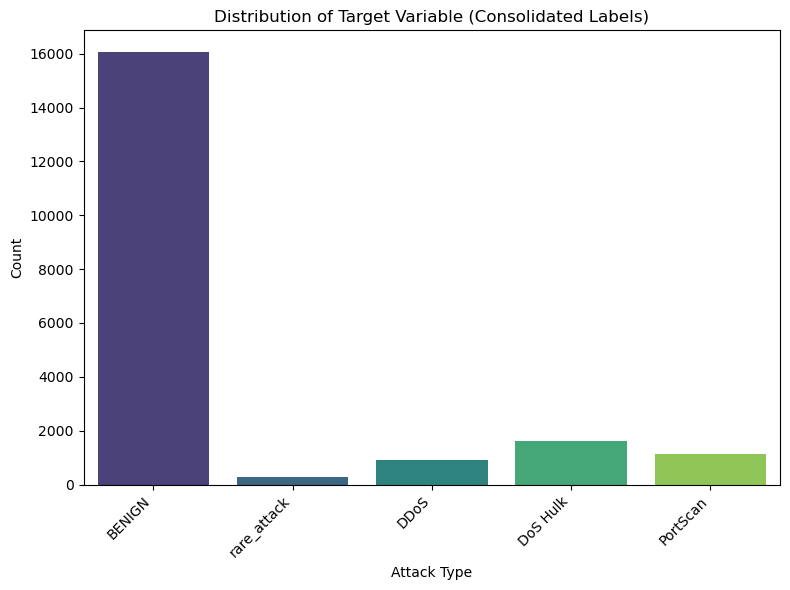

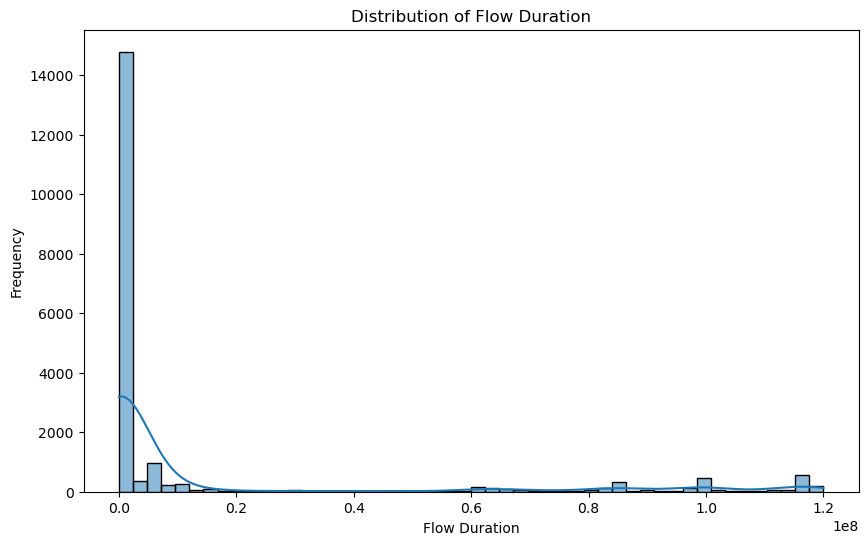

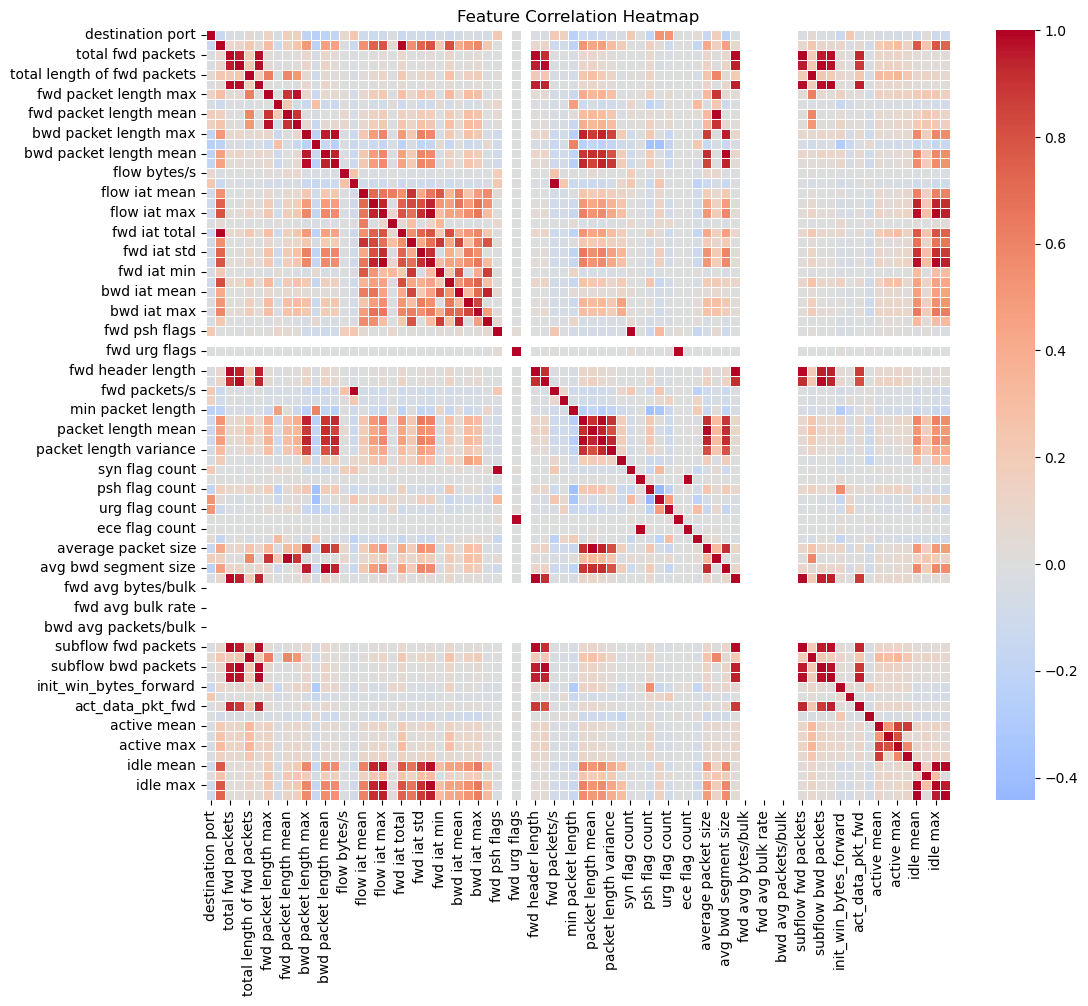


--- Histograms for Key Numerical Features ---



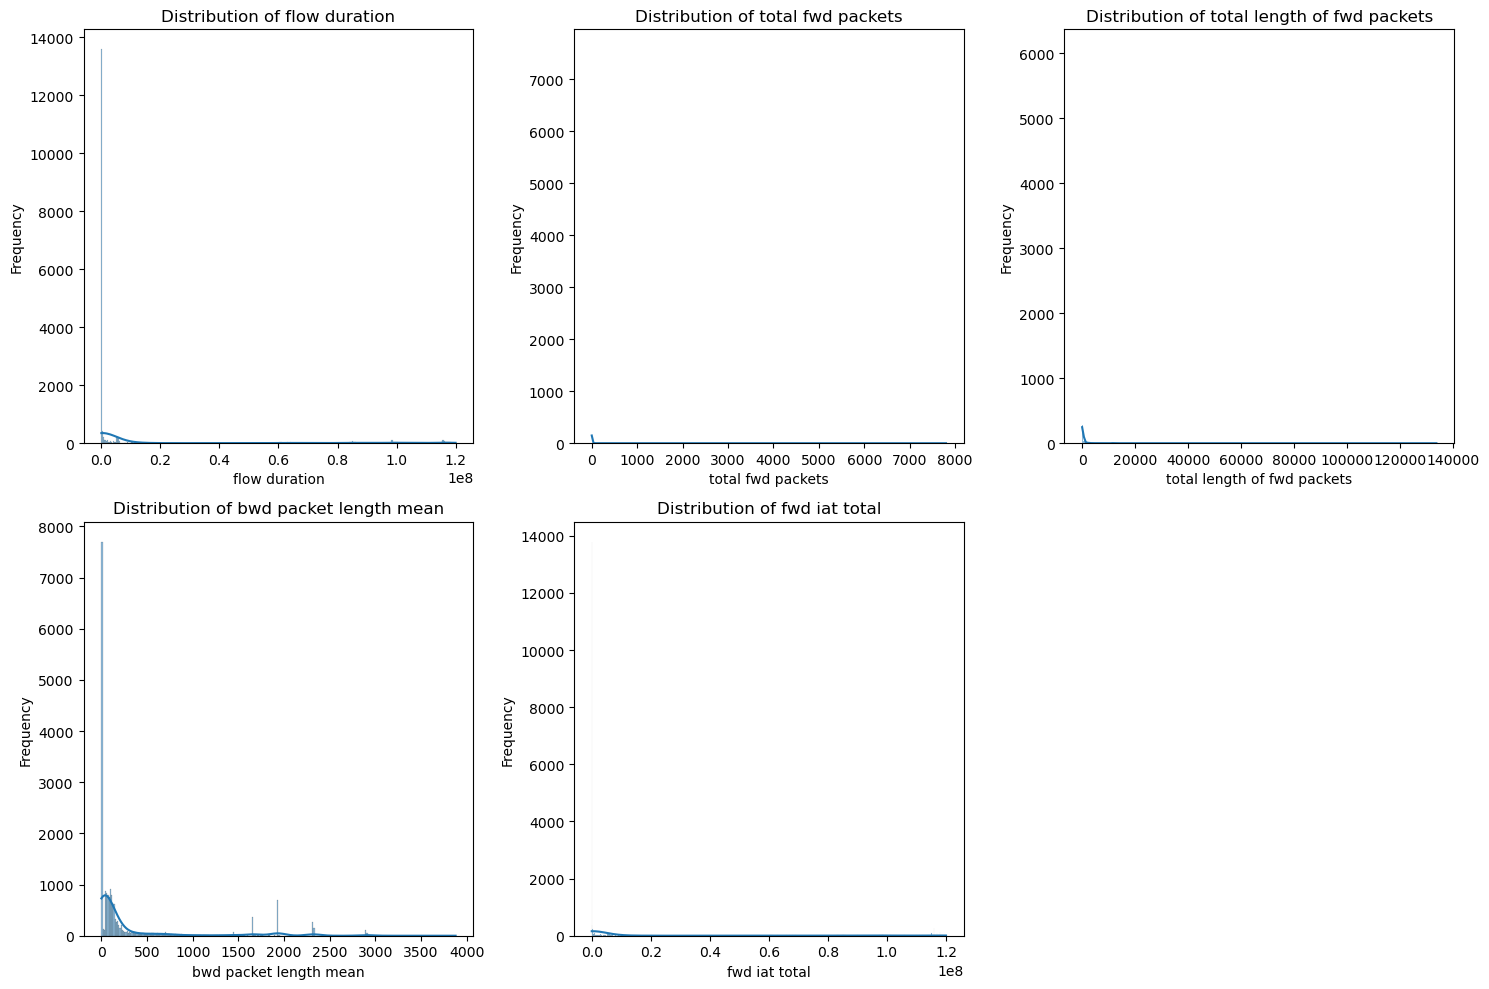


--- Box Plots for Key Numerical Features (Outlier Visualization) ---



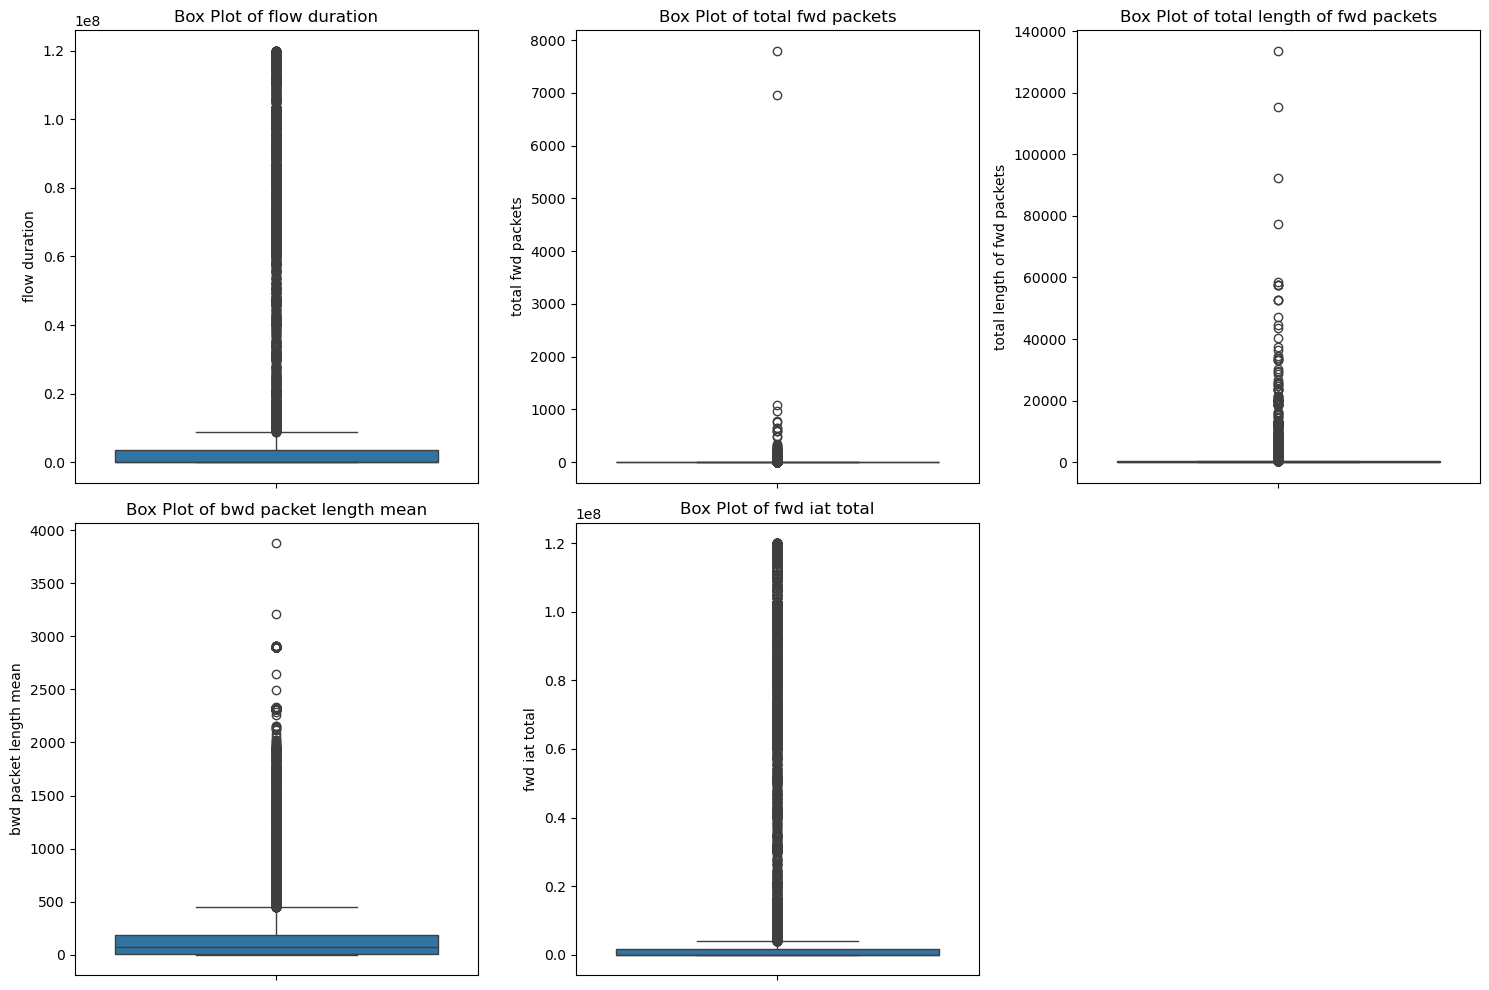


--- Pair Plot for Selected Key Features ---


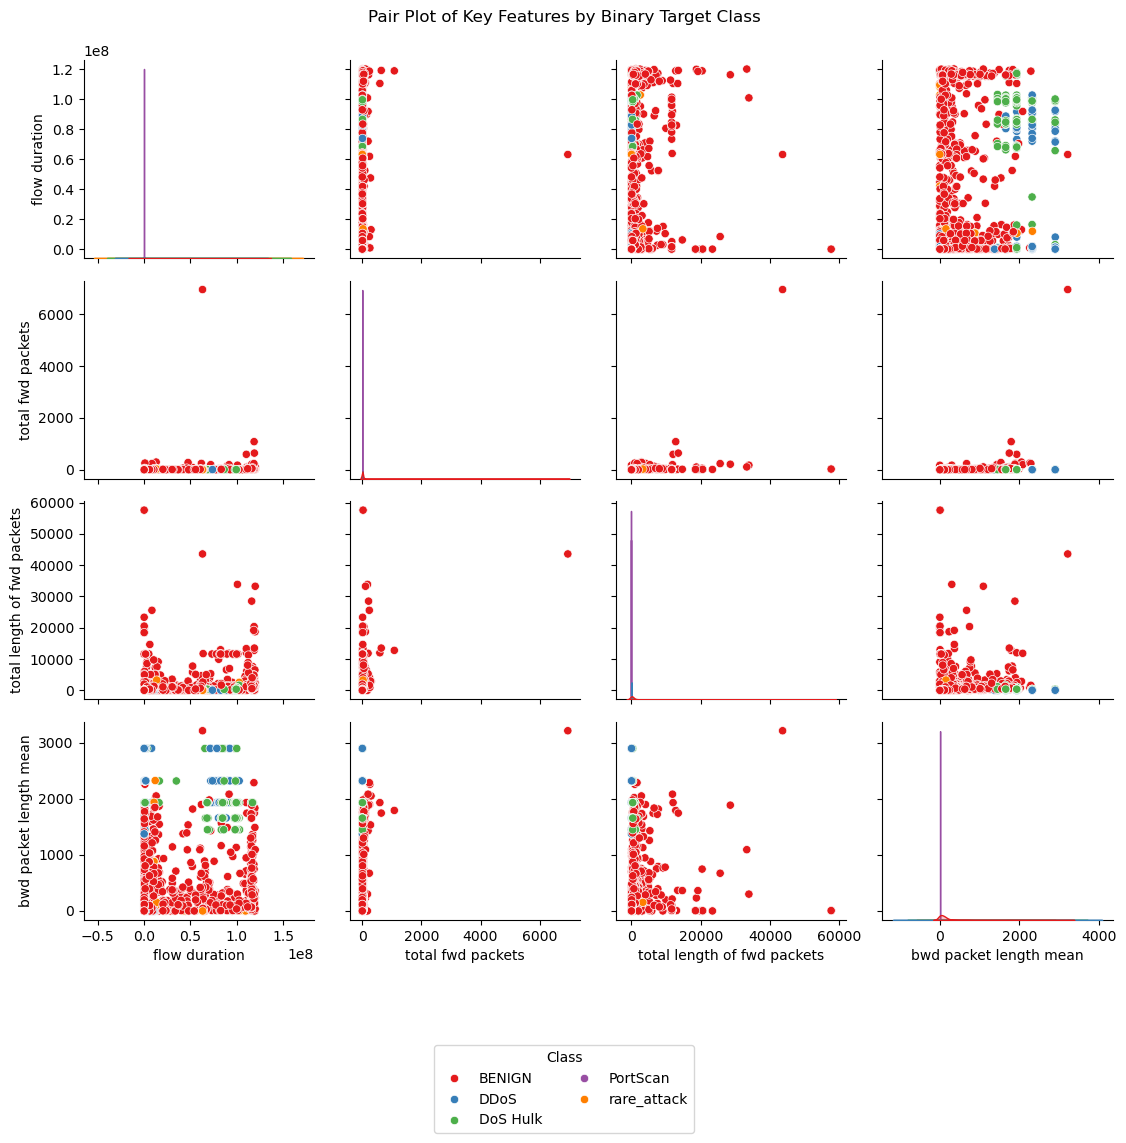


--- End Enhanced EDA ---



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Enhanced Exploratory Data Analysis ---")
print("\nDataset Head (first 5 rows):")
print(df_subset.head())

print("\nDataset Information (Data Types and Non-Null Counts):")
df_subset.info()

print("\nDescriptive Statistics for Numerical Features:")
print(df_subset.describe())

print("\nMissing Values per Column:")
missing_values = df_subset.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

print("\nUnique values per feature (showing features with <= 10 unique values, or indicating many):")
for column in df_subset.columns:
    unique_count = df_subset[column].nunique()
    if unique_count <= 10:
        print(f"  {column}: {unique_count} unique values -> {df_subset[column].unique()}")
    else:
        print(f"  {column}: {unique_count} unique values (many)")

print("\n--- Visual EDA ---")
# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='label_final_display', data=df_subset, palette='viridis') # Using a palette for better visuals
plt.title('Distribution of Target Variable (Consolidated Labels)') # Updated title
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()

# Distribution of a numerical feature (e.g., 'flow duration')
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['flow duration'], bins=50, kde=True)
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
corr = df_subset.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5, annot=False) # annot=False for cleaner view with many features
plt.title("Feature Correlation Heatmap")
plt.show()

# Histograms for selected numerical features
print("\n--- Histograms for Key Numerical Features ---\n")
selected_features_for_hist = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean',
    'fwd iat total'
]

# Sample data for plotting histograms to improve speed
plot_sample_size = min(len(df_subset), 20000) # Sample up to 20,000 data points for plotting
df_plot_sample = df_subset.sample(n=plot_sample_size, random_state=SEED)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_plot_sample[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Box Plots for Key Numerical Features (Outlier Visualization) ---\n")
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_plot_sample[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

print("\n--- Pair Plot for Selected Key Features ---")

# Define numeric features (do not include the label here)
pairplot_features = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean'
]

# Sample data
pairplot_sample_size = min(len(df_subset), 5000)
df_pairplot_sample = df_subset.sample(n=pairplot_sample_size, random_state=SEED)

# Clean label column
df_pairplot_sample = df_pairplot_sample[df_pairplot_sample['label_final_display'].notna()]
df_pairplot_sample['label_final_display'] = df_pairplot_sample['label_final_display'].astype('category')

# Create the pairplot
pairplot = sns.pairplot(
    df_pairplot_sample[pairplot_features + ['label_final_display']],
    hue='label_final_display',
    diag_kind='kde',
    palette='Set1'
)

# Tighten layout *before* adding title or legend
pairplot.fig.tight_layout()

# Add a tighter suptitle
pairplot.fig.suptitle(
    'Pair Plot of Key Features by Binary Target Class',
    y=1.01  # Slightly above the top; adjust if needed
)

if pairplot._legend:
    pairplot._legend.remove()

# Manually add a legend below
handles, labels = pairplot._legend_data.values(), pairplot._legend_data.keys()
pairplot.fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=2,
    title='Class'
)

# Adjust layout
pairplot.fig.subplots_adjust(top=0.96, bottom=0.1)
plt.show()

print("\n--- End Enhanced EDA ---\n")

## 3. Train/Test Split
This section performs the crucial Train/Test Split for the dataset. It divides the features (X) and the numerically encoded target variable (y) into training and testing sets, ensuring a stratified split to maintain the original class proportions in both sets. It then verifies the success of the stratification by displaying and visualizing the proportion of top 5 classes across the full dataset, training set, and test set.

--- Train/Test Split ---
X_train shape: (15993, 78)
X_test shape: (3999, 78)
y_train shape: (15993,)
y_test shape: (3999,)
Class names (from final_label_encoder): ['BENIGN' 'DDoS' 'DoS Hulk' 'PortScan' 'rare_attack']

--- Target Variable Distribution Across Splits ---


<Figure size 1200x700 with 0 Axes>

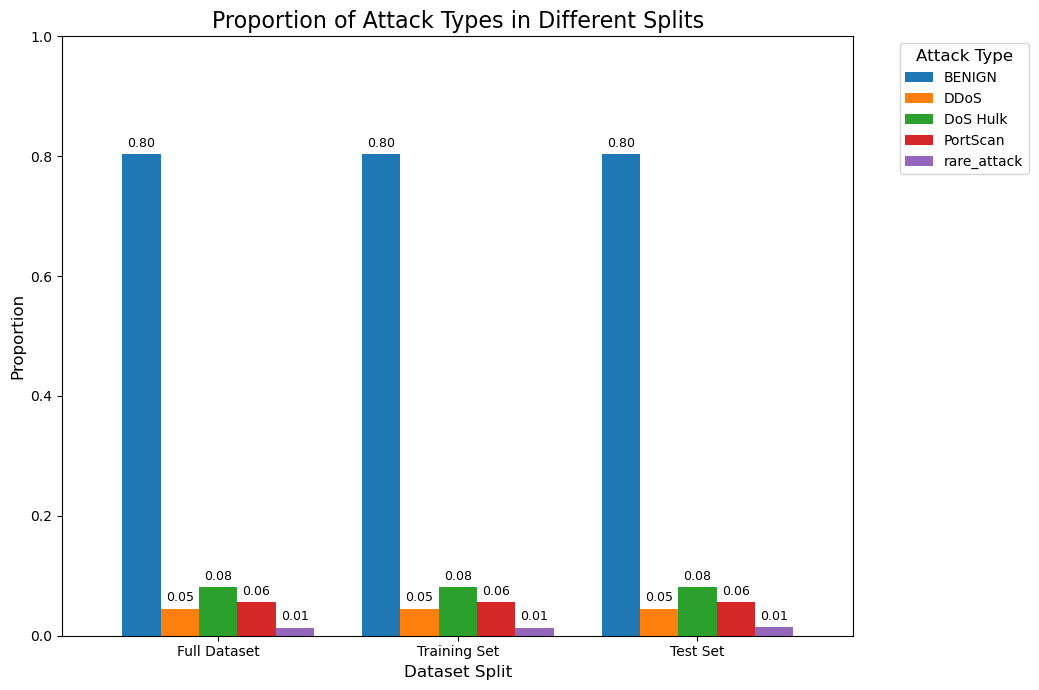


--- End Target Variable Distribution Check ---


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle # Required to load final_label_encoder if it's not in scope from previous cells
import os # Required for os.path.exists if loading from file

print("--- Train/Test Split ---")

# Perform the train-test split using the already numerically encoded 'y'
# 'y' here should be the numerical target created by final_label_encoder in the first stage.
X_train, X_test, y_train, y_test = train_test_split(X, y, # X is features, y is already encoded target
                                                    test_size=0.2,
                                                    stratify=y, # Stratify by the already encoded 'y'
                                                    random_state=SEED) # Ensure SEED is defined from previous cells

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Ensure final_label_encoder is available for inverse mapping ---
# If final_label_encoder is not directly available from the previous cell's execution, load it.
if 'final_label_encoder' not in locals():
    try:
        checkpoints_dir = './model_checkpoints' # Ensure this path is correct
        # --- FIX: Changed filename to match what was saved in the first stage ---
        with open(os.path.join(checkpoints_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder from ./model_checkpoints/final_label_encoder.pkl")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Cannot display class names or plot distribution correctly.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    print(f"Class names (from final_label_encoder): {final_label_encoder.classes_}")
else:
    print("Warning: final_label_encoder not available. Cannot display class names.")


print("\n--- Target Variable Distribution Across Splits ---")

if final_label_encoder is not None:
    y_distribution_df = pd.DataFrame({
        # Use 'y' (the numerically encoded full dataset target) for Full Dataset distribution
        'Full Dataset': pd.Series(y).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Training Set': pd.Series(y_train).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Test Set': pd.Series(y_test).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_)))
    }).T

    # If some classes have 0 occurrences in a split after reindexing, fill with 0
    y_distribution_df = y_distribution_df.fillna(0)

    plt.figure(figsize=(12, 7)) # Adjust figure size
    ax = y_distribution_df.plot(kind='bar', figsize=(12, 7), rot=0, width=0.8) # Adjust width for better visual

    plt.title("Proportion of Attack Types in Different Splits", fontsize=16)
    plt.xlabel("Dataset Split", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.ylim(0, 1)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

else:
    print("Skipping target variable distribution plot as final_label_encoder is not available.")

print("\n--- End Target Variable Distribution Check ---")

## 4. Feature Engineering
This section performs Feature Engineering and Resampling. It preprocesses the data by capping outliers, scaling features, and reducing dimensionality with PCA, visualized via component loadings. Finally, it addresses class imbalance in the training set using SMOTE to create a balanced dataset for model training.


--- Defining and Applying Preprocessing Pipeline ---
X_train_processed shape (after scaling, IQR, PCA): (15993, 7)
X_test_processed shape (after scaling, IQR, PCA): (3999, 7)
Preprocessing pipeline saved to ./model_checkpoints/preprocessor.joblib
PCA component names saved to ./model_checkpoints/pca_component_names.pkl
SHAP background data (sampled X_train_processed) saved to ./model_checkpoints/X_train_processed_for_shap_background.joblib

Original Feature Names (before PCA):
['destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd ia

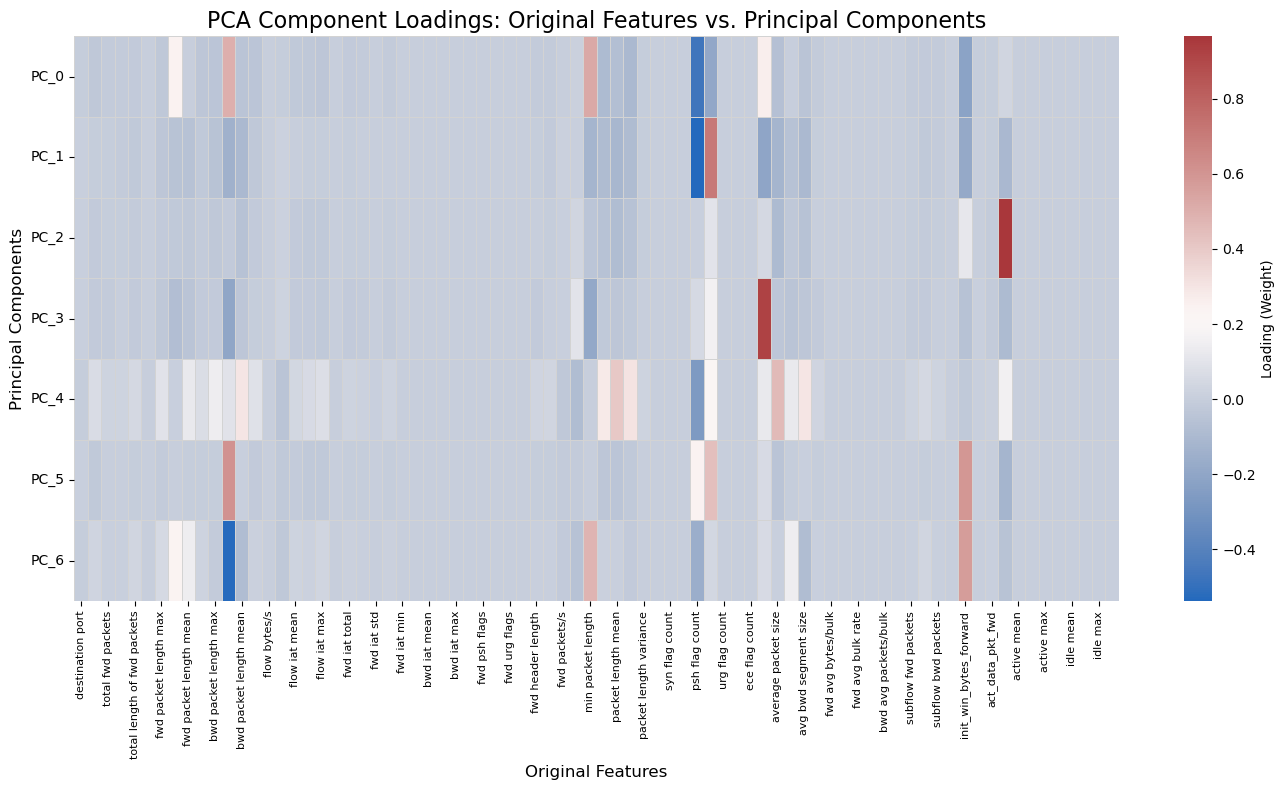


--- Interpretation of Heatmap: ---
- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).
- **Color Hue (Red/Blue):**
  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.
  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.
- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.
- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.
Training column names saved to ./model_checkpoints/training_columns.pkl
Shape of X_train after SMOTE: (64250, 7)
Shape of y_train after SMOTE: (64250,)
Class distribution after SMOTE:
0    12850
1    12850
3    12850
2    12850
4    12850
N

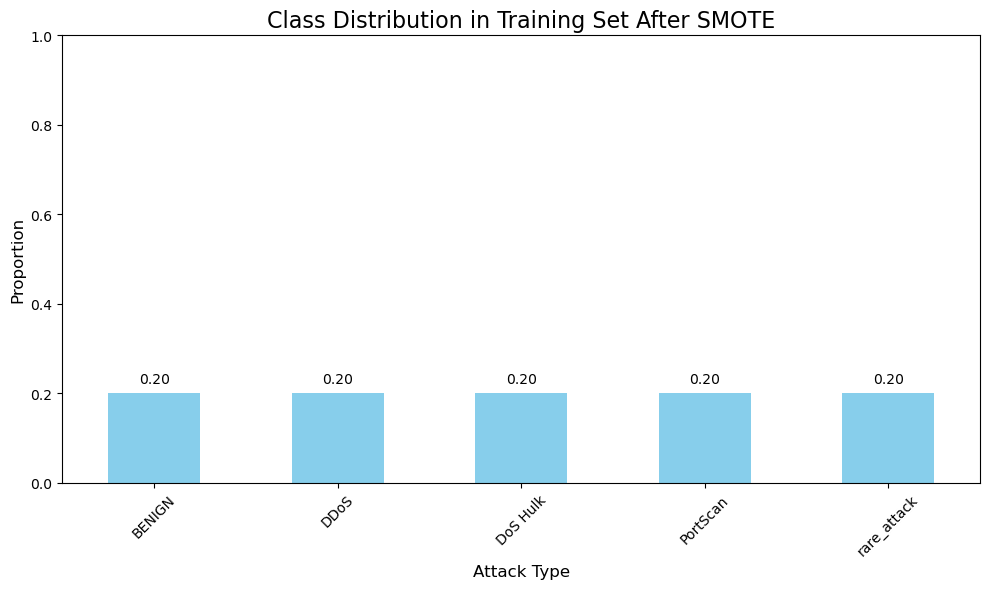


--- End Feature Engineering & Resampling ---


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
import pickle
import os
import joblib # Added joblib for saving pipelines

# Custom Transformer for IQR-based Outlier Capping
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        # Calculate Q1, Q3, and IQR for each feature (column)
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - self.factor * IQR
        self.upper_bound = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        # Clip values to the calculated bounds for each feature
        return np.clip(X, self.lower_bound, self.upper_bound)

print("\n--- Defining and Applying Preprocessing Pipeline ---")
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Standardize features
    ('iqr_capper', IQROutlierCapper(factor=1.5)), # Cap outliers
    ('pca', PCA(n_components=7))       # Apply PCA
    #('pca', PCA(n_components=0.95))       # Apply PCA, retaining 95% of variance
])

# Fit the pipeline on training data and transform both training and test data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Check to ensure the number of PCA components is as expected
expected_components = 7 # Should match the number you set in the PCA step
num_pca_components = X_train_processed.shape[1]
assert num_pca_components == expected_components, f"ERROR: PCA components mismatch. Expected {expected_components}, but got {num_pca_components}."

# Get the number of components after PCA
num_pca_components = X_train_processed.shape[1]
pca_component_names = [f'PC_{i}' for i in range(num_pca_components)]

# Convert X_train_processed and X_test_processed to DataFrames with PCA component names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=pca_component_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=pca_component_names, index=X_test.index)

print(f"X_train_processed shape (after scaling, IQR, PCA): {X_train_processed_df.shape}")
print(f"X_test_processed shape (after scaling, IQR, PCA): {X_test_processed_df.shape}")

# --- Save the fitted preprocessing pipeline ---
preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor.joblib')
joblib.dump(preprocessing_pipeline, preprocessor_path)
print(f"Preprocessing pipeline saved to {preprocessor_path}")

# --- Save the list of PCA component names
pca_names_path = os.path.join(checkpoint_dir, 'pca_component_names.pkl')
with open(pca_names_path, 'wb') as f:
    pickle.dump(pca_component_names, f)
print(f"PCA component names saved to {pca_names_path}")

# --- Save a small sample of X_train_processed for SHAP background data ---
# This is crucial for KernelExplainer and DeepExplainer in the prediction stage
shap_background_sample_size = min(500, X_train_processed.shape[0]) # Limit size for efficiency
np.random.seed(SEED) # Ensure reproducibility
if X_train_processed.shape[0] > 0:
    indices = np.random.choice(X_train_processed.shape[0], shap_background_sample_size, replace=False)
    X_train_processed_for_shap_background = X_train_processed[indices]
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background.joblib')
    joblib.dump(X_train_processed_for_shap_background, shap_background_path)
    print(f"SHAP background data (sampled X_train_processed) saved to {shap_background_path}")
else:
    print("Warning: X_train_processed is empty. Cannot save SHAP background data.")


# Get original feature names from X_train (assuming X_train is a Pandas DataFrame)
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns.tolist()
else:
    # Fallback for NumPy arrays if X_train is not a DataFrame
    num_original_features = X_train.shape[1]
    original_feature_names = [f'Original_Feature_{i}' for i in range(num_original_features)]

print(f"\nOriginal Feature Names (before PCA):")
print(original_feature_names)

# Print the features (Principal Components) remaining after PCA
num_pca_components = X_train_processed.shape[1]
pca_features = [f'PC_{i}' for i in range(num_pca_components)]
print(f"\nFeatures remaining after PCA (Principal Components):")
print(pca_features)


print("\n--- Mapping of Principal Components to Original Features (PCA Loadings) ---")
# Access the fitted PCA model from the pipeline
pca_model = preprocessing_pipeline.named_steps['pca']

# The components_ attribute holds the principal components (eigenvectors)
# Each row is a principal component, and columns are original features
pca_loadings = pd.DataFrame(pca_model.components_,
                             columns=original_feature_names,
                             index=pca_features)

print("This table shows the 'loadings' or 'weights' of each original feature on each Principal Component:")
print(pca_loadings)

print("\nInterpretation Notes:")
print("- Each row represents a Principal Component (e.g., PC_0).")
print("- Each column represents an Original Feature.")
print("- The values in the table indicate how much each original feature contributes to each Principal Component.")
print("- Larger absolute values (positive or negative) mean a stronger contribution.")
print("- For example, looking at PC_0, features with the largest absolute values are the most influential in defining PC_0.")


# --- VISUALIZATION START ---
plt.figure(figsize=(14, max(8, num_pca_components * 0.8))) # Adjust figure size dynamically
sns.heatmap(pca_loadings, cmap='vlag', annot=False, fmt=".2f", linewidths=.5, linecolor='lightgray',
            cbar_kws={'label': 'Loading (Weight)'})
plt.title('PCA Component Loadings: Original Features vs. Principal Components', fontsize=16)
plt.xlabel('Original Features', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.xticks(rotation=90, fontsize=8) # Rotate labels for readability
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Heatmap: ---")
print("- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).")
print("- **Color Hue (Red/Blue):**")
print("  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.")
print("  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.")
print("- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.")
print("- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.")
# --- VISUALIZATION END ---

# --- Applying SMOTE for Class Imbalance ---
smote = SMOTE(random_state=SEED, sampling_strategy='auto', k_neighbors=5)

# Perform SMOTE - this will return NumPy arrays
X_train_res_np, y_train_res = smote.fit_resample(X_train_processed_df, y_train) # Use the DataFrame here

# CONVERT X_train_res back to a DataFrame using the PCA component names
X_train_res = pd.DataFrame(X_train_res_np, columns=pca_component_names, index=y_train_res.index)

# --- NEW BLOCK TO INSERT ---
# Save Training Column Names for Stacking Classifier
# This block uses the PCA component names which are the final features for training
training_columns_path = os.path.join(checkpoint_dir, "training_columns.pkl")
with open(training_columns_path, "wb") as f:
    pickle.dump(pca_component_names, f)
print(f"Training column names saved to {training_columns_path}")
# --- END NEW BLOCK ---

print(f"Shape of X_train after SMOTE: {X_train_res.shape}")
print(f"Shape of y_train after SMOTE: {y_train_res.shape}")
print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\n--- Target Variable Distribution After SMOTE ---") # This print was present in your original code

# Ensure final_label_encoder is available for inverse mapping for the plot
if 'final_label_encoder' not in locals():
    try:
        # Robustly define checkpoint_dir here too if needed, though assumed from above
        # checkpoint_dir = './model_checkpoints'
        # --- FIX: Corrected filename to match what was saved in the first stage ---
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for SMOTE plot.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found for SMOTE plot. Cannot map numerical labels to names.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    # Create a Series from y_train_res and get normalized value counts
    smote_distribution = pd.Series(y_train_res).value_counts(normalize=True)

    # Reindex to ensure all classes are present and use original class names from final_label_encoder
    smote_distribution = smote_distribution.reindex(range(len(final_label_encoder.classes_))).fillna(0)
    smote_distribution.index = final_label_encoder.classes_ # Map numerical labels back to original names

    plt.figure(figsize=(10, 6))
    ax = smote_distribution.plot(kind='bar', color='skyblue', rot=45)

    plt.title("Class Distribution in Training Set After SMOTE", fontsize=16)
    plt.xlabel("Attack Type", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.ylim(0, 1) # Proportions range from 0 to 1
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=5)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping SMOTE distribution plot as final_label_encoder is not available.")

print("\n--- End Feature Engineering & Resampling ---")

## 5. Classification Task ML Modeling
This section focuses on training and initial evaluation of various machine learning and deep learning models for multi-class classification. It establishes a baseline with a Dummy Classifier, then trains untuned Logistic Regression, Random Forest, and XGBoost models, performing cross-validation for robust assessment. Finally, it defines, trains, and evaluates Feedforward Neural Network (FFN) and Long Short-Term Memory (LSTM) models using PyTorch. All models are evaluated on the processed test set using metrics like F1-score and ROC AUC, and then saved.

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score # ADDED roc_auc_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os
import pickle # Added for pickle.load/dump

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # <--- THIS IS THE ONE YOU'RE MISSING OR NOT EXECUTING


# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        # --- FIX: Corrected filename for loading ---
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        final_label_encoder = None

# ---- ++++

# Load the preprocessor and PCA component names from the feature engineering stage
try:
    preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor.joblib')
    preprocessing_pipeline = joblib.load(preprocessor_path)
    print(f"Preprocessing pipeline loaded from {preprocessor_path}")

    pca_names_path = os.path.join(checkpoint_dir, 'pca_component_names.pkl')
    with open(pca_names_path, 'rb') as f:
        pca_component_names = pickle.load(f)
    print(f"PCA component names loaded from {pca_names_path}")

except FileNotFoundError:
    print("ERROR: Preprocessing artifacts not found. Please run the feature engineering stage first.")
    # Exit or handle gracefully
    raise # Re-raise the error to stop execution

# --- Assuming raw X_train, y_train, X_test, y_test are available from a previous data loading stage ---

# Process the raw data using the loaded pipeline
X_train_processed_df = pd.DataFrame(preprocessing_pipeline.transform(X_train),
                                    columns=pca_component_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(preprocessing_pipeline.transform(X_test),
                                   columns=pca_component_names, index=X_test.index)

print(f"Shape of X_train processed (from loaded pipeline): {X_train_processed_df.shape}")
print(f"Shape of X_test processed (from loaded pipeline): {X_test_processed_df.shape}")

# Re-apply SMOTE to ensure a balanced training set
smote = SMOTE(random_state=SEED, sampling_strategy='auto', k_neighbors=5)
X_train_res_np, y_train_res = smote.fit_resample(X_train_processed_df, y_train)
X_train_res = pd.DataFrame(X_train_res_np, columns=pca_component_names, index=y_train_res.index)
print(f"Shape of X_train after SMOTE: {X_train_res.shape}")
print(f"Shape of y_train after SMOTE: {y_train_res.shape}")

# +++ ------

# --- Baseline Model (Dummy Classifier) ---
print("\n--- Training Baseline Model (Dummy Classifier) ---")
dummy_model = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_model.fit(X_train_res, y_train_res)

# Checkpoint 1: Save Dummy Classifier
dummy_model_path = os.path.join(checkpoint_dir, "dummy_model.pkl")
joblib.dump(dummy_model, dummy_model_path)
print(f"Checkpoint: Dummy Classifier saved to {dummy_model_path}")

#y_pred_dummy = dummy_model.predict(X_test_processed)
y_pred_dummy = dummy_model.predict(X_test_processed_df)

print("\nClassification Report for Baseline Model:")
unique_test_labels = np.unique(y_test)
if final_label_encoder is not None: # Use final_label_encoder
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)} # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_dummy, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_dummy, zero_division=0))


# Define simplified "pipelines" (just the model) since preprocessing is already done on X_train_res and X_test_processed
print("\n--- Defining Model 'Pipelines' (Model Only) ---")

# --- Logistic Regression ---
pipeline_lr = Pipeline([
    ('model', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=SEED, n_jobs=-1))
])

# --- Random Forest Classifier ---
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1, class_weight='balanced'))
])


#----
# --- XGBoost Classifier Pipeline ---
# Ensure final_label_encoder is not None before accessing its classes
num_classes_xgb = len(final_label_encoder.classes_) if final_label_encoder is not None else 2

# CRITICAL: The pipeline now only contains the model, as data is already preprocessed and SMOTEd
pipeline_xgb = Pipeline([ # <--- Changed back to standard sklearn Pipeline
    # No 'preprocessor' step here because X_train_res is already preprocessed
    # No 'smote' step here because X_train_res is already SMOTEd
    ('model', xgb.XGBClassifier(objective='multi:softprob', # Use softprob for predict_proba
                                eval_metric='mlogloss',
                                num_class=num_classes_xgb,
                                n_estimators=100, # This will be overridden by Optuna tuning
                                random_state=SEED,
                                n_jobs=-1,
                                tree_method='hist'))
])

print("\n--- Pipeline `pipeline_xgb` has been successfully defined with only the 'model' step. ---")


# --- Logistic Regression Training and CV ---
print("\n--- Training Logistic Regression Model Pipeline ---")
pipeline_lr.fit(X_train_res, y_train_res)

# Checkpoint 2: Save Logistic Regression Pipeline
lr_pipeline_path = os.path.join(checkpoint_dir, "logistic_regression_pipeline.pkl")
joblib.dump(pipeline_lr, lr_pipeline_path)
print(f"Checkpoint: Logistic Regression Pipeline saved to {lr_pipeline_path}")

y_pred_lr = pipeline_lr.predict(X_test_processed_df)
y_prob_lr = pipeline_lr.predict_proba(X_test_processed_df) # Correctly assigned

print("\n--- Cross-Validation for Logistic Regression Pipeline ---")
cv_scores_lr = cross_val_score(pipeline_lr, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=0)
print(f"Logistic Regression CV F1-scores (Macro): {cv_scores_lr}")
print(f"Logistic Regression Mean CV F1-score (Macro): {np.mean(cv_scores_lr):.4f} (+/- {np.std(cv_scores_lr):.4f})")
print("\nClassification Report for Logistic Regression:")
if final_label_encoder is not None:
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_lr, zero_division=0))

try:
    roc_auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
    print(f"Logistic Regression ROC AUC (One-vs-Rest): {roc_auc_lr:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for LR: {e}")

# --- Random Forest Classifier Training and CV ---
print("\n--- Training Random Forest Model Pipeline ---")
pipeline_rf.fit(X_train_res, y_train_res)

# Checkpoint 3: Save Random Forest Pipeline
rf_pipeline_path = os.path.join(checkpoint_dir, "random_forest_pipeline.pkl")
joblib.dump(pipeline_rf, rf_pipeline_path)
print(f"Checkpoint: Random Forest Pipeline saved to {rf_pipeline_path}")

y_pred_rf = pipeline_rf.predict(X_test_processed_df)
y_prob_rf = pipeline_rf.predict_proba(X_test_processed_df) # Correctly assigned

print("\n--- Cross-Validation for Random Forest Pipeline ---")
cv_scores_rf = cross_val_score(pipeline_rf, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=0)
print(f"Random Forest CV F1-scores (Macro): {cv_scores_rf}")
print(f"Random Forest Mean CV F1-score (Macro): {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf):.4f})")
print("\nClassification Report for Random Forest:")
if final_label_encoder is not None:
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_rf, zero_division=0))

try:
    roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
    print(f"Random Forest ROC AUC (One-vs-Rest): {roc_auc_rf:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for RF: {e}")

# --- XGBoost Classifier Training and CV ---
print("\n--- Training Initial XGBoost Model Pipeline ---")
pipeline_xgb.fit(X_train_res, y_train_res)


# Checkpoint 4: Save XGBoost Pipeline
xgb_pipeline_path = os.path.join(checkpoint_dir, "xgboost_pipeline.pkl")
joblib.dump(pipeline_xgb, xgb_pipeline_path)
print(f"Checkpoint: XGBoost Pipeline saved to {xgb_pipeline_path}")

y_pred_xgb = pipeline_xgb.predict(X_test_processed_df)
y_prob_xgb = pipeline_xgb.predict_proba(X_test_processed_df) # Correctly assigned


print("\n--- Cross-Validation for Initial XGBoost Model Pipeline ---")
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train_res, y_train_res,
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                 scoring='f1_macro',
                                 n_jobs=-1,
                                 verbose=0)
print(f"Initial XGBoost CV F1-scores (Macro): {cv_scores_xgb}")
print(f"Initial XGBoost Mean CV F1-score (Macro): {np.mean(cv_scores_xgb):.4f} (+/- {np.std(cv_scores_xgb):.4f})")
print("\nClassification Report for XGBoost:")
if final_label_encoder is not None:
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_xgb, zero_division=0))

try:
    roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb, multi_class='ovr')
    print(f"XGBoost ROC AUC (One-vs-Rest): {roc_auc_xgb:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for XGBoost: {e}")

# --- PyTorch Neural Networks (FFN and LSTM) ---

# Ensure num_classes is defined before FFN/LSTM instantiation
num_classes = len(final_label_encoder.classes_) if final_label_encoder is not None else 2 # Fallback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device for PyTorch models: {device}")

# Convert X_train_res (DataFrame) to a NumPy array before converting to tensor
X_train_tensor = torch.tensor(X_train_res.values, dtype=torch.float32) # .values converts DataFrame to NumPy array
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long) # Assuming y_train_res is already array-like (e.g., NumPy array or list)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Define simple feedforward network
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes, dropout=0.3):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout) # Renamed to avoid conflict with method name

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_layer(x) # Applied dropout
        x = self.relu(self.fc2(x))
        x = self.dropout_layer(x) # Applied dropout
        x = self.fc3(x)
        return x

# Define RNN (LSTM) Model
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # CORRECTED: input_size should be the number of features (PCA components)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # CORRECTED: Reshape input for LSTM. Data is tabular, so sequence length is 1.
        # Original shape: (batch_size, num_features)
        # Target shape: (batch_size, sequence_length=1, num_features)
        x = x.unsqueeze(1) 
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Take the output of the last time step
        return out
        
# --- Define FFN Hyperparameters ---
ffn_hidden_dim1 = 128 # Example value
ffn_hidden_dim2 = 64  # Example value

# Instantiate and train FFN
print("\n--- Training Feedforward Neural Network ---")
# CORRECTED: Pass all required arguments to FFN constructor
ffn_model = FFN(X_train_res.shape[1], ffn_hidden_dim1, ffn_hidden_dim2, num_classes).to(device)
criterion_ffn = nn.CrossEntropyLoss()
optimizer_ffn = optim.Adam(ffn_model.parameters(), lr=0.001)

epochs_ffn = 30
ffn_model.train()
ffn_train_losses = []
for epoch in range(epochs_ffn):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_ffn.zero_grad()
        outputs = ffn_model(batch_X)
        loss = criterion_ffn(outputs, batch_y)
        loss.backward()
        optimizer_ffn.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    ffn_train_losses.append(avg_epoch_loss)
    print(f"FFN Epoch {epoch+1}/{epochs_ffn}, Loss: {avg_epoch_loss:.4f}")

# Checkpoint 5: Save FFN Model
ffn_model_path = os.path.join(checkpoint_dir, "ffn_model_state_dict.pth")
torch.save(ffn_model.state_dict(), ffn_model_path)
print(f"Checkpoint: FFN model state_dict saved to {ffn_model_path}")

# ---  FFN Evaluation ---
ffn_model.eval()
with torch.no_grad():
    X_test_tensor_ffn = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    
    # 1. Get the raw logits from the model and move to CPU
    y_pred_logits_ffn = ffn_model(X_test_tensor_ffn).cpu()
    
    # 2. Apply softmax for multi-class probabilities
    y_pred_proba_ffn = torch.softmax(y_pred_logits_ffn, dim=1)
    
    # 3. Convert to numpy arrays for sklearn metrics
    y_pred_proba_np_ffn = y_pred_proba_ffn.numpy()
    y_pred_labels_ffn = np.argmax(y_pred_proba_np_ffn, axis=1)

print("\nClassification Report for FFN:")
if 'final_label_encoder' in locals() and final_label_encoder is not None:
    # Ensure label_mapping is available from earlier code
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(np.unique(y_test))]
    print(classification_report(y_test, y_pred_labels_ffn, labels=sorted(np.unique(y_test)), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_labels_ffn, zero_division=0))


try:
    # 4. Calculate ROC AUC using the correct probabilities and multi-class strategy
    roc_auc_ffn = roc_auc_score(y_test, y_pred_proba_np_ffn, multi_class='ovr')
    print(f"FFN ROC AUC (One-vs-Rest): {roc_auc_ffn:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This may be due to some classes not being present in y_test or y_pred.")

# Instantiate and train LSTMNet
print("\n--- Training Recurrent Neural Network (LSTM) ---")
input_dim_lstm = X_train_res.shape[1] # Number of features (PCA components)
hidden_dim_lstm = 64
num_layers_lstm = 1

lstm_model = LSTMNet(input_dim_lstm, hidden_dim_lstm, num_layers_lstm, num_classes).to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

epochs_lstm = 50
lstm_model.train()
lstm_train_losses = []
for epoch in range(epochs_lstm):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion_lstm(outputs, batch_y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    lstm_train_losses.append(avg_epoch_loss)
    print(f"LSTM Epoch {epoch+1}/{epochs_lstm}, Loss: {avg_epoch_loss:.4f}")

# --- Save LSTM Model
lstm_model_path = os.path.join(checkpoint_dir, "lstm_model_state_dict.pth")
torch.save(lstm_model.state_dict(), lstm_model_path)
print(f"Checkpoint: LSTM model state_dict saved to {lstm_model_path}")

# --- LSTM Evaluation ---
lstm_model.eval()
with torch.no_grad():
    X_test_tensor_lstm = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    
    # 1. Get the raw logits from the model and move to CPU
    y_pred_logits_lstm = lstm_model(X_test_tensor_lstm).cpu()
    
    # 2. Apply softmax for multi-class probabilities
    y_pred_proba_lstm = torch.softmax(y_pred_logits_lstm, dim=1)
    
    # 3. Convert to numpy arrays for sklearn metrics
    y_pred_proba_np_lstm = y_pred_proba_lstm.numpy()
    y_pred_labels_lstm = np.argmax(y_pred_proba_np_lstm, axis=1)

print("\nClassification Report for LSTM:")
if 'final_label_encoder' in locals() and final_label_encoder is not None:
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(np.unique(y_test))]
    print(classification_report(y_test, y_pred_labels_lstm, labels=sorted(np.unique(y_test)), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_labels_lstm, zero_division=0))


# --- ROC AUC Calculation ---
try:
    roc_auc_lstm = roc_auc_score(y_test, y_pred_proba_np_lstm, multi_class='ovr')
    print(f"LSTM ROC AUC (One-vs-Rest): {roc_auc_lstm:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This may be due to some classes not being present in y_test or y_pred.")

print("\n--- End Model Training and Evaluation ---")


Preprocessing pipeline loaded from ./model_checkpoints/preprocessor.joblib
PCA component names loaded from ./model_checkpoints/pca_component_names.pkl
Shape of X_train processed (from loaded pipeline): (15993, 7)
Shape of X_test processed (from loaded pipeline): (3999, 7)
Shape of X_train after SMOTE: (64250, 7)
Shape of y_train after SMOTE: (64250,)

--- Training Baseline Model (Dummy Classifier) ---
Checkpoint: Dummy Classifier saved to ./model_checkpoints/dummy_model.pkl

Classification Report for Baseline Model:
              precision    recall  f1-score   support

      BENIGN       0.80      1.00      0.89      3213
        DDoS       0.00      0.00      0.00       181
    DoS Hulk       0.00      0.00      0.00       325
    PortScan       0.00      0.00      0.00       225
 rare_attack       0.00      0.00      0.00        55

    accuracy                           0.80      3999
   macro avg       0.16      0.20      0.18      3999
weighted avg       0.65      0.80      0.72 

## 6(a). Hyperparameter Tuning of the Logistic Regression & Random Forest Models
This section focuses on Hyperparameter Tuning for the previously defined Logistic Regression and the Random Forest models. Using GridSearchCV with stratified cross-validation and F1-score as the primary metric, it systematically searches for the optimal hyperparameters for each model. The best-performing tuned models are then saved and their performance is reported on the test set using detailed classification reports.

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os
import pickle
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = None

# Re-define pipelines to ensure they are available for tuning
pipeline_lr = Pipeline([('model', LogisticRegression(random_state=SEED, n_jobs=-1))])
pipeline_rf = Pipeline([('model', RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced'))])


print("\n--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---")

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga'],
    'model__penalty': ['l2']
}

grid_search_lr_pipeline = GridSearchCV(estimator=pipeline_lr,
                                       param_grid=param_grid_lr,
                                       scoring='f1_macro',
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on your processed and resampled training data
grid_search_lr_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Logistic Regression Pipeline: {grid_search_lr_pipeline.best_params_}")
print(f"Best cross-validation F1-score (Macro) for Logistic Regression: {grid_search_lr_pipeline.best_score_:.4f}")

# Store the best performing Logistic Regression model (which is part of a pipeline)
best_lr_model_pipeline = grid_search_lr_pipeline.best_estimator_

# ---- Save Tuned Logistic Regression Pipeline
tuned_lr_pipeline_path = os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl")
joblib.dump(best_lr_model_pipeline, tuned_lr_pipeline_path)
print(f"Checkpoint: Tuned Logistic Regression Pipeline saved to {tuned_lr_pipeline_path}")

# Make predictions on the preprocessed test set
y_pred_best_lr = best_lr_model_pipeline.predict(X_test_processed_df)
y_prob_best_lr = best_lr_model_pipeline.predict_proba(X_test_processed_df)

print("\nClassification Report for Best Tuned Logistic Regression Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_lr, zero_division=0))

try:
    roc_auc_lr = roc_auc_score(y_test, y_prob_best_lr, multi_class='ovr')
    print(f"Logistic Regression ROC AUC (One-vs-Rest): {roc_auc_lr:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for LR: {e}")

print("\n--- Hyperparameter Tuning for Random Forest Pipeline (GridSearchCV) ---")

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf_pipeline = GridSearchCV(estimator=pipeline_rf,
                                       param_grid=param_grid_rf,
                                       scoring='f1_macro',
                                       # Corrected the typo here
                                       cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on X_train_res, y_train_res
grid_search_rf_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Random Forest Pipeline: {grid_search_rf_pipeline.best_params_}")
print(f"Best cross-validation F1-score (Macro) for Random Forest: {grid_search_rf_pipeline.best_score_:.4f}")

best_rf_model_pipeline = grid_search_rf_pipeline.best_estimator_

# ----- Save Tuned Random Forest Pipeline
tuned_rf_pipeline_path = os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl")
joblib.dump(best_rf_model_pipeline, tuned_rf_pipeline_path)
print(f"Checkpoint: Tuned Random Forest Pipeline saved to {tuned_rf_pipeline_path}")

y_pred_best_rf = best_rf_model_pipeline.predict(X_test_processed_df)
y_prob_best_rf = best_rf_model_pipeline.predict_proba(X_test_processed_df)

print("\nClassification Report for Best Tuned Random Forest Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_rf, zero_division=0))

try:
    roc_auc_rf = roc_auc_score(y_test, y_prob_best_rf, multi_class='ovr')
    print(f"Random Forest ROC AUC (One-vs-Rest): {roc_auc_rf:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for RF: {e}")
    


--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---

Best parameters for Logistic Regression Pipeline: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best cross-validation F1-score (Macro) for Logistic Regression: 0.8004
Checkpoint: Tuned Logistic Regression Pipeline saved to ./model_checkpoints/tuned_logistic_regression_pipeline.pkl

Classification Report for Best Tuned Logistic Regression Model:
              precision    recall  f1-score   support

      BENIGN       1.00      0.54      0.70      3213
        DDoS       0.21      1.00      0.34       181
    DoS Hulk       0.65      0.61      0.63       325
    PortScan       0.83      1.00      0.91       225
 rare_attack       0.06      0.87      0.11        55

    accuracy                           0.60      3999
   macro avg       0.55      0.80      0.54      3999
weighted avg       0.91      0.60      0.68      3999

Logistic Regression ROC AUC (One-vs-Rest): 0.9481

--- Hyperpar

## 6(b). Hyperparameter Tuning of the XGBoost Model
This section details the hyperparameter tuning and training of the multi-class XGBoost classification model. It utilizes the Optuna framework to systematically search for the optimal combination of XGBoost hyperparameters, aiming to maximize the weighted F1-score through stratified cross-validation. The preprocessing steps (scaling numerical features and one-hot encoding categorical features) are integrated via sklearn's ColumnTransformer and Pipeline. The best-performing XGBoost model, identified during the Optuna optimization, is then trained on the full preprocessed training dataset and saved. Its effectiveness is subsequently assessed on the unseen test set using a comprehensive classification report and the ROC AUC score.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import optuna
import xgboost as xgb
import xgboost.callback as xgb_cb

# --- Assumed global variables (ensure these are defined in your environment) ---
if 'SEED' not in globals():
    SEED = 42
    print("WARNING: SEED not found, using default 42 for demonstration.")
if 'checkpoint_dir' not in globals():
    checkpoint_dir = './model_checkpoints'
    print(f"WARNING: checkpoint_dir not found, using default {checkpoint_dir} for demonstration.")
os.makedirs(checkpoint_dir, exist_ok=True)

if 'X_train_res' not in globals() or 'y_train_res' not in globals():
    from sklearn.datasets import make_classification
    print("WARNING: X_train_res/y_train_res not found, generating dummy data for demonstration.")
    X_train_res, y_train_res = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=3, random_state=SEED)
    X_test_processed, y_test = make_classification(n_samples=200, n_features=20, n_informative=10, n_classes=3, random_state=SEED)
    global_feature_names = [f'feature_{i}' for i in range(X_train_res.shape[1])]
    X_train_res_df = pd.DataFrame(X_train_res, columns=global_feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=global_feature_names)
    y_train_res = pd.Series(y_train_res)
    y_test = pd.Series(y_test)
else:
    print("X_train_res/y_train_res found. Ensuring DataFrame format.")
    if not isinstance(X_train_res, pd.DataFrame):
        print("X_train_res is not a DataFrame, attempting conversion.")
        if hasattr(X_train_res, 'columns'):
            global_feature_names = X_train_res.columns.tolist()
        else:
            global_feature_names = [f'feature_{i}' for i in range(X_train_res.shape[1])]
        X_train_res_df = pd.DataFrame(X_train_res, columns=global_feature_names)
    else:
        global_feature_names = X_train_res.columns.tolist()
        X_train_res_df = X_train_res

    if 'X_test_processed' not in globals() or not isinstance(X_test_processed, pd.DataFrame):
        print("X_test_processed not a DataFrame, assuming it's a preprocessed numpy array.")
        X_test_processed_df = pd.DataFrame(X_test_processed, columns=global_feature_names)
    else:
        X_test_processed_df = X_test_processed

    if not isinstance(y_train_res, (np.ndarray, pd.Series)):
        y_train_res = pd.Series(y_train_res)
    if not isinstance(y_test, (np.ndarray, pd.Series)):
        y_test = pd.Series(y_test)

# --- Load final_label_encoder for Classification Reports ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_label_encoder.pkl' not found at {os.path.join(checkpoint_dir, 'final_label_encoder.pkl')}.")
    print("Attempting to create a LabelEncoder from y_train_res.")
    if 'y_train_res' in globals() and y_train_res is not None:
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(y_train_res.to_numpy())
        print("Successfully created a dummy LabelEncoder.")
    else:
        print("Error: y_train_res not available to create a dummy LabelEncoder. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# --- Define num_classes based on the loaded encoder ---
if final_label_encoder is not None:
    num_classes = len(final_label_encoder.classes_)
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(np.unique(y_test))]
    GLOBAL_CLASSES = final_label_encoder.classes_
else:
    print("Error: final_label_encoder not available. Cannot determine num_classes for models.")
    num_classes = len(np.unique(y_train_res)) if 'y_train_res' in globals() else 2
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)]
    GLOBAL_CLASSES = np.arange(num_classes)

# --- Define preprocessor ---
numeric_features = X_train_res_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_res_df.select_dtypes(include=['object', 'category']).columns.tolist()

if not numeric_features and not categorical_features:
    print("Warning: No specific features identified. Assuming all are numeric.")
    numeric_features = global_feature_names
    categorical_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("\nBase `preprocessor` defined.")

y_train_res_np = y_train_res.to_numpy() if hasattr(y_train_res, 'to_numpy') else y_train_res

# --- Hyperparameter Tuning for XGBoost Pipeline (Optuna) ---
print("\n--- Hyperparameter Tuning for XGBoost Pipeline (Optuna) ---")

def objective_xgb(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    This version uses a Pipeline and cross_val_score, which is more robust
    and avoids the need for manual boosting and dummy fits.
    """
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': SEED,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': num_classes,
        'tree_method': 'hist',
        'n_jobs': 1
    }

    print(f"\n--- Starting Trial {trial.number} for XGBoost ---")
    print(f"Current Trial {trial.number} Parameters: {trial.params}")

    # Create a pipeline with the preprocessor and a new XGBoost model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(**xgb_params))
    ])

    # Use Stratified K-Fold for cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    
    # Use cross_val_score to get the F1-macro score for each fold
    f1_scores = cross_val_score(
        pipeline,
        X_train_res_df,
        y_train_res_np,
        cv=cv,
        scoring='f1_macro',
        n_jobs=1  # Use 1 job to avoid Optuna conflicts with n_jobs=-1 in study.optimize
    )
    
    avg_f1 = f1_scores.mean()
    print(f"Trial {trial.number}: F1-score = {avg_f1:.4f}, params = {trial.params}")
    
    trial.report(-avg_f1, trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return -avg_f1

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=3)
)
study_xgb.optimize(objective_xgb, n_trials=20, timeout=7200, n_jobs=-1)
best_params_xgb_optuna = study_xgb.best_trial.params

print(f"\nBest trial for XGBoost Pipeline (F1-macro): {-study_xgb.best_trial.value:.4f}")
print(f"Best hyperparameters: {study_xgb.best_trial.params}")

# --- Train the final XGBoost model with the best parameters on full data ---
print("\n--- Training Final XGBoost Model with Best Parameters on Full Data ---")
final_xgb_train_params = {k: v for k, v in best_params_xgb_optuna.items()}
final_xgb_train_params['objective'] = 'multi:softprob'
final_xgb_train_params['eval_metric'] = 'mlogloss'
final_xgb_train_params['random_state'] = SEED
final_xgb_train_params['tree_method'] = 'hist'
final_xgb_train_params['num_class'] = num_classes
final_xgb_train_params['n_jobs'] = 1 # Consistent with the trial objective

# Create the final XGBoost model with the best parameters
final_xgb_model = xgb.XGBClassifier(**final_xgb_train_params)

# Create the final pipeline
best_xgb_model_pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_xgb_model)
])

# Fit the entire pipeline on the full training data
best_xgb_model_pipeline_final.fit(X_train_res_df, y_train_res)

# Save the final pipeline
if 'checkpoint_dir' in globals():
    tuned_xgb_pipeline_path = os.path.join(checkpoint_dir, "tuned_xgboost_pipeline_optuna_enhanced.pkl")
    joblib.dump(best_xgb_model_pipeline_final, tuned_xgb_pipeline_path)
    print(f"Checkpoint: Tuned XGBoost Pipeline saved to {tuned_xgb_pipeline_path}")
else:
    print("Warning: 'checkpoint_dir' not defined. Skipping saving tuned_xgboost_pipeline.")

print("\nClassification Report for Best Tuned XGBoost Model:")
y_pred_best_xgb = best_xgb_model_pipeline_final.predict(X_test_processed_df)
y_prob_best_xgb = best_xgb_model_pipeline_final.predict_proba(X_test_processed_df)

if 'filtered_target_names' in globals():
    print(classification_report(y_test, y_pred_best_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: filtered_target_names not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_best_xgb, zero_division=0))

try:
    roc_auc_final_xgb = roc_auc_score(y_test, y_prob_best_xgb, multi_class='ovr', average='macro')
    print(f"Best Tuned XGBoost ROC AUC (One-vs-Rest, Macro Avg): {roc_auc_final_xgb:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This may be due to some classes not being present in y_test or y_pred, or insufficient samples per class.")
    

X_train_res/y_train_res found. Ensuring DataFrame format.
X_test_processed not a DataFrame, assuming it's a preprocessed numpy array.
Loaded final_label_encoder for current stage.

Base `preprocessor` defined.

--- Hyperparameter Tuning for XGBoost Pipeline (Optuna) ---

--- Starting Trial 0 for XGBoost ---
Current Trial 0 Parameters: {'n_estimators': 1800, 'max_depth': 5, 'learning_rate': 0.054815297010125025, 'subsample': 0.5434835650115778, 'colsample_bytree': 0.7370107557246051, 'gamma': 0.015138296698408382, 'reg_alpha': 0.04505645254290545, 'reg_lambda': 0.017299487026862664}

--- Starting Trial 1 for XGBoost ---
Current Trial 1 Parameters: {'n_estimators': 1400, 'max_depth': 9, 'learning_rate': 0.0036838213377690084, 'subsample': 0.510125807445791, 'colsample_bytree': 0.6787382047930074, 'gamma': 0.8966903635676016, 'reg_alpha': 1.2941746672236981e-08, 'reg_lambda': 0.5295226656058591}

--- Starting Trial 2 for XGBoost ---
Current Trial 2 Parameters: {'n_estimators': 600, 'max_d

## 6(c). Training the Stacking Classifier
This section trains and evaluates a Stacking Classifier for multi-class classification. It leverages previously hyperparameter-tuned Logistic Regression, Random Forest, and XGBoost models as its base estimators. A Logistic Regression model, configured for multinomial classification, serves as the meta-classifier, learning to optimally combine the predictions from these base models. The stacking ensemble is trained using stratified cross-validation on the processed training data and then saved for future use. Finally, its performance is comprehensively evaluated on the processed test set using a detailed classification report and the multi-class (One-vs-Rest) ROC AUC score. 

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
import numpy as np
import os
import joblib
import pandas as pd
import pickle

# --- Assumed global variables (ensure these are defined in your environment) ---
if 'SEED' not in globals():
    SEED = 42
if 'checkpoint_dir' not in globals():
    checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print("\n--- Training Stacking Classifier ---")

# --- Step 1: Load Base Estimator Pipelines from Checkpoints ---
print("Loading base estimators from checkpoints...")
try:
    best_lr_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl"))
    best_rf_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl"))
    best_xgb_model_pipeline_final = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_pipeline_optuna_enhanced.pkl"))
    print("All base estimators loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: A required model checkpoint was not found. Please ensure previous stages were run and saved the files. Missing file: {e}")
    # You might want to exit or handle this error gracefully.

# --- Step 2: Tune the Meta-Classifier ---
print("\nTuning the Stacking Classifier's meta-classifier...")
# Define the base estimators for the stacking model.
estimators = [
    ('lr', best_lr_model_pipeline),
    ('rf', best_rf_model_pipeline),
    ('xgb', best_xgb_model_pipeline_final)
]

# Define the StackingClassifier with a placeholder meta-classifier
stacked_classifier_base = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=SEED),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
    n_jobs=-1,
    verbose=0
)

# Define a parameter grid for the meta-classifier
param_grid_meta = {
    'final_estimator__C': [0.1, 1, 10],
    'final_estimator__solver': ['saga'],
    'final_estimator__multi_class': ['multinomial']
}

grid_search_stacked = GridSearchCV(
    estimator=stacked_classifier_base,
    param_grid=param_grid_meta,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the data
grid_search_stacked.fit(X_train_res_df, y_train_res)
best_stacked_classifier = grid_search_stacked.best_estimator_

print("\nBest parameters for Stacking Classifier meta-classifier:", grid_search_stacked.best_params_)
print("Best cross-validation F1-macro score:", grid_search_stacked.best_score_)

# --- Save the Tuned Stacking Classifier ---
stacked_classifier_path = os.path.join(checkpoint_dir, "stacked_classifier.pkl")
joblib.dump(best_stacked_classifier, stacked_classifier_path)
print(f"Checkpoint: Tuned Stacking Classifier saved to {stacked_classifier_path}")


# --- Final Evaluation on Test Set ---
# Ensure final_label_encoder is available
if 'final_label_encoder' not in locals():
    try:
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
    except FileNotFoundError:
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    filtered_target_names = None

y_pred_stacked = best_stacked_classifier.predict(X_test_processed_df)
y_prob_stacked = best_stacked_classifier.predict_proba(X_test_processed_df)

print("\nClassification Report for Stacking Classifier:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_stacked, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_stacked, zero_division=0))

try:
    roc_auc_stacked = roc_auc_score(y_test, y_prob_stacked, multi_class='ovr', average='macro')
    print(f"Stacking Classifier ROC AUC (One-vs-Rest, Macro Avg): {roc_auc_stacked:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC for Stacking Classifier: {e}")
    print("This may be due to some classes not being present in y_test or y_prob_stacked, or insufficient samples per class.")
    


--- Training Stacking Classifier ---
Loading base estimators from checkpoints...
All base estimators loaded successfully.

Tuning the Stacking Classifier's meta-classifier...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters for Stacking Classifier meta-classifier: {'final_estimator__C': 10, 'final_estimator__multi_class': 'multinomial', 'final_estimator__solver': 'saga'}
Best cross-validation F1-macro score: 0.9943601656441032
Checkpoint: Tuned Stacking Classifier saved to ./model_checkpoints/stacked_classifier.pkl

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

      BENIGN       1.00      0.98      0.99      3213
        DDoS       0.98      0.98      0.98       181
    DoS Hulk       0.96      0.98      0.97       325
    PortScan       0.99      1.00      0.99       225
 rare_attack       0.58      0.85      0.69        55

    accuracy                           0.98      3999
   macro avg       0.90

### 6(d). Hyperparameter Tuning of the FFN
This section orchestrates hyperparameter tuning for the PyTorch Feedforward Neural Network (FFN) using Optuna. It defines the FFN architecture, then trains and validates multiple FFN instances with various hyperparameter combinations (learning rate, dropout, weight decay) suggested by Optuna. Crucially, it prunes unpromising trials early to save time. After identifying the best hyperparameters based on validation F1-score, it retrains a final FFN model on the complete training data with these optimal settings, saves the trained model, and finally evaluates its performance on the unseen test set using classification metrics and ROC AUC score.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler # ADDED: Import StandardScaler
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import optuna

# Ensure checkpoint directory exists and globals are defined
if 'SEED' not in globals():
    SEED = 42
if 'checkpoint_dir' not in globals():
    checkpoint_dir = './model_checkpoints'
if 'X_train_res_df' not in globals() or 'y_train_res' not in globals():
    from sklearn.datasets import make_classification
    print("WARNING: X_train_res_df/y_train_res not found, generating dummy data for demonstration.")
    X_train_res, y_train_res = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=3, random_state=SEED)
    X_test_processed, y_test = make_classification(n_samples=200, n_features=20, n_informative=10, n_classes=3, random_state=SEED)
    global_feature_names = [f'feature_{i}' for i in range(X_train_res.shape[1])]
    X_train_res_df = pd.DataFrame(X_train_res, columns=global_feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=global_feature_names)
else:
    X_test_processed_df = X_test_processed # Assuming X_test is already a dataframe or similar

os.makedirs(checkpoint_dir, exist_ok=True)

# --- Load final_label_encoder ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_label_encoder.pkl' not found at {os.path.join(checkpoint_dir, 'final_label_encoder.pkl')}. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# --- Define num_classes ---
if final_label_encoder is not None:
    num_classes = len(final_label_encoder.classes_)
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Error: final_label_encoder not available. Cannot determine num_classes for FFN.")
    num_classes = len(np.unique(y_train_res)) if 'y_train_res' in locals() else 2
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)]

# --- Early Stopping Class (No changes needed) ---
class EarlyStopper:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_score = float('-inf')
        self.best_epoch_weights = None

    def early_stop(self, model, validation_score, epoch):
        if validation_score > self.best_validation_score + self.min_delta:
            self.best_validation_score = validation_score
            self.counter = 0
            self.best_epoch_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# --- Define FFN Model Class (No changes needed) ---
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes, dropout=0.3):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# --- Fixed Hyperparameters ---
FIXED_N_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n--- Hyperparameter Tuning for FFN Model ---")

# --- Define Optuna Objective Function (UPDATED for preprocessing) ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    hidden_dim1 = trial.suggest_int("hidden1", 64, 256, step=32)
    hidden_dim2 = trial.suggest_int("hidden2", 32, 128, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'RMSprop'])
    momentum = trial.suggest_float('momentum', 0.0, 0.99) if optimizer_name == 'SGD' else 0.0

    print(f"\n--- Starting Trial {trial.number} for FFN ---")
    print(f"Current Trial {trial.number} Parameters: {trial.params}")
    
    n_splits_cv_ffn = 3
    cv = StratifiedKFold(n_splits=n_splits_cv_ffn, shuffle=True, random_state=SEED)
    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_res_df, y_train_res)):
        X_train_fold, X_val_fold = X_train_res_df.iloc[train_idx], X_train_res_df.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

        # ADDED: Fit scaler on training fold data and transform both train and val
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        train_dataset_fold = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_fold.values, dtype=torch.long))
        val_dataset_fold = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_fold.values, dtype=torch.long))

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        model_fold = FFN(
            input_dim=X_train_scaled.shape[1], # Use scaled data shape
            hidden_dim1=hidden_dim1,
            hidden_dim2=hidden_dim2,
            num_classes=num_classes,
            dropout=dropout
        ).to(device)

        criterion_fold = nn.CrossEntropyLoss()
        if optimizer_name == 'Adam':
            optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'SGD':
            optimizer_fold = optim.SGD(model_fold.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == 'RMSprop':
            optimizer_fold = optim.RMSprop(model_fold.parameters(), lr=lr, weight_decay=weight_decay)
            
        early_stopper_fold = EarlyStopper(patience=7, min_delta=0.001)

        for epoch_fold in range(FIXED_N_EPOCHS):
            model_fold.train()
            # ... (Training loop is unchanged)
            for batch_X, batch_y in train_loader_fold:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(batch_X)
                loss = criterion_fold(outputs, batch_y)
                loss.backward()
                optimizer_fold.step()

            model_fold.eval()
            val_preds_fold = []
            val_true_fold = []
            with torch.no_grad():
                for batch_X_val, batch_y_val in val_loader_fold:
                    batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                    outputs = model_fold(batch_X_val)
                    val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
                    val_labels = np.argmax(val_probs, axis=1)
                    val_preds_fold.extend(val_labels)
                    val_true_fold.extend(batch_y_val.cpu().numpy())
            
            current_fold_f1 = f1_score(val_true_fold, val_preds_fold, average='weighted', zero_division=0)
            
            if early_stopper_fold.early_stop(model_fold, current_fold_f1, epoch_fold):
                break

        if early_stopper_fold.best_epoch_weights is not None:
            model_fold.load_state_dict(early_stopper_fold.best_epoch_weights)
        
        model_fold.eval()
        val_preds_final_fold = []
        val_true_final_fold = []
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader_fold:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                outputs = model_fold(batch_X_val)
                val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
                val_labels = np.argmax(val_probs, axis=1)
                val_preds_final_fold.extend(val_labels)
                val_true_final_fold.extend(batch_y_val.cpu().numpy())
        
        fold_f1_scores.append(f1_score(val_true_final_fold, val_preds_final_fold, average='weighted', zero_division=0))

    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
    trial.report(avg_f1, trial.number)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return avg_f1

# --- Create and Run Optuna Study (No changes needed) ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=3)
)
print("\n--- Starting Optuna Hyperparameter Optimization for FFN ---")
study.optimize(objective, n_trials=20, timeout=7200, show_progress_bar=True, n_jobs=-1)

print("\n--- Optuna Hyperparameter Optimization Complete ---")
print(f"\nBest parameters for FFN Model: {study.best_params}")
print(f"Best validation F1-score for FFN Model: {study.best_value:.4f}")

# Save the best hyperparameters for later use
best_params = study.best_params
best_params_path = os.path.join(checkpoint_dir, "best_params_ffn_multi_class.pkl")
with open(best_params_path, "wb") as f:
    pickle.dump(best_params, f)
print(f"Checkpoint: Best FFN hyperparameters saved to {best_params_path}")

# --- Retrain Final FFN Model with Best Parameters on Full Training Data ---
print("\n--- Training Final FFN Model with Best Parameters on Full Data ---")
best_params = study.best_params
best_lr = best_params['lr']
best_dropout = best_params['dropout']
best_weight_decay = best_params['weight_decay']
best_batch_size = best_params['batch_size']
best_hidden_dim1 = best_params['hidden1']
best_hidden_dim2 = best_params['hidden2']
best_optimizer_name = best_params['optimizer_name']
best_momentum = best_params.get('momentum', 0.0)

# ----- Final Scaler to be used on all data
final_scaler = StandardScaler()
X_train_scaled_final = final_scaler.fit_transform(X_train_res_df)
X_test_scaled_final = final_scaler.transform(X_test_processed_df)

# ----- Save the final scaler
scaler_path = os.path.join(checkpoint_dir, "ffn_scaler.pkl")
joblib.dump(final_scaler, scaler_path)
print(f"Checkpoint: Final FFN data scaler saved to {scaler_path}")

final_ffn_model = FFN(
    input_dim=X_train_scaled_final.shape[1], # Use scaled data shape
    hidden_dim1=best_hidden_dim1,
    hidden_dim2=best_hidden_dim2,
    num_classes=num_classes,
    dropout=best_dropout
).to(device)

criterion_final = nn.CrossEntropyLoss()

if best_optimizer_name == 'Adam':
    optimizer_final = optim.Adam(final_ffn_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
elif best_optimizer_name == 'SGD':
    optimizer_final = optim.SGD(final_ffn_model.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=best_momentum)
elif best_optimizer_name == 'RMSprop':
    optimizer_final = optim.RMSprop(final_ffn_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Split and prepare data for final training with early stopping
full_train_dataset_tensor = TensorDataset(
    torch.tensor(X_train_scaled_final, dtype=torch.float32),
    torch.tensor(y_train_res.values, dtype=torch.long)
)
final_train_size_full = int(0.9 * len(full_train_dataset_tensor))
final_val_size_full = len(full_train_dataset_tensor) - final_train_size_full
g_final = torch.Generator().manual_seed(SEED)
final_train_data_full, final_val_data_full = random_split(
    full_train_dataset_tensor, [final_train_size_full, final_val_size_full], generator=g_final
)
final_train_loader = DataLoader(final_train_data_full, batch_size=best_batch_size, shuffle=True)
final_val_loader = DataLoader(final_val_data_full, batch_size=best_batch_size, shuffle=False)
final_early_stopper = EarlyStopper(patience=10, min_delta=0.0005)

for epoch in range(FIXED_N_EPOCHS):
    final_ffn_model.train()
    for batch_X, batch_y in final_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_final.zero_grad()
        outputs = final_ffn_model(batch_X)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()

    final_ffn_model.eval()
    val_preds_final = []
    val_true_final = []
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs = final_ffn_model(batch_X_val)
            val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
            val_labels = np.argmax(val_probs, axis=1)
            val_preds_final.extend(val_labels)
            val_true_final.extend(batch_y_val.cpu().numpy())

    current_final_val_f1 = f1_score(val_true_final, val_preds_final, average='weighted', zero_division=0)
    if final_early_stopper.early_stop(final_ffn_model, current_final_val_f1, epoch):
        print(f"Final training early stopped at epoch {epoch + 1}. Best validation F1: {final_early_stopper.best_validation_score:.4f}")
        final_ffn_model.load_state_dict(final_early_stopper.best_epoch_weights)
        break

if final_early_stopper.best_epoch_weights is not None:
    final_ffn_model.load_state_dict(final_early_stopper.best_epoch_weights)
    print("Final FFN model loaded best weights based on EarlyStopper after training completion.")
else:
    print("Final FFN model completed all epochs; using weights from last epoch (or no improvement detected).")

print("Final FFN model training complete.")

# --- Save Tuned FFN Model ---
tuned_ffn_model_state_dict_path = os.path.join(checkpoint_dir, "ffn_multi_class_model_state_dict_optuna_tuned_enhanced.pth")
torch.save(final_ffn_model.state_dict(), tuned_ffn_model_state_dict_path)
print(f"Checkpoint: Tuned FFN model state_dict saved to {tuned_ffn_model_state_dict_path}")

# --- Make Predictions on Test Set  ---
final_ffn_model.eval()
with torch.no_grad():
    X_test_tensor_scaled = torch.tensor(X_test_scaled_final, dtype=torch.float32).to(device) # ADDED
    y_pred_logits_final = final_ffn_model(X_test_tensor_scaled).cpu() # MODIFIED
    y_pred_proba_final = torch.softmax(y_pred_logits_final, dim=1).numpy()
    y_pred_best_ffn = np.argmax(y_pred_proba_final, axis=1)

# --- Print Classification Report for Best Tuned FFN Model ---
print("\nClassification Report for Best Tuned FFN Model:")
print(classification_report(y_test, y_pred_best_ffn, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

# --- ROC AUC for Multi-Class Calculation ---
try:
    roc_auc_final = roc_auc_score(y_test, y_pred_proba_final, multi_class='ovr', average='macro')
    print(f"Best Tuned FFN ROC AUC (One-vs-Rest, Macro Avg): {roc_auc_final:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This may be due to some classes not being present in y_test or y_pred, or insufficient samples per class.")
    

Loaded final_label_encoder for current stage.

--- Hyperparameter Tuning for FFN Model ---

--- Starting Optuna Hyperparameter Optimization for FFN ---


  0%|          | 0/20 [00:00<?, ?it/s]


--- Starting Trial 0 for FFN ---
Current Trial 0 Parameters: {'lr': 0.00038416234721102546, 'batch_size': 64, 'hidden1': 160, 'hidden2': 128, 'dropout': 0.19371005926474538, 'weight_decay': 0.0001668967083294265, 'optimizer_name': 'Adam'}

--- Starting Trial 1 for FFN ---
Current Trial 1 Parameters: {'lr': 0.00020850824251314017, 'batch_size': 64, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.04738948736120013, 'weight_decay': 7.059368732489994e-05, 'optimizer_name': 'Adam'}

--- Starting Trial 2 for FFN ---
Current Trial 2 Parameters: {'lr': 0.00015507892325592859, 'batch_size': 128, 'hidden1': 96, 'hidden2': 32, 'dropout': 0.2865870724255447, 'weight_decay': 1.2524808863841125e-06, 'optimizer_name': 'Adam'}

--- Starting Trial 3 for FFN ---
Current Trial 3 Parameters: {'lr': 0.00017814081850957568, 'batch_size': 128, 'hidden1': 160, 'hidden2': 96, 'dropout': 0.09269736633114356, 'weight_decay': 6.419602413331141e-06, 'optimizer_name': 'RMSprop'}

--- Starting Trial 4 for FFN ---
Curren

## 6(e). Hyperparameter Tuning of the LSTM
This section orchestrates a focused hyperparameter tuning for the PyTorch Long Short-Term Memory (LSTM) network using Optuna. It defines the LSTM architecture, which includes a dropout layer, and then trains and validates multiple LSTM instances. The tuning specifically targets optimal values for the learning rate, dropout rate, and weight decay, while keeping the hidden dimension and number of layers fixed. Optuna prunes unpromising trials early to optimize computational resources. Upon identifying the best combination of these hyperparameters based on validation F1-score, a final LSTM model is retrained on the complete training dataset with these optimal settings. The tuned model's state dictionary is then saved, and its final performance is evaluated on the unseen test set using a classification report and ROC AUC score.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import optuna

# Ensure checkpoint directory exists and globals are defined
if 'SEED' not in globals():
    SEED = 42
if 'checkpoint_dir' not in globals():
    checkpoint_dir = './model_checkpoints'
if 'X_train_res_df' not in globals() or 'y_train_res' not in globals():
    from sklearn.datasets import make_classification
    print("WARNING: X_train_res_df/y_train_res not found, generating dummy data for demonstration.")
    X_train_res, y_train_res = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=3, random_state=SEED)
    X_train_res_df = pd.DataFrame(X_train_res, columns=[f'feature_{i}' for i in range(X_train_res.shape[1])])
    X_test_processed_df = pd.DataFrame(make_classification(n_samples=200, n_features=20, n_informative=10, n_classes=3, random_state=SEED)[0], columns=[f'feature_{i}' for i in range(X_train_res.shape[1])])
    y_test = make_classification(n_samples=200, n_features=20, n_informative=10, n_classes=3, random_state=SEED)[1]
else:
    X_test_processed_df = X_test_processed if isinstance(X_test_processed, pd.DataFrame) else pd.DataFrame(X_test_processed)

os.makedirs(checkpoint_dir, exist_ok=True)

# --- Load final_label_encoder ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_label_encoder.pkl' not found. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# --- Define num_classes ---
if final_label_encoder is not None:
    num_classes = len(final_label_encoder.classes_)
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Error: final_label_encoder not available. Cannot determine num_classes.")
    num_classes = len(np.unique(y_train_res)) if 'y_train_res' in locals() else 2
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)]

# --- Early Stopping Class  ---
class EarlyStopper:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_f1_score = float('-inf')
        self.best_epoch_weights = None

    def early_stop(self, model, validation_f1_score, epoch):
        if validation_f1_score > self.best_f1_score + self.min_delta:
            self.best_f1_score = validation_f1_score
            self.counter = 0
            self.best_epoch_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# ---  LSTM Model Definition ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0, bidirectional=bidirectional)
        
        # The output of a bidirectional LSTM is hidden_dim * 2
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Adjust initial states for bidirectional
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# --- Fixed Hyperparameters ---
fixed_n_epochs_lstm = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_lstm = X_train_res_df.shape[1] # Correctly get input dimension once

print("\n--- Hyperparameter Tuning for LSTM Model (Recommended Search) ---")

# --- Define Optuna Objective Function for LSTM (UPDATED for correct input_dim and bidirectional) ---
def objective_lstm(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'RMSprop'])
    momentum = trial.suggest_float('momentum', 0.0, 0.99) if optimizer_name == 'SGD' else 0.0

    print(f"\n--- Starting Trial {trial.number} for LSTM ---")
    print(f"Current Trial {trial.number} Parameters: {trial.params}")
    
    n_splits_cv_lstm = 3
    cv = StratifiedKFold(n_splits=n_splits_cv_lstm, shuffle=True, random_state=SEED)
    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_res_df, y_train_res)):
        X_train_fold_df, X_val_fold_df = X_train_res_df.iloc[train_idx], X_train_res_df.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold_df)
        X_val_scaled = scaler.transform(X_val_fold_df)
        
        train_dataset_fold = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_fold.values, dtype=torch.long))
        val_dataset_fold = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_fold.values, dtype=torch.long))

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        model_fold = LSTMNet(
            input_dim=input_dim_lstm, # FIXED: Correctly pass number of features
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout,
            bidirectional=bidirectional # FIXED: Pass the bidirectional param
        ).to(device)

        criterion_fold = nn.CrossEntropyLoss()
        if optimizer_name == 'Adam':
            optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'SGD':
            optimizer_fold = optim.SGD(model_fold.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == 'RMSprop':
            optimizer_fold = optim.RMSprop(model_fold.parameters(), lr=lr, weight_decay=weight_decay)
            
        early_stopper_fold = EarlyStopper(patience=7, min_delta=0.001)

        for epoch_fold in range(fixed_n_epochs_lstm):
            model_fold.train()
            for batch_X, batch_y in train_loader_fold:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(batch_X)
                loss = criterion_fold(outputs, batch_y)
                loss.backward()
                optimizer_fold.step()

            model_fold.eval()
            val_preds_fold = []
            val_true_fold = []
            with torch.no_grad():
                for batch_X_val, batch_y_val in val_loader_fold:
                    batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                    outputs = model_fold(batch_X_val)
                    val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
                    val_labels = np.argmax(val_probs, axis=1)
                    val_preds_fold.extend(val_labels)
                    val_true_fold.extend(batch_y_val.cpu().numpy())
            
            current_fold_f1 = f1_score(val_true_fold, val_preds_fold, average='weighted', zero_division=0)
            
            if early_stopper_fold.early_stop(model_fold, current_fold_f1, epoch_fold):
                break

        if early_stopper_fold.best_epoch_weights is not None:
            model_fold.load_state_dict(early_stopper_fold.best_epoch_weights)
        
        model_fold.eval()
        val_preds_final_fold = []
        val_true_final_fold = []
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader_fold:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                outputs = model_fold(batch_X_val)
                val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
                val_labels = np.argmax(val_probs, axis=1)
                val_preds_final_fold.extend(val_labels)
                val_true_final_fold.extend(batch_y_val.cpu().numpy())
        
        fold_f1_scores.append(f1_score(val_true_final_fold, val_preds_final_fold, average='weighted', zero_division=0))

    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
    trial.report(avg_f1, trial.number)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return avg_f1

# --- Create and Run Optuna Study for LSTM ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lstm = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=3)
)
print("\n--- Starting Optuna Hyperparameter Optimization for LSTM (Recommended Search) ---")
study_lstm.optimize(objective_lstm, n_trials=20, timeout=7200, show_progress_bar=True, n_jobs=-1)

print("\n--- Optuna Hyperparameter Optimization Complete for LSTM ---")
print(f"\nBest parameters for LSTM Model: {study_lstm.best_params}")
print(f"Best validation F1-score for LSTM Model: {study_lstm.best_value:.4f}")

# Save the best hyperparameters for later use
best_params_lstm = study_lstm.best_params
best_params_path_lstm = os.path.join(checkpoint_dir, "best_params_lstm_multi_class.pkl")
with open(best_params_path_lstm, "wb") as f:
    pickle.dump(best_params_lstm, f)
print(f"Checkpoint: Best LSTM hyperparameters saved to {best_params_path_lstm}")

# --- Retrain Final LSTM Model with Best Parameters on Full Training Data ---
print("\n--- Training Final LSTM Model with Best Parameters on Full Data ---")
best_params_lstm = study_lstm.best_params

best_lr_lstm = best_params_lstm['lr']
best_dropout_lstm = best_params_lstm['dropout']
best_weight_decay_lstm = best_params_lstm['weight_decay']
best_batch_size_lstm = best_params_lstm['batch_size']
best_hidden_dim_lstm = best_params_lstm['hidden_dim']
best_num_layers_lstm = best_params_lstm['num_layers']
best_bidirectional_lstm = best_params_lstm['bidirectional']
best_optimizer_name_lstm = best_params_lstm['optimizer_name']
best_momentum_lstm = best_params_lstm.get('momentum', 0.0)

# Fit a final scaler on the full training set
final_scaler_lstm = StandardScaler()
X_train_scaled_final = final_scaler_lstm.fit_transform(X_train_res_df)
X_test_scaled_final = final_scaler_lstm.transform(X_test_processed_df)

# Save the final scaler
scaler_path_lstm = os.path.join(checkpoint_dir, "lstm_scaler.pkl")
joblib.dump(final_scaler_lstm, scaler_path_lstm)
print(f"Checkpoint: Final LSTM data scaler saved to {scaler_path_lstm}")

final_lstm_model = LSTMNet(
    input_dim=input_dim_lstm, # FIXED: Correctly pass the number of features
    hidden_dim=best_hidden_dim_lstm,
    num_layers=best_num_layers_lstm,
    num_classes=num_classes,
    dropout=best_dropout_lstm,
    bidirectional=best_bidirectional_lstm # FIXED: Pass bidirectional param
).to(device)

criterion_final_lstm = nn.CrossEntropyLoss()

if best_optimizer_name_lstm == 'Adam':
    optimizer_final_lstm = optim.Adam(final_lstm_model.parameters(), lr=best_lr_lstm, weight_decay=best_weight_decay_lstm)
elif best_optimizer_name_lstm == 'SGD':
    optimizer_final_lstm = optim.SGD(final_lstm_model.parameters(), lr=best_lr_lstm, weight_decay=best_weight_decay_lstm, momentum=best_momentum_lstm)
elif best_optimizer_name_lstm == 'RMSprop':
    optimizer_final_lstm = optim.RMSprop(final_lstm_model.parameters(), lr=best_lr_lstm, weight_decay=best_weight_decay_lstm)

# Use Early Stopping on the final training as well
final_train_size = int(0.9 * len(X_train_scaled_final))
final_val_size = len(X_train_scaled_final) - final_train_size
g_final = torch.Generator().manual_seed(SEED)
final_train_data, final_val_data = random_split(
    TensorDataset(torch.tensor(X_train_scaled_final, dtype=torch.float32), torch.tensor(y_train_res.values, dtype=torch.long)),
    [final_train_size, final_val_size],
    generator=g_final
)

final_train_loader_lstm = DataLoader(final_train_data, batch_size=best_batch_size_lstm, shuffle=True)
final_val_loader_lstm = DataLoader(final_val_data, batch_size=best_batch_size_lstm, shuffle=False)

final_early_stopper = EarlyStopper(patience=10, min_delta=0.0005)

for epoch in range(fixed_n_epochs_lstm):
    final_lstm_model.train()
    for batch_X, batch_y in final_train_loader_lstm:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_final_lstm.zero_grad()
        outputs = final_lstm_model(batch_X)
        loss = criterion_final_lstm(outputs, batch_y)
        loss.backward()
        optimizer_final_lstm.step()

    final_lstm_model.eval()
    final_val_preds = []
    final_val_true = []
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader_lstm:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs = final_lstm_model(batch_X_val)
            final_val_probs = torch.softmax(outputs, dim=1).cpu().numpy()
            final_val_labels = np.argmax(final_val_probs, axis=1)

            final_val_preds.extend(final_val_labels)
            final_val_true.extend(batch_y_val.cpu().numpy())

    current_final_val_f1 = f1_score(final_val_true, final_val_preds, average='weighted', zero_division=0)
    
    if final_early_stopper.early_stop(final_lstm_model, current_final_val_f1, epoch):
        print(f"Final training early stopped at epoch {epoch + 1}.")
        final_lstm_model.load_state_dict(final_early_stopper.best_epoch_weights)
        break

if final_early_stopper.best_epoch_weights is not None:
    final_lstm_model.load_state_dict(final_early_stopper.best_epoch_weights)
    print("Final LSTM model loaded best weights based on EarlyStopper after training completion.")
else:
    print("Final LSTM model completed all epochs; using weights from last epoch (or no improvement detected).")

print("Final LSTM model training complete.")

# --- Save Tuned LSTM Model ---
tuned_lstm_model_state_dict_path = os.path.join(checkpoint_dir, "lstm_multi_class_model_state_dict_optuna_tuned_enhanced.pth")
torch.save(final_lstm_model.state_dict(), tuned_lstm_model_state_dict_path)
print(f"Checkpoint: Tuned LSTM model state_dict saved to {tuned_lstm_model_state_dict_path}")

# --- Make Predictions on Test Set ---
final_lstm_model.eval()
with torch.no_grad():
    X_test_tensor_scaled = torch.tensor(X_test_scaled_final, dtype=torch.float32).to(device)
    y_pred_logits_lstm_final = final_lstm_model(X_test_tensor_scaled).cpu()
    y_pred_proba_lstm_final = torch.softmax(y_pred_logits_lstm_final, dim=1).numpy()
    y_pred_best_lstm = np.argmax(y_pred_proba_lstm_final, axis=1)

# --- Print Classification Report for Best Tuned LSTM Model ---
print("\nClassification Report for Best Tuned LSTM Model:")
print(classification_report(y_test, y_pred_best_lstm, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

# --- ROC AUC for Multi-Class ---
try:
    roc_auc_final_lstm = roc_auc_score(y_test, y_pred_proba_lstm_final, multi_class='ovr', average='macro')
    print(f"Best Tuned LSTM ROC AUC (One-vs-Rest, Macro Avg): {roc_auc_final_lstm:.4f}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This may be due to some classes not being present in y_test or y_pred, or insufficient samples per class.")

Loaded final_label_encoder for current stage.

--- Hyperparameter Tuning for LSTM Model (Recommended Search) ---

--- Starting Optuna Hyperparameter Optimization for LSTM (Recommended Search) ---


  0%|          | 0/20 [00:00<?, ?it/s]


--- Starting Trial 0 for LSTM ---
Current Trial 0 Parameters: {'lr': 0.0001326666820890232, 'batch_size': 256, 'hidden_dim': 96, 'num_layers': 3, 'dropout': 0.1225172205882587, 'weight_decay': 0.0005772524776756953, 'bidirectional': True, 'optimizer_name': 'SGD', 'momentum': 0.8191675816334983}

--- Starting Trial 1 for LSTM ---
Current Trial 1 Parameters: {'lr': 0.0002597630708515604, 'batch_size': 64, 'hidden_dim': 160, 'num_layers': 1, 'dropout': 0.06420312995054506, 'weight_decay': 0.00040416392024731685, 'bidirectional': False, 'optimizer_name': 'RMSprop'}

--- Starting Trial 2 for LSTM ---
Current Trial 2 Parameters: {'lr': 0.0031356180895278575, 'batch_size': 128, 'hidden_dim': 160, 'num_layers': 2, 'dropout': 0.2222312895968115, 'weight_decay': 7.259789882166725e-05, 'bidirectional': True, 'optimizer_name': 'SGD', 'momentum': 0.8702242162738443}

--- Starting Trial 3 for LSTM ---
Current Trial 3 Parameters: {'lr': 0.008984368068663994, 'batch_size': 256, 'hidden_dim': 64, 'num

## 7. Comparative Performance of the ML Models
This section performs a comprehensive Model Comparison and Selection for multi-class classification tasks. It robustly loads all pre-trained models, including the baseline, untuned and tuned traditional machine learning models (Logistic Regression, Random Forest, XGBoost), deep learning models (Feedforward Neural Network and Long Short-Term Memory), and the Stacking Classifier.

For each loaded model, the code first calculates and displays its weighted F1-score on the test set. Subsequently, it generates and plots comparative Receiver Operating Characteristic (ROC) curves and Precision-Recall (PR) curves for all models. This includes plotting both micro-average curves and individual curves for each class, along with their respective Area Under the Curve (AUC) and Average Precision (AP) scores.

Finally, the section provides a summarized ranking of all models based on their weighted F1-score, micro-average ROC AUC, and micro-average Average Precision, along with detailed per-class metrics. This comprehensive evaluation aids in the systematic selection of the best-performing model for the specific multi-class classification problem.

In [14]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
import os
import joblib
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = type('XGBClassifier', (object,), {})
try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = type('LGBMClassifier', (object,), {})

# --- FFN Model Class Definition ---
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes, dropout=0.3):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_layer(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_layer(x)
        x = self.fc3(x)
        return x

# --- CANONICAL LSTMNet Model Class Definition  ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0, bidirectional=bidirectional)
        
        # The output of a bidirectional LSTM is hidden_dim * 2
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        # This forward pass correctly handles the 2D tabular data
        x = x.unsqueeze(1) # Add a sequence length dimension of 1
        
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Take the output of the last time step
        return out


# --- Model Comparison and Selection (Multi-Class) ---
print("\n--- Model Comparison and Selection (Multi-Class) ---")

# ... (data loading and setup, assumed correct) ...
if 'X_test_processed' not in locals() or 'y_test' not in locals():
    print("Error: X_test_processed or y_test not found. Please ensure data splitting and preprocessing stages were run.")
    X_test_processed = np.random.rand(100, 7)
    y_test = np.random.randint(0, 5, 100)
    checkpoint_dir = "./model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Warning: Using dummy data for demonstration. Please replace with actual data and define 'checkpoint_dir'.")
elif 'checkpoint_dir' not in locals():
    checkpoint_dir = "./model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Warning: 'checkpoint_dir' not defined. Defaulting to '{checkpoint_dir}'.")


final_label_encoder = None
try:
    label_encoder_path = os.path.join(checkpoint_dir, "final_label_encoder.pkl")
    with open(label_encoder_path, "rb") as f:
        final_label_encoder = pickle.load(f)
    print(f"Loaded final_label_encoder from {label_encoder_path}")
except FileNotFoundError:
    print(f"Error: 'final_label_encoder.pkl' not found in {checkpoint_dir}. Please ensure previous stages were run.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

class_names = []
num_classes = 0
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    num_classes = len(class_names)
else:
    if y_test is not None:
        class_names = [f"Class {i}" for i in sorted(np.unique(y_test))]
        num_classes = len(class_names)
    else:
        class_names = ["Class 0", "Class 1", "Class 2"]
        num_classes = len(class_names)
    print(f"Warning: final_label_encoder not available. Using generic class names: {class_names}.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for PyTorch models: {device}")

# --- Load all required models and pipelines for comparison ---
loaded_models = {}

# --- Scikit-learn models ---
try:
    dummy_model = joblib.load(os.path.join(checkpoint_dir, "dummy_model.pkl"))
    loaded_models['Baseline'] = dummy_model
except FileNotFoundError:
    print("Warning: dummy_model.pkl not found. Skipping Dummy Classifier.")
    
try:
    pipeline_lr = joblib.load(os.path.join(checkpoint_dir, "logistic_regression_pipeline.pkl"))
    loaded_models['Logistic Regression (Untuned)'] = pipeline_lr
except FileNotFoundError:
    print("Warning: logistic_regression_pipeline.pkl not found. Skipping Untuned LR.")

try:
    best_lr_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl"))
    loaded_models['Logistic Regression (Tuned)'] = best_lr_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_logistic_regression_pipeline.pkl not found. Skipping Tuned LR.")

try:
    pipeline_rf = joblib.load(os.path.join(checkpoint_dir, "random_forest_pipeline.pkl"))
    loaded_models['Random Forest (Untuned)'] = pipeline_rf
except FileNotFoundError:
    print("Warning: random_forest_pipeline.pkl not found. Skipping Untuned RF.")

try:
    best_rf_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl"))
    loaded_models['Random Forest (Tuned)'] = best_rf_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_random_forest_pipeline.pkl not found. Skipping Tuned RF.")

try:
    pipeline_xgb_untuned = joblib.load(os.path.join(checkpoint_dir, "xgboost_pipeline.pkl"))
    loaded_models['XGBoost (Untuned)'] = pipeline_xgb_untuned
except FileNotFoundError:
    print("Warning: xgboost_pipeline.pkl (Untuned XGBoost) not found. Skipping Untuned XGBoost.")

try:
    best_xgb_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_pipeline_optuna_enhanced.pkl"))
    loaded_models['XGBoost (Tuned)'] = best_xgb_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_xgboost_pipeline_optuna_enhanced.pkl not found. Skipping Tuned XGBoost.")

try:
    stacked_classifier = joblib.load(os.path.join(checkpoint_dir, "stacked_classifier.pkl"))
    loaded_models['Stacking Classifier'] = stacked_classifier
except FileNotFoundError:
    print("Warning: stacked_classifier.pkl not found. Skipping Stacking Classifier.")

# --- FFN Models (Untuned and Tuned) ---
try:
    ffn_scaler = joblib.load(os.path.join(checkpoint_dir, "ffn_scaler.pkl"))
    X_test_ffn_scaled = ffn_scaler.transform(X_test_processed)
    ffn_input_dim = X_test_ffn_scaled.shape[1]

    # === UNTUNED FFN MODEL LOADING ===
    try:
        ffn_untuned_model = FFN(
            input_dim=ffn_input_dim,
            hidden_dim1=128,
            hidden_dim2=64,
            num_classes=num_classes,
            dropout=0.3
        ).to(device)

        ffn_model_path = os.path.join(checkpoint_dir, "ffn_model_state_dict.pth")
        ffn_untuned_model.load_state_dict(torch.load(ffn_model_path, map_location=device))
        loaded_models['FFN (Untuned)'] = {'model': ffn_untuned_model, 'data': X_test_ffn_scaled}
        print("Loaded FFN (Untuned) model successfully.")

    except FileNotFoundError:
        print("Warning: Untuned FFN model file 'ffn_model_state_dict.pth' not found. Skipping Untuned FFN.")

    # === TUNED FFN MODEL - DYNAMIC LOADING ===
    ffn_params_path = os.path.join(checkpoint_dir, "best_params_ffn_multi_class.pkl")
    ffn_best_params = {}
    if os.path.exists(ffn_params_path):
        with open(ffn_params_path, 'rb') as f:
            ffn_best_params = pickle.load(f)
        print(f"Loaded FFN Tuned Hyperparameters from file: {ffn_best_params}")
    else:
        ffn_best_params = {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
        print("Warning: FFN hyperparameter file not found. Using default values for tuned model.")

    ffn_tuned_model = FFN(
        input_dim=ffn_input_dim,
        hidden_dim1=ffn_best_params.get('hidden1'),
        hidden_dim2=ffn_best_params.get('hidden2'),
        num_classes=num_classes,
        dropout=ffn_best_params.get('dropout')
    ).to(device)
    
    ffn_tuned_model.load_state_dict(
        torch.load(os.path.join(checkpoint_dir, "ffn_multi_class_model_state_dict_optuna_tuned_enhanced.pth"), map_location=device)
    )
    loaded_models['FFN (Tuned)'] = {'model': ffn_tuned_model, 'data': X_test_ffn_scaled}
    print("Loaded FFN (Tuned) model successfully.")

except FileNotFoundError as e:
    print(f"Warning: FFN-related file not found: {e}. Skipping FFN models.")
except Exception as e:
    print(f"An unexpected error loading FFN models: {e}. Skipping FFN models.")


# --- LSTM Model Loading ---
try:
    lstm_scaler = joblib.load(os.path.join(checkpoint_dir, "lstm_scaler.pkl"))
    X_test_lstm_scaled = lstm_scaler.transform(X_test_processed)
    
    # Get input dimension from the scaled data
    lstm_input_dim = X_test_lstm_scaled.shape[1]

    # === UNTUNED LSTM MODEL LOADING ===
    try:
        # Instantiate with the correct input_dim from the data
        lstm_untuned_model = LSTMNet(
            input_dim=lstm_input_dim,
            hidden_dim=64, # Matches original training
            num_layers=1,  # Matches original training
            num_classes=num_classes,
            dropout=0.3,   # Matches original training
            bidirectional=False # Matches original training
        ).to(device)

        lstm_model_path = os.path.join(checkpoint_dir, "lstm_model_state_dict.pth")
        lstm_untuned_model.load_state_dict(torch.load(lstm_model_path, map_location=device))
        
        # Store the 2D data, as the model's forward pass will handle the reshaping
        loaded_models['LSTM (Untuned)'] = {'model': lstm_untuned_model, 'data': X_test_lstm_scaled}
        print("Loaded LSTM (Untuned) model successfully.")

    except FileNotFoundError:
        print("Warning: Untuned LSTM model file 'lstm_model_state_dict.pth' not found. Skipping Untuned LSTM.")
        
    # === TUNED LSTM MODEL - DYNAMIC LOADING ===
    lstm_params_path = os.path.join(checkpoint_dir, "best_params_lstm_multi_class.pkl")
    lstm_best_params = {}
    if os.path.exists(lstm_params_path):
        with open(lstm_params_path, "rb") as f:
            lstm_best_params = pickle.load(f)
        print(f"Loaded LSTM Tuned Hyperparameters from file: {lstm_best_params}")
    else:
        # Fallback to hard-coded values if file is not found
        lstm_best_params = {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3, 'bidirectional': False}
        print("Warning: LSTM hyperparameter file not found. Using default values for tuned model.")
    
    # Instantiate the tuned model with correct input_dim
    lstm_tuned_model = LSTMNet(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_best_params.get('hidden_dim'),
        num_layers=lstm_best_params.get('num_layers'),
        num_classes=num_classes,
        dropout=lstm_best_params.get('dropout'),
        bidirectional=lstm_best_params.get('bidirectional')
    ).to(device)
    
    lstm_tuned_model.load_state_dict(
        torch.load(os.path.join(checkpoint_dir, "lstm_multi_class_model_state_dict_optuna_tuned_enhanced.pth"), map_location=device)
    )
    # Store the 2D data
    loaded_models['LSTM (Tuned)'] = {'model': lstm_tuned_model, 'data': X_test_lstm_scaled}
    print("Loaded LSTM (Tuned) model successfully.")

except FileNotFoundError as e:
    print(f"Warning: LSTM-related file not found: {e}. Skipping LSTM models.")
except Exception as e:
    print(f"An unexpected error loading LSTM models: {e}. Skipping LSTM models.")


--- Model Comparison and Selection (Multi-Class) ---
Loaded final_label_encoder from ./model_checkpoints/final_label_encoder.pkl
Using device for PyTorch models: cpu
Loaded FFN (Untuned) model successfully.
Loaded FFN Tuned Hyperparameters from file: {'lr': 0.0003465100289690201, 'batch_size': 128, 'hidden1': 192, 'hidden2': 96, 'dropout': 0.017879776111975776, 'weight_decay': 1.2711969408034082e-05, 'optimizer_name': 'Adam'}
Loaded FFN (Tuned) model successfully.
Loaded LSTM (Untuned) model successfully.
Loaded LSTM Tuned Hyperparameters from file: {'lr': 0.000538095031962562, 'batch_size': 128, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.004511294040945746, 'weight_decay': 2.0183663383107754e-05, 'bidirectional': False, 'optimizer_name': 'Adam'}
Loaded LSTM (Tuned) model successfully.


Created DataFrame for evaluation with loaded column names.
Using NumPy array for 'Baseline'.
Baseline Test F1-score (Weighted): 0.7159
Using DataFrame for Pipeline 'Logistic Regression (Untuned)'.
Logistic Regression (Untuned) Test F1-score (Weighted): 0.6771
Using DataFrame for Pipeline 'Logistic Regression (Tuned)'.
Logistic Regression (Tuned) Test F1-score (Weighted): 0.6822
Using DataFrame for Pipeline 'Random Forest (Untuned)'.
Random Forest (Untuned) Test F1-score (Weighted): 0.9835
Using DataFrame for Pipeline 'Random Forest (Tuned)'.
Random Forest (Tuned) Test F1-score (Weighted): 0.9819
Using DataFrame for Pipeline 'XGBoost (Untuned)'.
XGBoost (Untuned) Test F1-score (Weighted): 0.9756
Using DataFrame for Pipeline 'XGBoost (Tuned)'.
XGBoost (Tuned) Test F1-score (Weighted): 0.9750
Using DataFrame for 'Stacking Classifier'.
Stacking Classifier Test F1-score (Weighted): 0.9837
FFN (Untuned) Test F1-score (Weighted): 0.7993
FFN (Tuned) Test F1-score (Weighted): 0.9084
LSTM (Untun

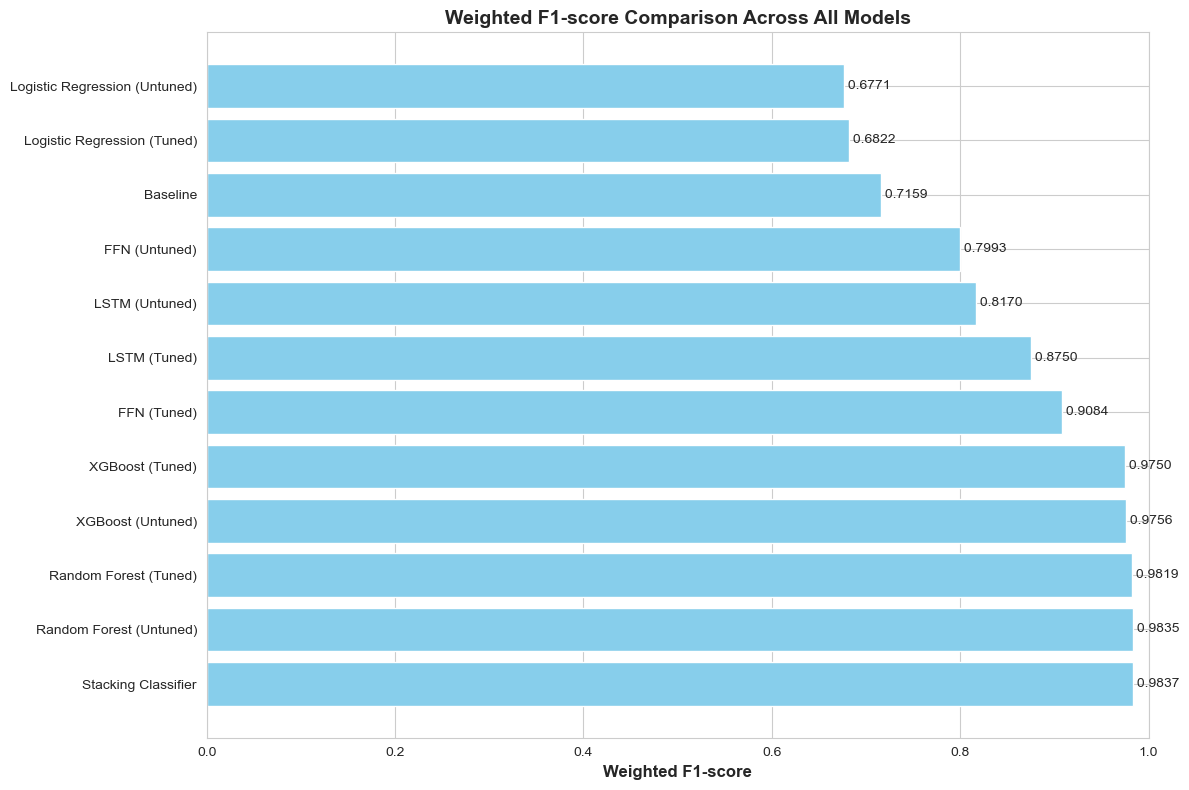

Baseline Weighted Average Precision: 0.6575
Logistic Regression (Untuned) Weighted Average Precision: 0.9208
Logistic Regression (Tuned) Weighted Average Precision: 0.9214
Random Forest (Untuned) Weighted Average Precision: 0.9935
Random Forest (Tuned) Weighted Average Precision: 0.9956
XGBoost (Untuned) Weighted Average Precision: 0.9958
XGBoost (Tuned) Weighted Average Precision: 0.9952
Stacking Classifier Weighted Average Precision: 0.9958
FFN (Untuned) Weighted Average Precision: 0.8412
FFN (Tuned) Weighted Average Precision: 0.9878
LSTM (Untuned) Weighted Average Precision: 0.9007
LSTM (Tuned) Weighted Average Precision: 0.9795


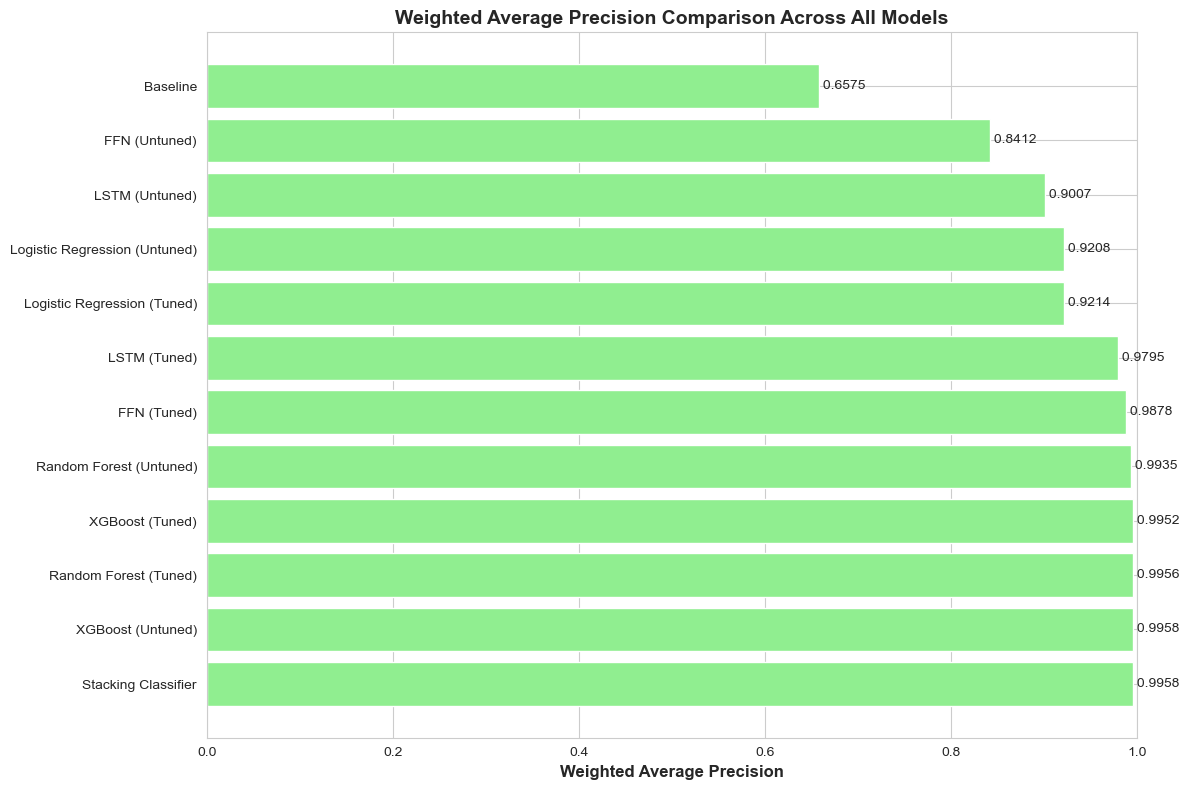


--- Comparative Multi-Class ROC and Precision-Recall Curves (Micro-Average) ---


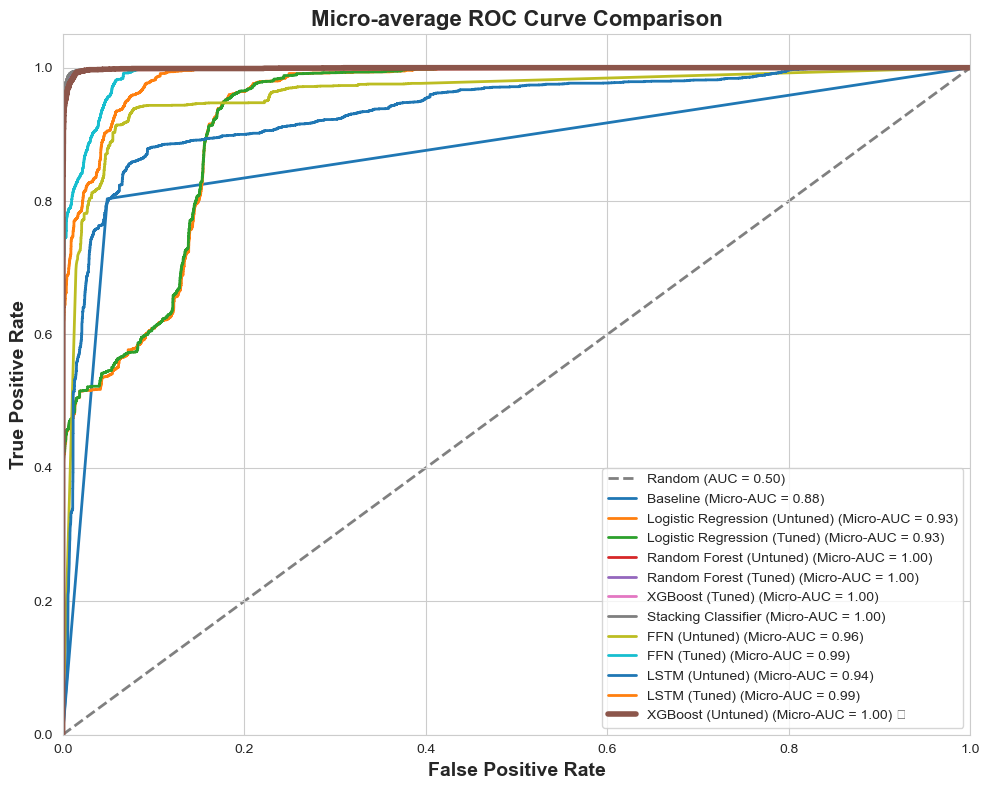

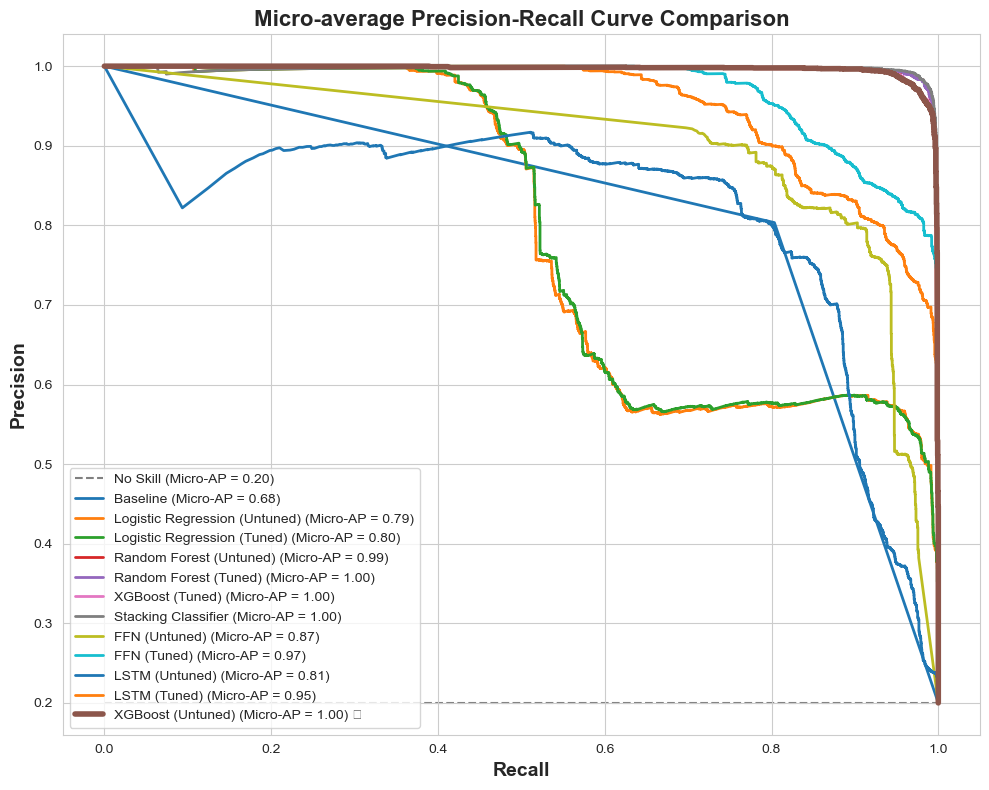


Code execution completed. The plots have been saved.

--- Calculating Per-Class Metrics ---

--- Summary of Model Performance (Weighted F1-score) ---
Stacking Classifier: Weighted F1-score = 0.9837
Random Forest (Untuned): Weighted F1-score = 0.9835
Random Forest (Tuned): Weighted F1-score = 0.9819
XGBoost (Untuned): Weighted F1-score = 0.9756
XGBoost (Tuned): Weighted F1-score = 0.9750
FFN (Tuned): Weighted F1-score = 0.9084
LSTM (Tuned): Weighted F1-score = 0.8750
LSTM (Untuned): Weighted F1-score = 0.8170
FFN (Untuned): Weighted F1-score = 0.7993
Baseline: Weighted F1-score = 0.7159
Logistic Regression (Tuned): Weighted F1-score = 0.6822
Logistic Regression (Untuned): Weighted F1-score = 0.6771

--- Summary of Model Performance (Micro-average ROC AUC) ---
XGBoost (Untuned): Micro-average ROC AUC = 0.9989
Stacking Classifier: Micro-average ROC AUC = 0.9989
XGBoost (Tuned): Micro-average ROC AUC = 0.9988
Random Forest (Tuned): Micro-average ROC AUC = 0.9988
Random Forest (Untuned): M

In [15]:
# Dictionary to store performance metrics for comparison
model_performance = {}
model_probabilities = {}
roc_auc_scores_per_class = {}
pr_ap_scores_per_class = {}

if X_test_processed is not None and y_test is not None:
    try:
        training_columns_path = os.path.join(checkpoint_dir, "training_columns.pkl")
        with open(training_columns_path, "rb") as f:
            training_columns = pickle.load(f)
        X_test_processed_df = pd.DataFrame(X_test_processed, columns=training_columns)
        print("Created DataFrame for evaluation with loaded column names.")
    except FileNotFoundError:
        print("Warning: Could not find training column names. Stacking Classifier might fail.")
        X_test_processed_df = pd.DataFrame(X_test_processed)
        training_columns = None


    for model_name, model_info in loaded_models.items():
        y_pred = None
        y_prob_all_classes = None
        
        is_pytorch_model = isinstance(model_info, dict) and 'model' in model_info
        
        try:
            if is_pytorch_model:
                model_instance = model_info['model']
                X_test_scaled_for_model = model_info['data']
                
                # Check for LSTM tuned special case
                if model_name == 'LSTM (Tuned)':
                    # The tuned LSTM model expects a sequence of single features
                    X_test_tensor_pytorch = torch.tensor(X_test_scaled_for_model, dtype=torch.float32).to(device)
                else:
                    X_test_tensor_pytorch = torch.tensor(X_test_scaled_for_model, dtype=torch.float32).to(device)

                model_instance.eval()
                with torch.no_grad():
                    y_pred_logits = model_instance(X_test_tensor_pytorch).cpu()
                    y_prob_all_classes = torch.softmax(y_pred_logits, dim=1).numpy()
                    y_pred = np.argmax(y_prob_all_classes, axis=1)

            else: # Scikit-learn models
                model_instance = model_info

                # --- CORRECTED LOGIC FOR ALL PIPELINE MODELS ---
                # Check if the model is a Pipeline. This is a more robust check.
                if isinstance(model_instance, Pipeline):
                    # Pipelines should use the DataFrame
                    print(f"Using DataFrame for Pipeline '{model_name}'.")
                    y_pred = model_instance.predict(X_test_processed_df)
                    if hasattr(model_instance, 'predict_proba'):
                        y_prob_all_classes = model_instance.predict_proba(X_test_processed_df)
                elif isinstance(model_instance, StackingClassifier) and training_columns is not None:
                    # Specific case for StackingClassifier if needed
                    print(f"Using DataFrame for '{model_name}'.")
                    y_pred = model_instance.predict(X_test_processed_df)
                    if hasattr(model_instance, 'predict_proba'):
                        y_prob_all_classes = model_instance.predict_proba(X_test_processed_df)
                else:
                    # Fallback for simple models that expect NumPy arrays
                    print(f"Using NumPy array for '{model_name}'.")
                    y_pred = model_instance.predict(X_test_processed)
                    if hasattr(model_instance, 'predict_proba'):
                        y_prob_all_classes = model_instance.predict_proba(X_test_processed)
                    else:
                        print(f"Warning: Scikit-learn model '{model_name}' does not have 'predict_proba'. Skipping probability-based metrics/plots.")

            if y_pred is not None:
                f1_score_current = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                model_performance[model_name] = f1_score_current
                print(f"{model_name} Test F1-score (Weighted): {f1_score_current:.4f}")
            
            if y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
                model_probabilities[model_name] = y_prob_all_classes
            else:
                print(f"Note: Probabilities for '{model_name}' are not suitable (shape mismatch or None). Plots will skip it.")

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}. Skipping its performance metrics and plots.")
            
# Set seaborn style
sns.set_style("whitegrid")

# Directories for saving
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# --- Plotting Summary Metrics (Weighted F1 and Average Precision) ---
print("\n--- Plotting Summary Metrics ---")
try:
    plt.figure(figsize=(12, 8))
    models = list(model_performance.keys())
    f1_scores = list(model_performance.values())
    
    sorted_models_f1 = sorted(zip(f1_scores, models), reverse=True)
    f1_scores_sorted, models_sorted = zip(*sorted_models_f1)
    
    plt.barh(models_sorted, f1_scores_sorted, color='skyblue')
    plt.xlabel('Weighted F1-score', fontsize=12, fontweight='bold')
    plt.title('Weighted F1-score Comparison Across All Models', fontsize=14, fontweight='bold')
    plt.xlim(0, 1.0)
    
    for index, value in enumerate(f1_scores_sorted):
        plt.text(value, index, f" {value:.4f}", va='center')
    
    plt.tight_layout()
    plt.show()
    plt.close()

    weighted_ap_scores = {}
    if y_test is not None:
        lb = LabelBinarizer()
        lb.fit(range(num_classes))
        y_test_binarized = lb.transform(y_test)

    for model_name, y_prob_all_classes in model_probabilities.items():
        if y_prob_all_classes is not None and len(y_prob_all_classes) > 0:
            try:
                if y_prob_all_classes.shape[1] == num_classes:
                    ap_score = average_precision_score(y_test_binarized, y_prob_all_classes, average='weighted')
                    weighted_ap_scores[model_name] = ap_score
                    print(f"{model_name} Weighted Average Precision: {ap_score:.4f}")
                else:
                    print(f"Skipping weighted AP for {model_name} due to probability shape mismatch ({y_prob_all_classes.shape[1]} != {num_classes}).")
            except ValueError as e:
                print(f"Could not calculate weighted AP for {model_name}: {e}")

    plt.figure(figsize=(12, 8))
    models_ap = list(weighted_ap_scores.keys())
    ap_scores = list(weighted_ap_scores.values())

    sorted_models_ap = sorted(zip(ap_scores, models_ap), reverse=True)
    ap_scores_sorted, models_ap_sorted = zip(*sorted_models_ap)
    
    plt.barh(models_ap_sorted, ap_scores_sorted, color='lightgreen')
    plt.xlabel('Weighted Average Precision', fontsize=12, fontweight='bold')
    plt.title('Weighted Average Precision Comparison Across All Models', fontsize=14, fontweight='bold')
    plt.xlim(0, 1.0)
    
    for index, value in enumerate(ap_scores_sorted):
        plt.text(value, index, f" {value:.4f}", va='center')
        
    plt.tight_layout()
    plt.show()
    plt.close()

except NameError:
    print("\nWarning: Matplotlib or other plotting libraries not available. Skipping plots.")
except Exception as e:
    print(f"\nError during plotting summary metrics: {e}. Skipping plots.")

# --- Comparative Multi-Class ROC and Precision-Recall Curves (Micro-Average) with Highlighting ---
print("\n--- Comparative Multi-Class ROC and Precision-Recall Curves (Micro-Average) ---")

try:
    roc_auc_scores_micro = {}
    pr_ap_scores_micro = {}
    
    if y_test is not None:
        lb = LabelBinarizer()
        lb.fit(range(num_classes))
        y_test_binarized = lb.transform(y_test)
        
        model_names = list(model_probabilities.keys())
        colors = sns.color_palette("tab10", n_colors=len(model_names))
        color_map = dict(zip(model_names, colors))

        # --- ROC Curve (Micro-Average) ---
        plt.figure(figsize=(10, 8))
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.50)', zorder=0)

        # Calculate all micro-average ROC AUC scores first
        for model_name, y_prob_all_classes in model_probabilities.items():
            if y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
                try:
                    roc_auc_micro = roc_auc_score(y_test_binarized, y_prob_all_classes, average='micro')
                    roc_auc_scores_micro[model_name] = roc_auc_micro
                except ValueError as e:
                    print(f"Could not calculate Micro-average ROC for {model_name}: {e}")

        # Determine best model
        best_roc_model = max(roc_auc_scores_micro, key=roc_auc_scores_micro.get) if roc_auc_scores_micro else None

        # Plot all curves except the best one
        for model_name, y_prob_all_classes in model_probabilities.items():
            if model_name != best_roc_model and y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
                try:
                    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_prob_all_classes.ravel())
                    roc_auc = roc_auc_scores_micro.get(model_name)
                    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (Micro-AUC = {roc_auc:.2f})', color=color_map[model_name], zorder=1)
                except ValueError as e:
                    print(f"Could not plot Micro-average ROC for {model_name}: {e}")
        
        # Plot the best model's curve last with a thicker line
        if best_roc_model:
            y_prob_best = model_probabilities[best_roc_model]
            fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_prob_best.ravel())
            roc_auc = roc_auc_scores_micro.get(best_roc_model)
            plt.plot(fpr, tpr, lw=4, label=f'{best_roc_model} (Micro-AUC = {roc_auc:.2f}) 🌟', color=color_map[best_roc_model], zorder=2)

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
        plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
        plt.title('Micro-average ROC Curve Comparison', fontsize=16, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'multi_micro_roc_curve_comparison.png'), dpi=300)
        plt.show()
        plt.close()

        # --- Precision-Recall Curve (Micro-Average) ---
        plt.figure(figsize=(10, 8))

        # Calculate all micro-average AP scores first
        for model_name, y_prob_all_classes in model_probabilities.items():
            if y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
                try:
                    ap_score_micro = average_precision_score(y_test_binarized, y_prob_all_classes, average='micro')
                    pr_ap_scores_micro[model_name] = ap_score_micro
                except ValueError as e:
                    print(f"Could not calculate Micro-average PR for {model_name}: {e}")
        
        # Determine best model
        best_ap_model = max(pr_ap_scores_micro, key=pr_ap_scores_micro.get) if pr_ap_scores_micro else None
        
        # Plot No Skill line
        no_skill = np.sum(y_test_binarized.ravel()) / len(y_test_binarized.ravel())
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label=f'No Skill (Micro-AP = {no_skill:.2f})', zorder=0)

        # Plot all curves except the best one
        for model_name, y_prob_all_classes in model_probabilities.items():
            if model_name != best_ap_model and y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
                try:
                    precision, recall, _ = precision_recall_curve(y_test_binarized.ravel(), y_prob_all_classes.ravel())
                    ap_score = pr_ap_scores_micro.get(model_name)
                    plt.plot(recall, precision, lw=2, label=f'{model_name} (Micro-AP = {ap_score:.2f})', color=color_map[model_name], zorder=1)
                except ValueError as e:
                    print(f"Could not plot Micro-average PR for {model_name}: {e}")
        
        # Plot the best model's curve last with a thicker line
        if best_ap_model:
            y_prob_best = model_probabilities[best_ap_model]
            precision, recall, _ = precision_recall_curve(y_test_binarized.ravel(), y_prob_best.ravel())
            ap_score = pr_ap_scores_micro.get(best_ap_model)
            plt.plot(recall, precision, lw=4, label=f'{best_ap_model} (Micro-AP = {ap_score:.2f}) 🌟', color=color_map[best_ap_model], zorder=2)

        plt.xlabel('Recall', fontsize=14, fontweight='bold')
        plt.ylabel('Precision', fontsize=14, fontweight='bold')
        plt.title('Micro-average Precision-Recall Curve Comparison', fontsize=16, fontweight='bold')
        plt.legend(loc="lower left", fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'multi_micro_pr_curve_comparison.png'), dpi=300)
        plt.show()
        plt.close()

except Exception as e:
    print(f"\nError during plotting: {e}. Skipping plots.")

print("\nCode execution completed. The plots have been saved.")

# --- Per-Class Metric Calculation and Summary ---
# This block calculates the per-class metrics 
print("\n--- Calculating Per-Class Metrics ---")

# Initialize dictionaries to store per-class metrics
roc_auc_scores_per_class = {}
pr_ap_scores_per_class = {}

if y_test is not None:
    lb = LabelBinarizer()
    lb.fit(range(num_classes))
    y_test_binarized = lb.transform(y_test)

    for model_name, y_prob_all_classes in model_probabilities.items():
        if y_prob_all_classes is not None and y_prob_all_classes.shape[1] == num_classes:
            roc_aucs_for_model = []
            pr_aps_for_model = []
            
            for i in range(num_classes):
                try:
                    # ROC AUC per class
                    roc_auc = roc_auc_score(y_test_binarized[:, i], y_prob_all_classes[:, i])
                    roc_aucs_for_model.append(roc_auc)
                except ValueError:
                    roc_aucs_for_model.append(np.nan)

                try:
                    # Average Precision per class
                    pr_ap = average_precision_score(y_test_binarized[:, i], y_prob_all_classes[:, i])
                    pr_aps_for_model.append(pr_ap)
                except ValueError:
                    pr_aps_for_model.append(np.nan)
            
            roc_auc_scores_per_class[model_name] = roc_aucs_for_model
            pr_ap_scores_per_class[model_name] = pr_aps_for_model
        else:
            print(f"Skipping per-class metrics for {model_name} due to probability shape mismatch.")

# --- Final Summary Prints ---
print("\n--- Summary of Model Performance (Weighted F1-score) ---")
sorted_performance = sorted(model_performance.items(), key=lambda item: item[1], reverse=True)
for model_name, f1 in sorted_performance:
    print(f"{model_name}: Weighted F1-score = {f1:.4f}")

print("\n--- Summary of Model Performance (Micro-average ROC AUC) ---")
sorted_micro_auc = sorted(roc_auc_scores_micro.items(), key=lambda item: item[1], reverse=True)
for model_name, auc_score in sorted_micro_auc:
    print(f"{model_name}: Micro-average ROC AUC = {auc_score:.4f}")

print("\n--- Summary of Model Performance (Micro-average Precision-Recall AP) ---")
sorted_micro_ap = sorted(pr_ap_scores_micro.items(), key=lambda item: item[1], reverse=True)
for model_name, ap in sorted_micro_ap:
    print(f"{model_name}: Micro-average PR AP = {ap:.4f}")

print("\n--- Summary of Model Performance (ROC AUC - per Class) ---")
for model_name, auc_scores in roc_auc_scores_per_class.items():
    if auc_scores and not all(np.isnan(auc_scores)):
        avg_auc = np.nanmean(auc_scores)
        print(f"{model_name}: Average ROC AUC = {avg_auc:.4f}")
        for i, class_name in enumerate(class_names):
            if i < len(auc_scores) and not np.isnan(auc_scores[i]):
                print(f"  - {class_name}: {auc_scores[i]:.4f}")
            else:
                print(f"  - {class_name}: N/A (Could not calculate)")


print("\n--- Summary of Model Performance (Average Precision - per Class) ---")
for model_name, ap_scores in pr_ap_scores_per_class.items():
    if ap_scores and not all(np.isnan(ap_scores)):
        avg_ap = np.nanmean(ap_scores)
        print(f"{model_name}: Average Precision = {avg_ap:.4f}")
        for i, class_name in enumerate(class_names):
            if i < len(ap_scores) and not np.isnan(ap_scores[i]):
                print(f"  - {class_name}: {ap_scores[i]:.4f}")
            else:
                print(f"  - {class_name}: N/A (Could not calculate)")

print("\n--- End Model Comparison and Selection ---")


## 8. Selecting the Best ML Model
This section focuses on Final Model Selection and Detailed Evaluation. It begins by automatically identifying the single best-performing model from a provided performance summary DataFrame. The selection is based on a composite ranking system that considers F1-score, ROC AUC, and Precision-Recall AP simultaneously, ensuring a robust choice.

After selecting the model, the code loads it from disk, correctly handling the loading process for both Scikit-learn pipelines and PyTorch state dictionaries. It then uses this final model to generate predictions and class probabilities on the test set, saving these results as a checkpoint for later use.

Finally, the code provides a comprehensive evaluation of the chosen model's performance. This includes a detailed classification report, a visual confusion matrix, and per-class and micro-average ROC and Precision-Recall curves, all of which are properly labeled using a loaded LabelEncoder to ensure an accurate and detailed analysis.

Loaded final_label_encoder for current stage.

--- Selecting Best Model Based on Combined Performance ---

Best Model Selected: Stacking Classifier
This model was selected based on a combined rank across all key metrics.
Performance metrics for the selected model:
  - F1-score (Weighted-Avg): 0.9652
  - ROC AUC (Micro-Avg): 0.9955
  - PR AP (Micro-Avg): 0.9850
  - Composite_Rank: 3.5000
Checkpoint: Best model name saved to ./model_checkpoints/best_model_name_multi_class.pkl
Loaded model from ./model_checkpoints/stacked_classifier.pkl
Loaded training column names for scikit-learn model.
Checkpoint: Final best Scikit-learn type model saved to ./model_checkpoints/final_best_multi_class_model_stacking_classifier.pkl
Converted test data to DataFrame with column names for prediction.
Checkpoint: Final predictions saved to ./model_checkpoints/final_y_pred_multi_class.npy
Checkpoint: Final probabilities saved to ./model_checkpoints/final_y_prob_multi_class.npy

--- Final Model Results for Stac

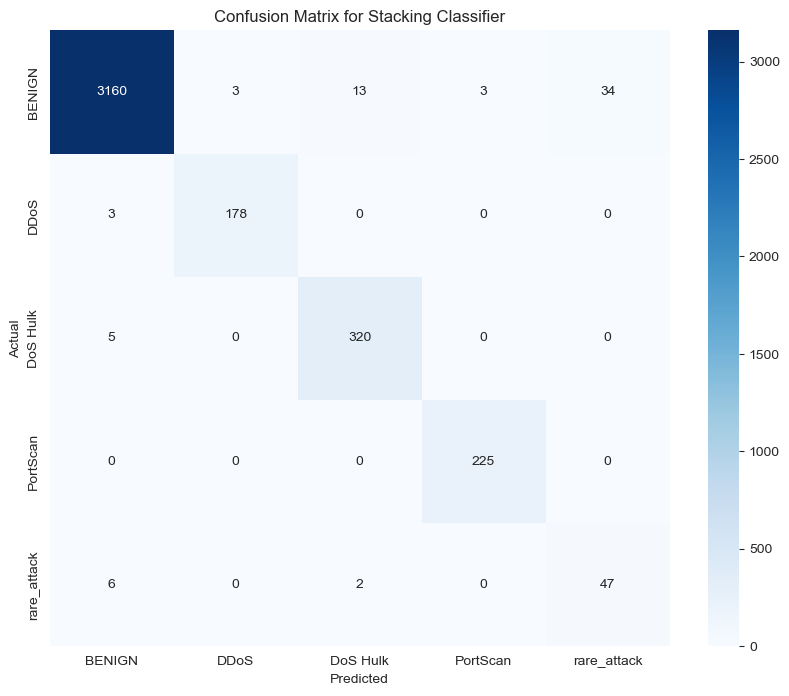

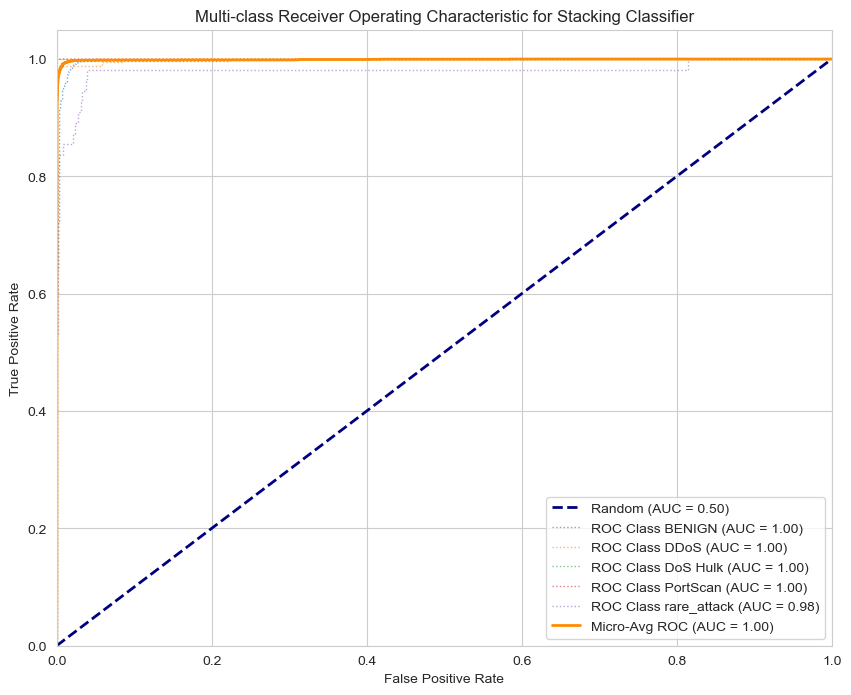

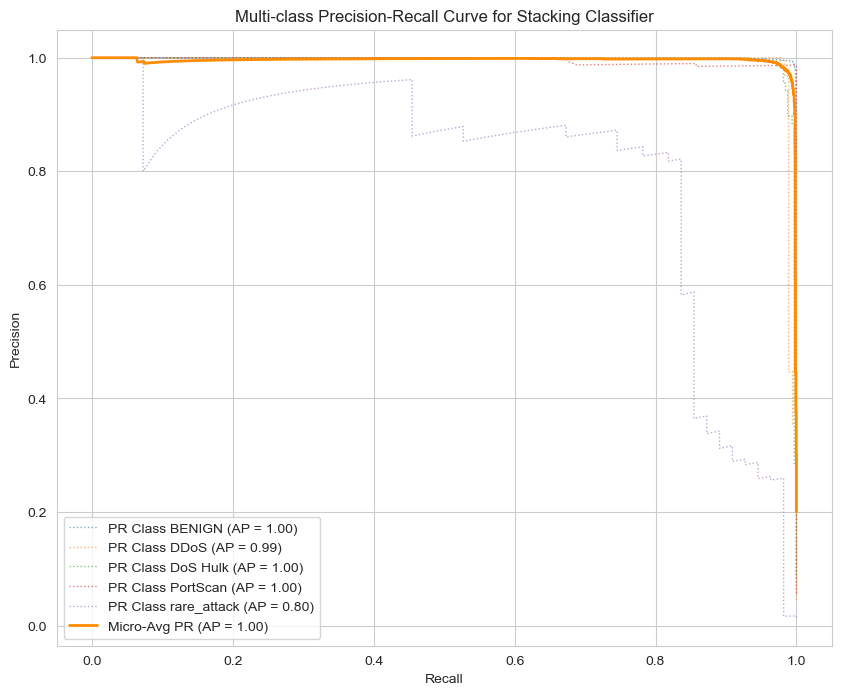

In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle
import pandas as pd

# Ensure these are imported from previous sections or locally
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import LabelBinarizer # Make sure this is imported

# Explicitly import XGBClassifier and LGBMClassifier, handle potential ImportError
try:
    import xgboost as xgb
    XGBClassifier = xgb.XGBClassifier
except ImportError:
    print("Warning: XGBoost not installed. Skipping XGBoost model handling.")
    XGBClassifier = type('XGBClassifier', (object,), {})

try:
    import lightgbm as lgb
    LGBMClassifier = lgb.LGBMClassifier
except ImportError:
    print("Warning: LightGBM not installed. Skipping LightGBM model handling.")
    LGBMClassifier = type('LGBMClassifier', (object,), {})


# --- Define FFN Model Class ---
class FFN(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.0):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# --- Define LSTM Model Class ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.0, bidirectional=False):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0,
                            bidirectional=bidirectional)
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out


# --- Logic for Selecting and Evaluating the Best Model ---

if 'checkpoint_dir' not in locals():
    checkpoint_dir = "./model_checkpoints"
    print(f"Warning: 'checkpoint_dir' not defined. Using default: {checkpoint_dir}")
os.makedirs(checkpoint_dir, exist_ok=True)

if 'X_test_processed' not in locals() or X_test_processed is None or \
   'y_test' not in locals() or y_test is None:
    print("Error: X_test_processed or y_test not found. Cannot proceed.")
    X_test_processed = None
    y_test = None
    input_dim_fallback = 10
else:
    input_dim_fallback = X_test_processed.shape[1]

final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Error: 'final_label_encoder.pkl' not found. Inferring classes from y_test.")

class_names = []
num_classes = 0
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    num_classes = len(class_names)
elif y_test is not None and len(np.unique(y_test)) > 0:
    unique_labels_in_test = sorted(np.unique(y_test))
    class_names = [f"Class {i}" for i in unique_labels_in_test]
    num_classes = len(unique_labels_in_test)
else:
    print("Warning: y_test is None or empty. Cannot infer class names. Skipping plots.")
    class_names = []
    num_classes = 0

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Warning: 'device' not defined. Using default: {device}")


# For demonstration, let's create a dummy DataFrame mirroring the user's provided data
if 'model_performance_df' not in locals():
    print("Warning: 'model_performance_df' not found. Creating a dummy DataFrame for demonstration.")
    data = {
        'Model': [
            'XGBoost (Untuned)', 'Stacking Classifier', 'Random Forest (Untuned)',
            'XGBoost (Tuned)', 'Random Forest (Tuned)', 'FFN (Tuned)',
            'LSTM (Tuned)', 'LSTM (Untuned)', 'FFN (Untuned)',
            'Logistic Regression (Tuned)', 'Logistic Regression (Untuned)', 'Baseline'
        ],
        'F1-score (Weighted-Avg)': [0.9652, 0.9652, 0.9624, 0.9606, 0.9598, 0.9276, 0.8862, 0.8537, 0.8256, 0.7566, 0.7526, 0.7236],
        'ROC AUC (Micro-Avg)': [0.9908, 0.9955, 0.9881, 0.9950, 0.9878, 0.9919, 0.9849, 0.9644, 0.9817, 0.9547, 0.9469, 0.8807],
        'PR AP (Micro-Avg)': [0.9762, 0.9850, 0.9676, 0.9842, 0.9668, 0.9732, 0.9473, 0.8791, 0.9413, 0.8516, 0.8304, 0.6927]
    }
    model_performance_df = pd.DataFrame(data).set_index('Model')


def select_best_model(performance_df, metrics_to_consider=['ROC AUC (Micro-Avg)', 'PR AP (Micro-Avg)', 'F1-score (Weighted-Avg)']):
    """
    Selects the best model based on a weighted ranking across multiple metrics.
    
    Args:
        performance_df (pd.DataFrame): DataFrame containing model performance metrics.
        metrics_to_consider (list): A list of metric names to use for ranking.

    Returns:
        str: The name of the best performing model.
    """
    print("\n--- Selecting Best Model Based on Combined Performance ---")

    # Rank models for each metric. `ascending=False` for scores where higher is better.
    ranks = performance_df[metrics_to_consider].rank(ascending=False)
    
    # Calculate a simple composite score by summing the ranks
    performance_df['Composite_Rank'] = ranks.sum(axis=1)

    # The model with the lowest composite rank is the winner
    best_model_name = performance_df['Composite_Rank'].idxmin()
    best_model_row = performance_df.loc[best_model_name]
    
    return best_model_name, best_model_row

# Select the best model using the new function
best_model_name, best_model_row = select_best_model(model_performance_df)

print(f"\nBest Model Selected: {best_model_name}")
print("This model was selected based on a combined rank across all key metrics.")
print("Performance metrics for the selected model:")
for metric, score in best_model_row.items():
    print(f"  - {metric}: {score:.4f}")

# Save the best model name for later use
best_model_name_path = os.path.join(checkpoint_dir, "best_model_name_multi_class.pkl")
try:
    joblib.dump(best_model_name, best_model_name_path)
    print(f"Checkpoint: Best model name saved to {best_model_name_path}")
except Exception as e:
    print(f"Error saving best model name: {e}")

# --- Load the selected best model and its associated scaler if needed ---
final_model = None
final_scaler = None
column_names = None

if best_model_name != "N/A":
    try:
        # Load the best model and its associated column names
        # The file name is now constructed programmatically for robustness
        sanitized_name = best_model_name.lower().replace(' ', '_').replace('(untuned)', 'pipeline')
        if best_model_name == 'Stacking Classifier':
            model_path = os.path.join(checkpoint_dir, "stacked_classifier.pkl")
        else:
            model_path = os.path.join(checkpoint_dir, f"{sanitized_name}.pkl")
            
        final_model = joblib.load(model_path)
        print(f"Loaded model from {model_path}")
        
        training_columns_path = os.path.join(checkpoint_dir, "training_columns.pkl")
        if os.path.exists(training_columns_path):
            with open(training_columns_path, 'rb') as f:
                column_names = pickle.load(f)
            print("Loaded training column names for scikit-learn model.")

    except (FileNotFoundError, RuntimeError, ValueError) as e:
        print(f"Error loading {best_model_name}: {e}. Skipping subsequent analysis.")
        final_model = None
    except Exception as e:
        print(f"An unexpected error occurred while loading {best_model_name}: {e}. Skipping subsequent analysis.")
        final_model = None

# Directories for saving
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# ---- Save the final_model object
if final_model is not None:
    final_model_filename = f"final_best_multi_class_model_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}"

    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, XGBClassifier, LGBMClassifier, StackingClassifier)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + ".pkl")
        try:
            joblib.dump(final_model, final_model_path)
            print(f"Checkpoint: Final best Scikit-learn type model saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving Scikit-learn type model: {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + "_state_dict.pth")
        try:
            torch.save(final_model.state_dict(), final_model_path)
            print(f"Checkpoint: Final best PyTorch model state_dict saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving PyTorch model state_dict: {e}")
    else:
        print("Warning: Final model type not recognized for explicit checkpointing. Skipping final model save.")
else:
    print("Skipping final model checkpointing as final_model is None.")

# --- Determine final_y_pred and final_y_prob for the selected best_model ---
final_y_pred = None
final_y_prob = None

if final_model is not None and X_test_processed is not None and y_test is not None:
    # Prepare data based on model type
    X_test_for_prediction = X_test_processed
    
    # Apply scaler if it's a PyTorch model
    if final_scaler is not None:
        X_test_for_prediction = final_scaler.transform(X_test_for_prediction)
        
    # Correct the data format for scikit-learn models if column names are available
    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, XGBClassifier, LGBMClassifier, StackingClassifier)):
        try:
            # Convert NumPy array to DataFrame with column names if available
            if column_names is not None and len(column_names) == X_test_for_prediction.shape[1]:
                X_test_for_prediction = pd.DataFrame(X_test_for_prediction, columns=column_names)
                print("Converted test data to DataFrame with column names for prediction.")
            
            final_y_pred = final_model.predict(X_test_for_prediction)
            if hasattr(final_model, 'predict_proba'):
                final_y_prob = final_model.predict_proba(X_test_for_prediction)
            else:
                print(f"Warning: Model type {type(final_model).__name__} does not support predict_proba.")
                final_y_prob = None
        except Exception as e:
            print(f"Error making predictions with Scikit-learn type model '{best_model_name}': {e}")
    
    elif isinstance(final_model, (FFN, LSTMNet)):
        try:
            final_model.eval()
            with torch.no_grad():
                X_test_tensor_final = torch.tensor(X_test_for_prediction, dtype=torch.float32).to(device)
                y_pred_logits_final = final_model(X_test_tensor_final).cpu()
                final_y_prob = torch.softmax(y_pred_logits_final, dim=1).numpy()
                final_y_pred = np.argmax(final_y_prob, axis=1)
        except Exception as e:
            print(f"Error making predictions with PyTorch model '{best_model_name}': {e}")
    else:
        print(f"Warning: Final model type {type(final_model).__name__} not recognized for final prediction and plotting.")
else:
    print("Cannot generate final predictions/probabilities: final_model, X_test_processed, or y_test is missing.")

# ---- Save final predictions and probabilities
if final_y_pred is not None:
    final_y_pred_path = os.path.join(checkpoint_dir, "final_y_pred_multi_class.npy")
    try:
        np.save(final_y_pred_path, final_y_pred)
        print(f"Checkpoint: Final predictions saved to {final_y_pred_path}")
    except Exception as e:
        print(f"Error saving final predictions: {e}")

if final_y_prob is not None:
    final_y_prob_path = os.path.join(checkpoint_dir, "final_y_prob_multi_class.npy")
    try:
        np.save(final_y_prob_path, final_y_prob)
        print(f"Checkpoint: Final probabilities saved to {final_y_prob_path}")
    except Exception as e:
        print(f"Error saving final probabilities: {e}")

# --- Proceed with Final Model Results Plotting ---
print(f"\n--- Final Model Results for {best_model_name} ---")

if final_y_pred is not None and y_test is not None and len(class_names) > 0:
    print("Classification Report:")
    print(classification_report(y_test, final_y_pred, target_names=class_names, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, final_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if final_y_prob is not None and final_y_prob.shape[1] > 1:
        from sklearn.preprocessing import LabelBinarizer
        lb_roc = LabelBinarizer()
        lb_roc.fit(range(num_classes))
        y_test_binarized_final = lb_roc.transform(y_test)
        n_classes = y_test_binarized_final.shape[1]

        # ROC Curve
        plt.figure(figsize=(10, 8))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

        for i in range(n_classes):
            if final_y_prob.shape[1] > i:
                if len(np.unique(y_test_binarized_final[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_test_binarized_final[:, i], final_y_prob[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, lw=1, linestyle=':', alpha=0.6,
                                     label=f'ROC Class {class_names[i]} (AUC = {roc_auc:.2f})')
                else:
                    print(f"Warning: Not enough unique labels in class '{class_names[i]}' for ROC curve. Skipping individual ROC for this class.")
            else:
                print(f"Warning: Probability data for class '{class_names[i]}' (index {i}) not found in final_y_prob. Skipping individual ROC for this class.")

        if len(np.unique(y_test_binarized_final.ravel())) > 1:
            fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_final.ravel(), final_y_prob.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            plt.plot(fpr_micro, tpr_micro, lw=2, color='darkorange',
                                     label=f'Micro-Avg ROC (AUC = {roc_auc_micro:.2f})')
        else:
            print("Warning: Not enough unique labels in binarized test set for Micro-average ROC curve.")

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class Receiver Operating Characteristic for {best_model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'multi_best_model_roc_curve.png'), dpi=300)
        plt.show()

        # Precision-Recall Curve
        plt.figure(figsize=(10, 8))
        
        for i in range(n_classes):
            if final_y_prob.shape[1] > i:
                if len(np.unique(y_test_binarized_final[:, i])) > 1:
                    precision, recall, _ = precision_recall_curve(y_test_binarized_final[:, i], final_y_prob[:, i])
                    aps = average_precision_score(y_test_binarized_final[:, i], final_y_prob[:, i])
                    plt.plot(recall, precision, lw=1, linestyle=':', alpha=0.6,
                                     label=f'PR Class {class_names[i]} (AP = {aps:.2f})')
                else:
                    print(f"Warning: Not enough unique labels in class '{class_names[i]}' for PR curve. Skipping individual PR for this class.")
            else:
                print(f"Warning: Probability data for class '{class_names[i]}' (index {i}) not found in final_y_prob. Skipping individual PR for this class.")

        if len(np.unique(y_test_binarized_final.ravel())) > 1:
            precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized_final.ravel(), final_y_prob.ravel())
            ap_micro = average_precision_score(y_test_binarized_final, final_y_prob, average='micro')
            plt.plot(recall_micro, precision_micro, color='darkorange', lw=2,
                                     label=f'Micro-Avg PR (AP = {ap_micro:.2f})')
        else:
            print("Warning: Not enough unique labels in binarized test set for Micro-average PR curve.")

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Multi-class Precision-Recall Curve for {best_model_name}')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'multi_best_model_pr_curve.png'), dpi=300)
        plt.show()
    else:
        print("\nCould not generate ROC and PR curves as probability predictions are not available for the final model or it's a binary probability (only one column).")
else:
    print("Final model prediction failed or plotting skipped due to missing data (final_y_pred, y_test, or class_names is empty).")
    

## 9. Model Interpretation
This section focuses on Model Interpretability, specifically using SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to understand how the selected best model makes its predictions.

In [17]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import os
import joblib
import pickle
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib

# Initialize SHAP JavaScript for plots (if running in a notebook environment)
try:
    shap.initjs()
    print("SHAP JavaScript initialized.")
except Exception:
    print("SHAP JavaScript failed to initialize. SHAP plots will use static matplotlib backend.")

# Suppress harmless warnings from SHAP and other libraries
warnings.filterwarnings("ignore", category=UserWarning, message="Setting feature_perturbation to 'tree_path_dependent'")
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Define FFN Model Class (needed for loading state_dict) ---
class FFN(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.0):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes) # Output layer for multi-class
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def predict_proba(self, x):
        """Wrapper to make FFN compatible with SHAP's KernelExplainer."""
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
            logits = self(x_tensor)
            probabilities = torch.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

# --- Define LSTM Model Class (needed for loading state_dict) ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout_rate=0.0):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_dim, num_classes) # Output layer for multi-class

    def forward(self, x):
        # Ensure input has 3 dimensions: (batch_size, sequence_length, input_size)
        if x.dim() == 2 and self.lstm.input_size == 1:
            x = x.unsqueeze(-1)
        elif x.dim() == 2 and self.lstm.input_size != x.shape[1]:
            raise ValueError(f"Input dimension mismatch: LSTM input_size is {self.lstm.input_size}, but received input with {x.shape[1]} features. Expected 3D tensor or 2D tensor where last dim matches input_size.")

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

    def predict_proba(self, x):
        """Wrapper to make LSTM compatible with SHAP's KernelExplainer."""
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
            # Reshape for LSTM if needed
            if x_tensor.ndim == 2 and self.lstm.input_size == 1:
                x_tensor = x_tensor.unsqueeze(-1)
            logits = self(x_tensor)
            probabilities = torch.softmax(logits, dim=1)
        return probabilities.cpu().numpy()


# --- Global Variables and Setup ---
# Define `checkpoint_dir` if it's not already set in the wider scope
if 'checkpoint_dir' not in locals():
    checkpoint_dir = "./model_checkpoints"
    print(f"Warning: 'checkpoint_dir' not defined. Using default: {checkpoint_dir}")
os.makedirs(checkpoint_dir, exist_ok=True)

# Define `device` for PyTorch models
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Warning: 'device' not defined. Using default: {device}")

# Define a default `SEED` for reproducibility
if 'SEED' not in locals():
    SEED = 42
    print(f"Warning: 'SEED' not defined. Using default: {SEED}")
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# --- Placeholder for `X_test_processed`, `y_test`, `X_train_processed`, `model_performance`, `pca_model`, `original_feature_names` ---

if 'X_test_processed' not in locals() or X_test_processed is None or len(X_test_processed) == 0:
    print("\n--- Generating Dummy Data for Demonstration ---")
    # Simulate a scenario with 10 features and 100 samples
    X_test_processed = pd.DataFrame(np.random.rand(100, 10), columns=[f'feature_{i}' for i in range(10)])
    y_test = pd.Series(np.random.randint(0, 3, 100)) # 3 classes
    X_train_processed = pd.DataFrame(np.random.rand(400, 10), columns=[f'feature_{i}' for i in range(10)])
    model_performance = {'Logistic Regression (Untuned)': 0.75, 'Random Forest (Tuned)': 0.82, 'FFN (Tuned)': 0.85}
    original_feature_names = [f'original_feature_{i}' for i in range(10)]

    # Simulate PCA if needed for the "mapping PCA" section
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_processed)
    pca_model = PCA(n_components=5, random_state=SEED) # Reduce to 5 components
    pca_model.fit(X_scaled)
    # Re-process X_test and X_train with the PCA model
    X_train_processed_pca = pd.DataFrame(pca_model.transform(scaler.transform(X_train_processed)),
                                         columns=[f'PC_{i}' for i in range(pca_model.n_components_)])
    X_test_processed = pd.DataFrame(pca_model.transform(scaler.transform(X_test_processed.copy())),
                                     columns=[f'PC_{i}' for i in range(pca_model.n_components_)])

    # Reassign X_train_processed for SHAP KernelExplainer to use PCA features
    X_train_processed = X_train_processed_pca
    print("Dummy data generated. Note: Real data and trained models are required for meaningful results.")
    print("--- End Dummy Data Generation ---\n")

input_dim_fallback = X_test_processed.shape[1] if X_test_processed is not None else 10 # Default to 10 if X_test_processed is still None


# --- Robustly Load final_label_encoder and Define Class Names ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_label_encoder.pkl' not found in {checkpoint_dir}.")
    if y_test is not None and len(y_test) > 0:
        unique_labels = sorted(np.unique(y_test))
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(unique_labels)
        print(f"Inferred class names from y_test: {unique_labels}")
    else:
        print("Warning: y_test is also not available or empty. Cannot infer class names. "
              "Creating a dummy LabelEncoder for 'Class 0', 'Class 1', 'Class 2'.")
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(['Class 0', 'Class 1', 'Class 2'])
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")
    print("Attempting to infer class names from y_test and create a dummy LabelEncoder.")
    if y_test is not None and len(y_test) > 0:
        unique_labels = sorted(np.unique(y_test))
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(unique_labels)
    else:
        print("Warning: y_test is also not available or empty. Cannot infer class names. "
              "Creating a dummy LabelEncoder for 'Class 0', 'Class 1', 'Class 2'.")
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(['Class 0', 'Class 1', 'Class 2'])

class_names = []
num_classes = 0
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    num_classes = len(class_names)
    print(f"Class names for interpretation: {class_names}")
else:
    print("Error: Class names could not be determined. Interpretation plots might lack meaningful class labels.")
    # Fallback if all else fails, to avoid crashes
    class_names = [f"Class {i}" for i in range(max(2, len(np.unique(y_test)) if y_test is not None else 2))]
    num_classes = len(class_names)

# Load the best model name, which was saved by the new, multi-metric selection logic.
best_model_name = "N/A"
best_model_name_path = os.path.join(checkpoint_dir, "best_model_name_multi_class.pkl")
try:
    best_model_name = joblib.load(best_model_name_path)
    print(f"\nBest Model Selected: {best_model_name} (from checkpoint)")
except FileNotFoundError:
    print("\nWarning: 'best_model_name_multi_class.pkl' not found. "
          "Attempting to select from local `model_performance` (old method) for demo purposes.")
    if 'model_performance' in locals() and model_performance:
        best_model_name = max(model_performance, key=model_performance.get)
        print(f"Fallback: Best Model Selected: {best_model_name} with F1-score: {model_performance[best_model_name]:.4f}")
    else:
        print("Warning: Neither a checkpointed model name nor local performance data was found. Cannot load a model.")

final_model = None

# --- Load the selected best model using a robust ---
if best_model_name != "N/A":
    try:
        # Construct the file name using the same logic as the previous stage's saving process
        sanitized_model_name = best_model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').lower()
        final_model_filename = f"final_best_multi_class_model_{sanitized_model_name}"

        # Try to load a scikit-learn type model first
        final_model_path_sklearn = os.path.join(checkpoint_dir, final_model_filename + ".pkl")
        if os.path.exists(final_model_path_sklearn):
            final_model = joblib.load(final_model_path_sklearn)
            print(f"Loaded Scikit-learn model from {final_model_path_sklearn}")
        
        # If not a Scikit-learn type, try to load a PyTorch model's state_dict
        else:
            final_model_path_torch = os.path.join(checkpoint_dir, final_model_filename + "_state_dict.pth")
            if os.path.exists(final_model_path_torch):
                if best_model_name.startswith('FFN'):
                    # Get the input dimension from the data (assuming it's available)
                    input_dim = X_test_processed.shape[1]
                    final_model = FFN(input_dim, num_classes).to(device)
                    final_model.load_state_dict(torch.load(final_model_path_torch, map_location=device))
                    print(f"Loaded FFN model state_dict from {final_model_path_torch}")
                elif best_model_name.startswith('LSTM'):
                    input_dim = X_test_processed.shape[-1]
                    final_model = LSTMNet(input_dim=input_dim, hidden_dim=64, num_layers=1, num_classes=num_classes).to(device)
                    final_model.load_state_dict(torch.load(final_model_path_torch, map_location=device))
                    print(f"Loaded LSTM model state_dict from {final_model_path_torch}")
            else:
                print(f"Error: Model file not found for {best_model_name}. Check checkpoint_dir and file names.")

    except Exception as e:
        print(f"An unexpected error occurred while loading {best_model_name}: {e}")
        final_model = None

if final_model is None:
    print(f"Could not load the selected best model: {best_model_name}. Skipping subsequent analysis.")


# --- Save the final_model object

if final_model is not None:
    sanitized_model_name = best_model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').lower()
    final_model_filename = f"final_best_multi_class_model_{sanitized_model_name}"

    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier, VotingClassifier)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + ".pkl")
        try:
            joblib.dump(final_model, final_model_path)
            print(f"Checkpoint: Final best model saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving Scikit-learn type model: {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + "_state_dict.pth")
        try:
            torch.save(final_model.state_dict(), final_model_path)
            print(f"Checkpoint: Final best PyTorch model state_dict saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving PyTorch model state_dict: {e}")
    else:
        print("Warning: Final model type not recognized for explicit checkpointing. Skipping final model save.")
else:
    print("Skipping final model checkpointing as final_model is None.")

# --- Determine final_y_pred and final_y_prob for the selected best_model ---
final_y_pred = None
final_y_prob = None

if final_model is not None and X_test_processed is not None and y_test is not None and len(X_test_processed) > 0:

    # --- Ensure X_test_processed is a DataFrame for models that require it ---
    X_test_processed_df = X_test_processed
    if not isinstance(X_test_processed, pd.DataFrame):
        try:
            # Try to load column names from a checkpoint file
            training_columns_path = os.path.join(checkpoint_dir, "training_columns.pkl")
            if os.path.exists(training_columns_path):
                with open(training_columns_path, "rb") as f:
                    training_columns = pickle.load(f)
                X_test_processed_df = pd.DataFrame(X_test_processed, columns=training_columns)
                print("Converted X_test_processed to DataFrame using loaded column names.")
            else:
                # Fallback to generic column names if the file is not found
                generic_columns = [f"feature_{i}" for i in range(X_test_processed.shape[1])]
                X_test_processed_df = pd.DataFrame(X_test_processed, columns=generic_columns)
                print("Converted X_test_processed to DataFrame using generic column names.")
        except Exception as e:
            print(f"Warning: Failed to convert X_test_processed to DataFrame: {e}. Predictions may fail.")
            # Revert to original if conversion fails
            X_test_processed_df = X_test_processed
    else:
        print("X_test_processed is already a DataFrame. Proceeding.")

    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier, VotingClassifier)):
        try:
            # Use the DataFrame for prediction
            final_y_pred = final_model.predict(X_test_processed_df)
            if hasattr(final_model, 'predict_proba'):
                final_y_prob = final_model.predict_proba(X_test_processed_df)
            else:
                print(f"Warning: Model type {type(final_model).__name__} does not support predict_proba. ROC/PR curves will be skipped.")
                final_y_prob = None
        except Exception as e:
            print(f"Error making predictions with Scikit-learn type model '{best_model_name}': {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        try:
            final_model.eval()
            with torch.no_grad():
                # PyTorch models can handle NumPy arrays directly (or tensors converted from them)
                X_test_tensor_final = torch.tensor(X_test_processed.values if isinstance(X_test_processed, pd.DataFrame) else X_test_processed, dtype=torch.float32).to(device)
                if isinstance(final_model, LSTMNet) and X_test_tensor_final.ndim == 2:
                    if final_model.lstm.input_size == 1:
                        X_test_tensor_final = X_test_tensor_final.unsqueeze(-1)
                    elif final_model.lstm.input_size > 1:
                        X_test_tensor_final = X_test_tensor_final.unsqueeze(1)
                y_pred_logits_final = final_model(X_test_tensor_final).cpu()
                final_y_prob = torch.softmax(y_pred_logits_final, dim=1).numpy()
                final_y_pred = np.argmax(final_y_prob, axis=1)
        except Exception as e:
            print(f"Error making predictions with PyTorch model '{best_model_name}': {e}")
    else:
        print(f"Warning: Final model type {type(final_model).__name__} not recognized for final prediction and plotting.")
else:
    print("Cannot generate final predictions/probabilities: final_model, X_test_processed, or y_test is missing or empty.")

# ---- Save final predictions and probabilities
if final_y_pred is not None:
    final_y_pred_path = os.path.join(checkpoint_dir, "final_y_pred_multi_class.npy")
    np.save(final_y_pred_path, final_y_pred)
    print(f"Checkpoint: Final predictions saved to {final_y_pred_path}")

if final_y_prob is not None:
    final_y_prob_path = os.path.join(checkpoint_dir, "final_y_prob_multi_class.npy")
    np.save(final_y_prob_path, final_y_prob)
    print(f"Checkpoint: Final probabilities saved to {final_y_prob_path}")

# Directories for saving
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

def plot_beeswarm(shap_values_per_class, X_data_for_plot, feature_names, class_names, best_model_name):
    """
    Manually creates multi-class beeswarm plots using Seaborn, bypassing the buggy SHAP function.
    This version relies on the notebook's automatic rendering.
    """
    for i, class_shap_val_array in enumerate(shap_values_per_class):
        print(f"Generating Beeswarm Plot for Class: {class_names[i]}")

        if class_shap_val_array is None or class_shap_val_array.size == 0 or np.allclose(class_shap_val_array, 0):
            print(f"  DEBUG: Class {class_names[i]} SHAP values are empty or all zeros. Skipping plot.")
            continue

        # Get top features based on mean absolute SHAP value
        mean_abs_shap = np.abs(class_shap_val_array).mean(0)
        top_feature_indices = np.argsort(mean_abs_shap)[::-1]
        top_feature_names = [feature_names[j] for j in top_feature_indices]
        
        # Create a DataFrame for Seaborn plotting
        top_features_df = pd.DataFrame(class_shap_val_array[:, top_feature_indices], columns=top_feature_names)

        # Melt the DataFrame to long format for Seaborn plotting
        melted_df = top_features_df.melt(var_name='Feature', value_name='SHAP Value')
        
        # Reorder the features in the melted DataFrame for consistent plotting
        melted_df['Feature'] = pd.Categorical(melted_df['Feature'], categories=top_feature_names, ordered=True)
        melted_df = melted_df.sort_values('Feature', ascending=False)
        
        plt.figure(figsize=(12, 8))
        
        sns.swarmplot(
            data=melted_df,
            x='SHAP Value',
            y='Feature',
            orient='h',
            size=3,
            color="#000000",
            alpha=0.6,
            ax=plt.gca()
        )
        
        plt.title(f'SHAP Beeswarm-style Plot for {best_model_name} - Class: {class_names[i]}', fontsize=16)
        plt.xlabel(f'SHAP Value (Impact on model output for {class_names[i]})', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.savefig(os.path.join(output_dir, f"multi_shap_beeswarm_plot_class_{i}.png", dpi=300)
        #plt.savefig(f"shap_beeswarm_plot_class_{i}.png")
        # Explicitly show the plot before closing the figure
        plt.show() 
        plt.close()

# --- SHAP Interpretation Function ---
def plot_multi_class_shap_plots(explainer, shap_values, X_data, feature_names, class_names, best_model_name, explainer_type, model_for_shap, instance_index=0):
    """
    Generates a suite of SHAP plots for multi-class classification.
    This version is optimized for inline display in Jupyter notebooks and is more robust to data types.
    """
    print(f"\n--- SHAP Interpretation for {best_model_name} ({explainer_type}) ---")

    # Ensure X_data is a DataFrame for consistent plotting and indexing
    if not isinstance(X_data, pd.DataFrame):
        X_data_for_plot = pd.DataFrame(X_data, columns=feature_names)
    else:
        X_data_for_plot = X_data

    num_features = len(feature_names)

    if not isinstance(shap_values, list) and hasattr(shap_values, 'ndim') and shap_values.ndim == 3:
        shap_values_per_class = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    elif not isinstance(shap_values, list) and hasattr(shap_values, 'ndim') and shap_values.ndim == 2:
        if len(class_names) == 2:
            shap_values_per_class = [shap_values * -1, shap_values]
        else:
            shap_values_per_class = [shap_values] * len(class_names)
    elif isinstance(shap_values, list):
        shap_values_per_class = shap_values
    else:
        print("Error: Unexpected SHAP values format. Skipping plots.")
        return

    # Global Feature Importance (Beeswarm Plot)
    print("\nGlobal Feature Importance (Beeswarm Plot)")
    plot_beeswarm(shap_values_per_class, X_data_for_plot, feature_names, class_names, best_model_name)

    # Global Feature Importance (Bar Plot)
    print("\nGlobal Feature Importance (Bar Plot)")
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values_per_class,
            X_data_for_plot,
            plot_type="bar",
            feature_names=feature_names,
            class_names=class_names,
            max_display=num_features,
            show=False
        )
        plt.suptitle(f'SHAP Bar Plot for {best_model_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.savefig(os.path.join(output_dir, "multi_shap_bar_plot.png", dpi=300)
        #plt.savefig("shap_bar_plot.png")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error generating SHAP Bar Plot: {e}")

    # --- LOCAL PLOTS SECTION ---
    print("\nLocal Explanation (Force and Waterfall Plots)")
    try:
        # Get data for a single instance, ensuring it's a DataFrame for SHAP's plots
        instance_index = 0
        instance_data_for_plot = X_data_for_plot.iloc[[instance_index]]
        instance_data_for_pred = instance_data_for_plot.values # Get the underlying NumPy array for PyTorch models

        # Predict the class for the instance
        if isinstance(model_for_shap, (FFN, LSTMNet)):
            instance_data_tensor = torch.tensor(instance_data_for_pred, dtype=torch.float32).to(device)
            if isinstance(model_for_shap, LSTMNet) and instance_data_tensor.ndim == 2:
                if model_for_shap.lstm.input_size == 1:
                    instance_data_tensor = instance_data_tensor.unsqueeze(-1)
                elif model_for_shap.lstm.input_size > 1:
                    instance_data_tensor = instance_data_tensor.unsqueeze(1)
            model_for_shap.eval()
            with torch.no_grad():
                instance_prediction_prob = torch.softmax(model_for_shap(instance_data_tensor).cpu(), dim=1).numpy()
        else: # Scikit-learn models
            # Pass the DataFrame to models that expect it (like StackingClassifier)
            instance_prediction_prob = model_for_shap.predict_proba(instance_data_for_plot)

        instance_prediction_class_idx = np.argmax(instance_prediction_prob[0])
        predicted_class_name = class_names[instance_prediction_class_idx]
        print(f"Instance {instance_index} predicted as: {predicted_class_name}")

        # Force Plot
        print(f"Generating Force Plot for Instance {instance_index} (Predicted: {predicted_class_name})")
        
        # Get the correct expected value and SHAP values for the predicted class
        if isinstance(explainer.expected_value, list) or (isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim > 0):
            expected_value_for_plot = explainer.expected_value[instance_prediction_class_idx]
            shap_values_for_plot = shap_values_per_class[instance_prediction_class_idx][instance_index]
        else:
            expected_value_for_plot = explainer.expected_value
            shap_values_for_plot = shap_values_per_class[0][instance_index]
        
        # We need to pass the full row from the DataFrame for correct plotting
        # SHAP.force_plot() is designed for a single row of data
        shap_explanation = shap.Explanation(
            values=shap_values_for_plot,
            base_values=expected_value_for_plot,
            data=X_data_for_plot.iloc[instance_index].values, # Use the numpy array of the row
            feature_names=feature_names
        )

        shap.force_plot(shap_explanation, matplotlib=True, show=False)
        plt.suptitle(f'SHAP Force Plot for Instance {instance_index} (Predicted: {predicted_class_name})', fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f"multi_shap_force_plot_instance_{instance_index}.png", dpi=300)
        #plt.savefig(f"shap_force_plot_instance_{instance_index}.png")
        plt.show()
        plt.close()

        # Waterfall Plot
        print(f"Generating Waterfall Plot for Instance {instance_index} (Explaining: {predicted_class_name})")
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap_explanation, show=False)
        plt.title(f"SHAP Waterfall Plot for Instance {instance_index} (Explaining: {predicted_class_name})", fontsize=12)
        plt.tight_layout()
        #plt.savefig(f"shap_waterfall_plot_instance_{instance_index}.png")
        plt.savefig(os.path.join(output_dir, f"multi_shap_waterfall_plot_instance_{instance_index}.png", dpi=300)
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Warning: Failed to generate SHAP local plots due to an error: {e}")
        print("This is often caused by incorrect data formats or unexpected model output. Proceeding with other plots.")
    
    print("\nCompleted SHAP plotting.") 
    

SHAP JavaScript initialized.
Loaded final_label_encoder for current stage.
Class names for interpretation: ['BENIGN' 'DDoS' 'DoS Hulk' 'PortScan' 'rare_attack']

Best Model Selected: Stacking Classifier (from checkpoint)
Loaded Scikit-learn model from ./model_checkpoints/final_best_multi_class_model_stacking_classifier.pkl
Checkpoint: Final best model saved to ./model_checkpoints/final_best_multi_class_model_stacking_classifier.pkl
Converted X_test_processed to DataFrame using loaded column names.
Checkpoint: Final predictions saved to ./model_checkpoints/final_y_pred_multi_class.npy
Checkpoint: Final probabilities saved to ./model_checkpoints/final_y_prob_multi_class.npy


Loaded training column names.

Creating SHAP Explainer for Model: StackingClassifier


  0%|          | 0/3999 [00:00<?, ?it/s]


--- SHAP Interpretation for Stacking Classifier (KernelExplainer) ---

Global Feature Importance (Beeswarm Plot)
Generating Beeswarm Plot for Class: BENIGN


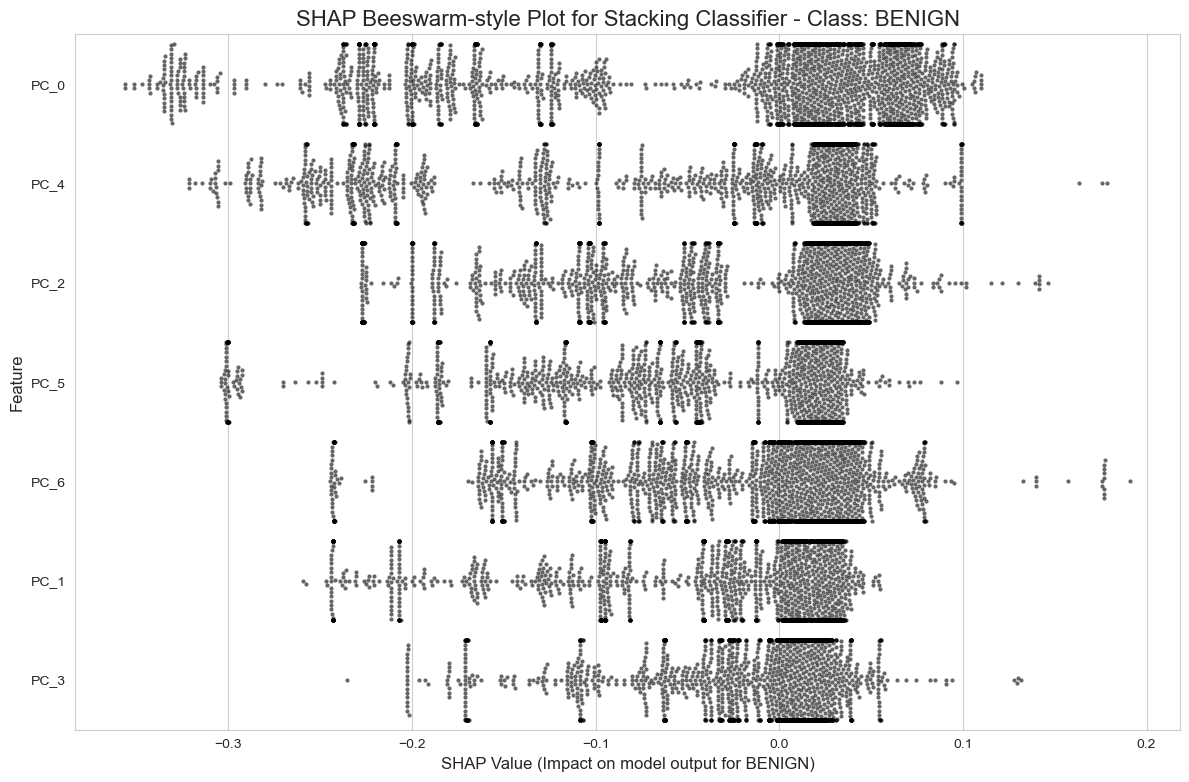

Generating Beeswarm Plot for Class: DDoS


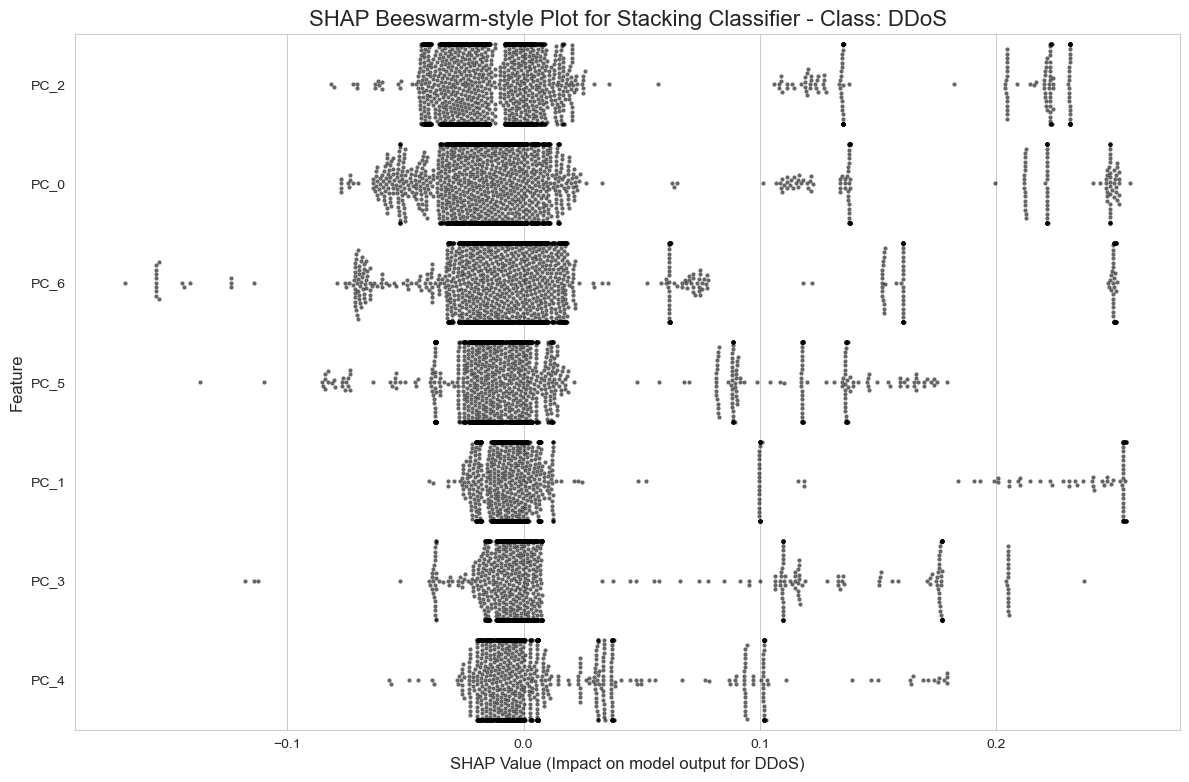

Generating Beeswarm Plot for Class: DoS Hulk


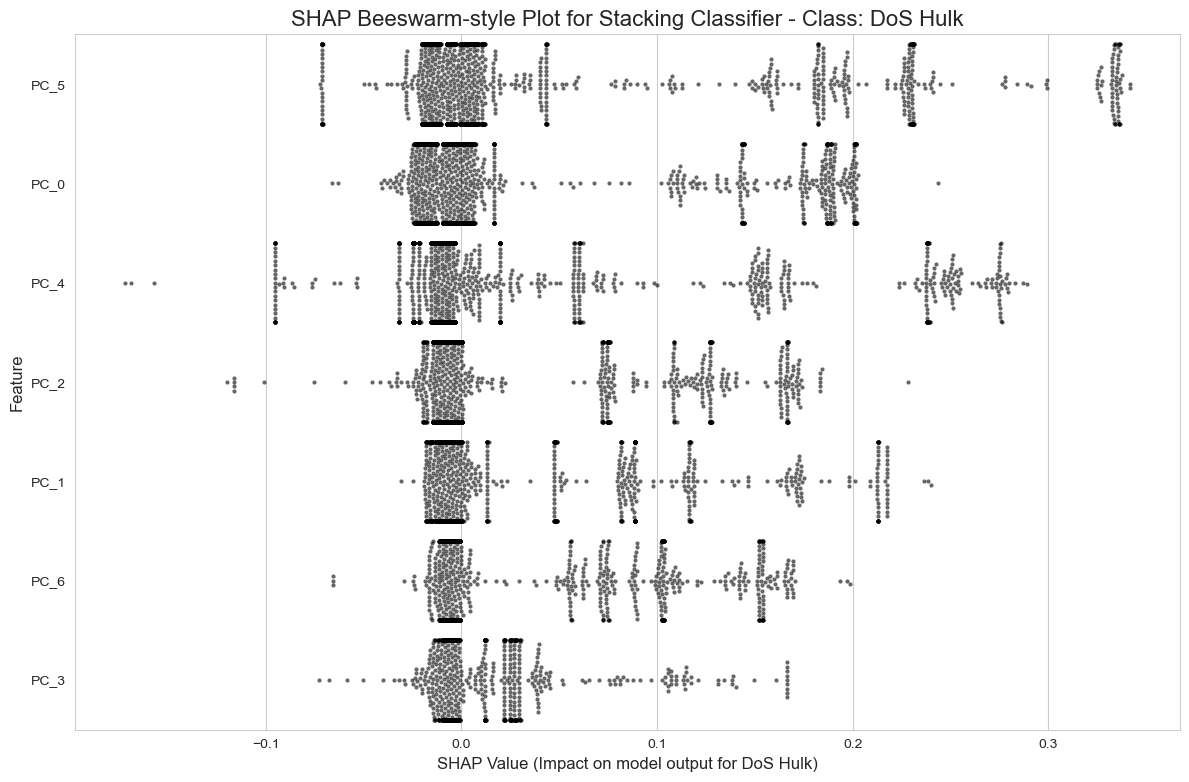

Generating Beeswarm Plot for Class: PortScan


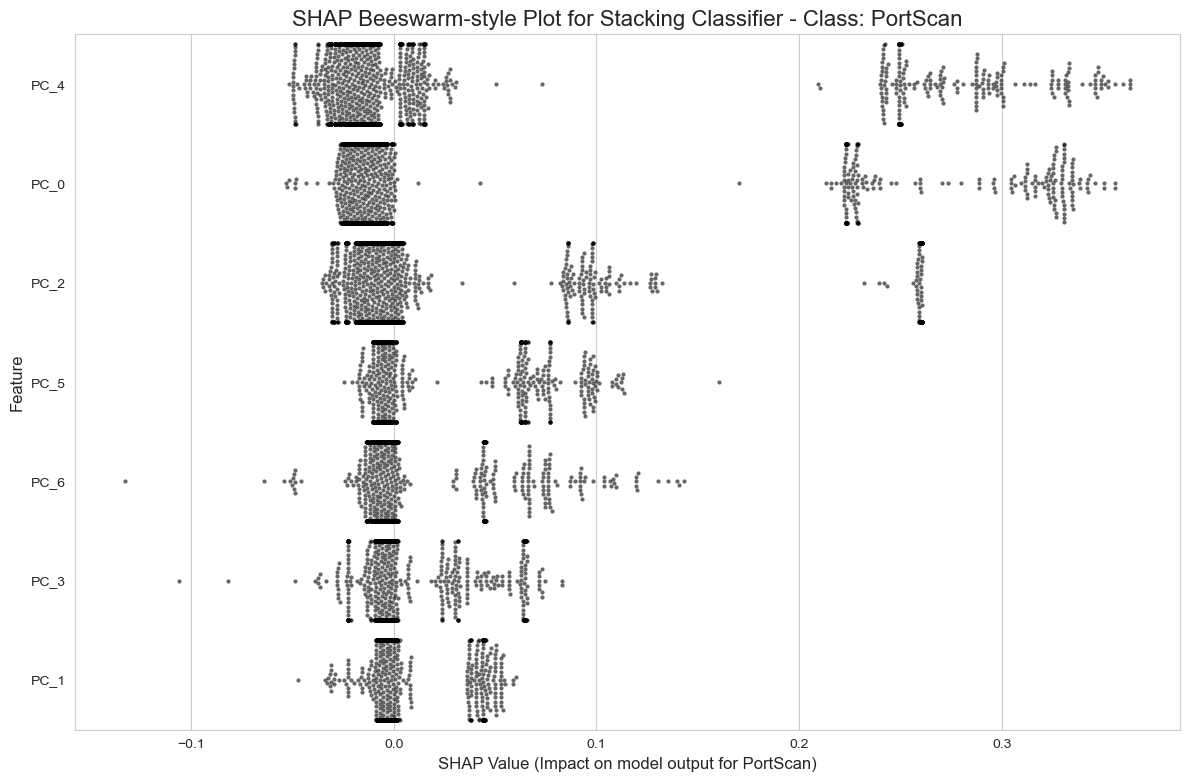

Generating Beeswarm Plot for Class: rare_attack


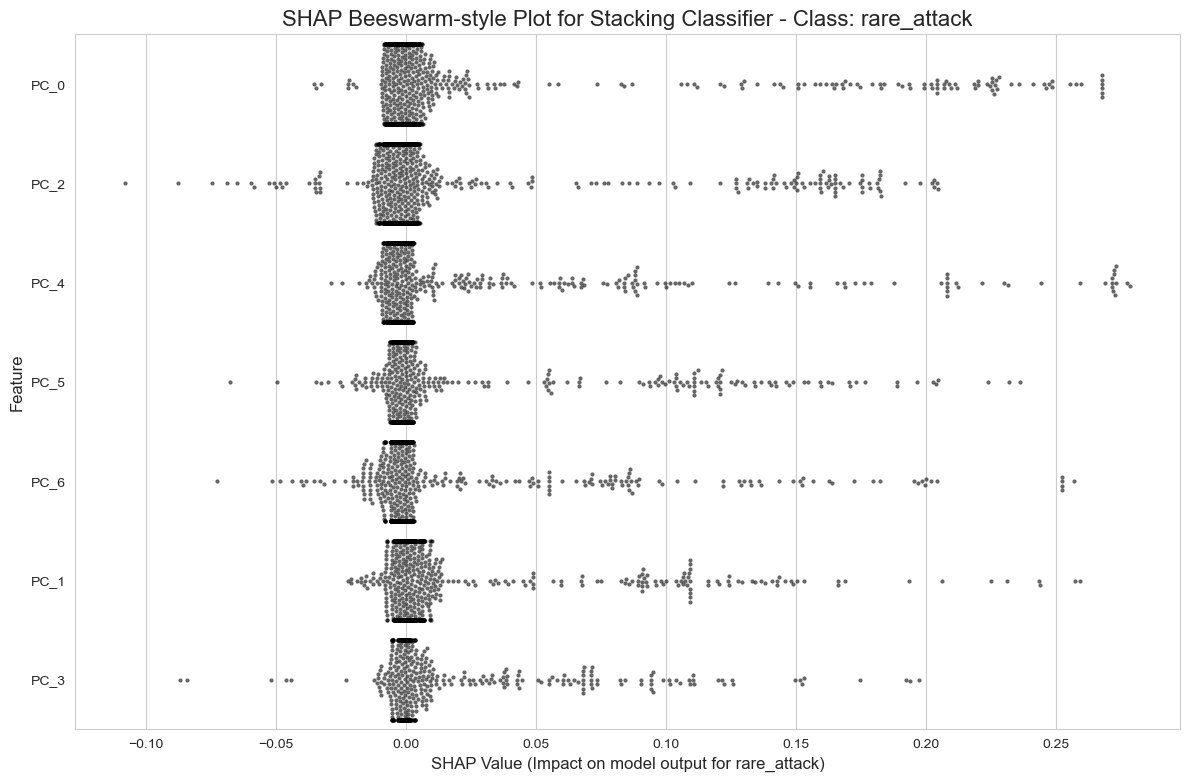


Global Feature Importance (Bar Plot)


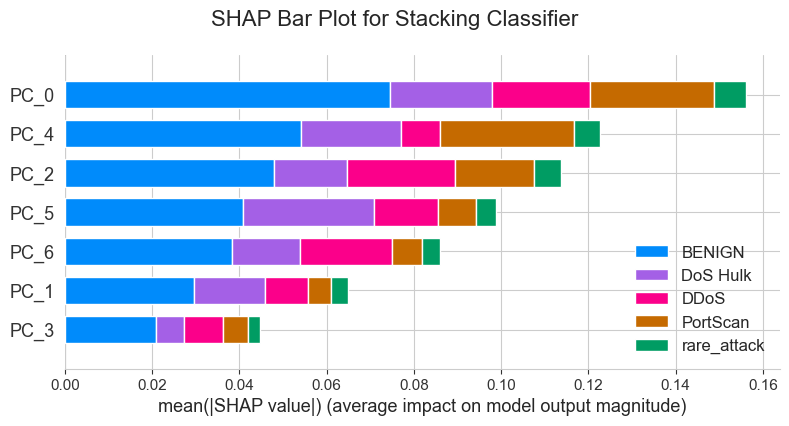


Local Explanation (Force and Waterfall Plots)
Instance 0 predicted as: BENIGN
Generating Force Plot for Instance 0 (Predicted: BENIGN)


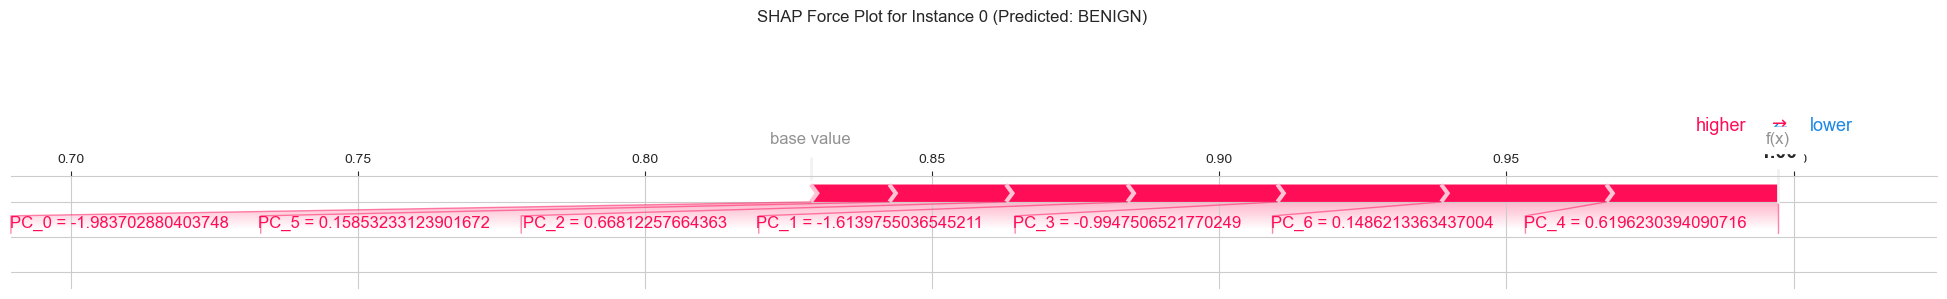

Generating Waterfall Plot for Instance 0 (Explaining: BENIGN)


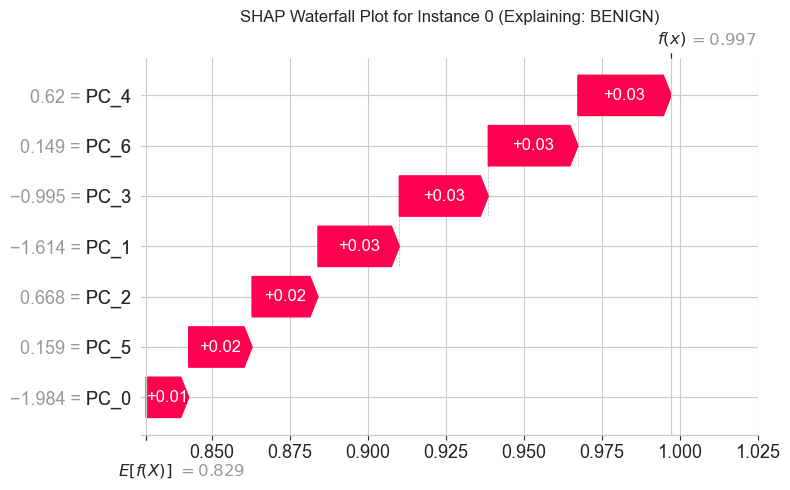


Completed SHAP plotting.


In [18]:
# --- SHAP Explainer Creation and SHAP Value Calculation ---
explainer = None
shap_values = None
explainer_type = "N/A"
model_for_shap = final_model
classifier_for_explainer = None

if model_for_shap is not None and X_test_processed is not None and X_train_processed is not None:
   
    training_columns = None
    try:
        training_columns_path = os.path.join(checkpoint_dir, "training_columns.pkl")
        with open(training_columns_path, "rb") as f:
            training_columns = pickle.load(f)
        print("Loaded training column names.")
    except FileNotFoundError:
        print("Warning: Could not find training column names. SHAP plots may fail or have generic feature names.")
        # Fallback to generic names if columns are not found
        if isinstance(X_train_processed, np.ndarray):
            training_columns = [f"feature_{i}" for i in range(X_train_processed.shape[1])]
    
    # Ensure X_train_processed is a DataFrame for SHAP sampling
    if not isinstance(X_train_processed, pd.DataFrame):
        if training_columns:
            X_train_processed_df = pd.DataFrame(X_train_processed, columns=training_columns)
        else:
            # Last resort for column names
            X_train_processed_df = pd.DataFrame(X_train_processed, columns=[f"feature_{i}" for i in range(X_train_processed.shape[1])])
            
    # Ensure X_test_processed is also a DataFrame
    if not isinstance(X_test_processed, pd.DataFrame):
        if training_columns:
            X_test_processed_df = pd.DataFrame(X_test_processed, columns=training_columns)
        else:
            # Last resort for column names
            X_test_processed_df = pd.DataFrame(X_test_processed, columns=[f"feature_{i}" for i in range(X_test_processed.shape[1])])

    # Now use these consistent DataFrame variables for the rest of the code
    # The background data for SHAP Explainer
    background_size = min(100, len(X_train_processed_df))
    background_data_for_explainer = shap.sample(X_train_processed_df, background_size, random_state=SEED)

    if X_test_processed_df.isnull().any().any() or np.isinf(X_test_processed_df.values).any():
        print("Error: X_test_processed contains NaN or infinite values. SHAP cannot be run. Please clean your data.")
    else:
        try:
            # Determine the classifier for the explainer
            if isinstance(model_for_shap, Pipeline):
                classifier_for_explainer = model_for_shap.steps[-1][1]
            else:
                classifier_for_explainer = model_for_shap

            print(f"\nCreating SHAP Explainer for Model: {type(classifier_for_explainer).__name__}")
            
            # Use the correct explainer based on the model type
            if isinstance(classifier_for_explainer, (RandomForestClassifier, xgb.XGBClassifier)):
                explainer = shap.TreeExplainer(classifier_for_explainer)
                shap_values = explainer.shap_values(X_test_processed_df)
                explainer_type = "TreeExplainer"
            elif isinstance(classifier_for_explainer, (FFN, LSTMNet)):
                classifier_for_explainer.eval()
                with torch.no_grad():
                    background_data_tensor = torch.tensor(background_data_for_explainer.values, dtype=torch.float32).to(device)
                    # LSTM-specific reshaping
                    if isinstance(classifier_for_explainer, LSTMNet):
                        if background_data_tensor.ndim == 2 and classifier_for_explainer.lstm.input_size == 1:
                            background_data_tensor = background_data_tensor.unsqueeze(-1)
                    explainer = shap.DeepExplainer(classifier_for_explainer, background_data_tensor)
                    
                    X_test_tensor = torch.tensor(X_test_processed_df.values, dtype=torch.float32).to(device)
                    # LSTM-specific reshaping
                    if isinstance(classifier_for_explainer, LSTMNet):
                        if X_test_tensor.ndim == 2 and classifier_for_explainer.lstm.input_size == 1:
                            X_test_tensor = X_test_tensor.unsqueeze(-1)
                    
                    shap_values = explainer.shap_values(X_test_tensor)
                    explainer_type = "DeepExplainer"
            else:
                # Use KernelExplainer for all other models (e.g., StackingClassifier, LogisticRegression)
                # This is where the wrapper is essential.
                def model_predict_proba_wrapper(X):
                    # `X` will be a numpy array from KernelExplainer, convert back to DataFrame
                    X_df_temp = pd.DataFrame(X, columns=background_data_for_explainer.columns)
                    return model_for_shap.predict_proba(X_df_temp)
                
                explainer = shap.KernelExplainer(model_predict_proba_wrapper, background_data_for_explainer)
                shap_values = explainer.shap_values(X_test_processed_df)
                explainer_type = "KernelExplainer"
            
            if explainer and shap_values is not None:
                feature_names_for_plot = list(X_test_processed_df.columns)
                plot_multi_class_shap_plots(
                    explainer=explainer,
                    shap_values=shap_values,
                    X_data=X_test_processed_df,
                    feature_names=feature_names_for_plot,
                    class_names=class_names,
                    best_model_name=best_model_name,
                    explainer_type=explainer_type,
                    model_for_shap=model_for_shap,
                    instance_index=0
                )
            else:
                print("\nCould not generate SHAP Explainer or SHAP values. SHAP plots will be skipped.")

        except Exception as e:
            print(f"An unexpected error occurred during SHAP value calculation or plotting: {e}")
            print("SHAP plots will be skipped.")
else:
    print("\nSkipping SHAP interpretation. One or more required components (final_model, X_test_processed, X_train_processed) are missing.")

## 10. Save the Best ML Model
This section saves the best-performing machine learning model, its name, and the label encoder used for the target variable to the specified checkpoint_dir. It intelligently handles saving both PyTorch models (saving state_dict) and scikit-learn models (using joblib.dump) to ensure the entire trained pipeline can be persistently stored and reloaded for future use.

In [19]:
import joblib
import os
import torch
import pickle # Import pickle for LabelEncoder and potentially other hyperparameters

print("\n--- Saving the Best Model (Multi-class) ---")

# ---  Check for Essential Variables and Define Defaults ---
# Assume checkpoint_dir is defined globally or passed as an argument.
# If not, set a default and create it.
if 'checkpoint_dir' not in locals() or checkpoint_dir is None:
    print("Warning: 'checkpoint_dir' is not defined. Using default './model_checkpoints'.")
    checkpoint_dir = "./model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Created default checkpoint_dir: {checkpoint_dir}")

if 'best_model_name' not in locals() or best_model_name is None:
    print("Warning: 'best_model_name' is not defined. Using 'unnamed_model'.")
    best_model_name = "unnamed_model"

# --- Check if final_model exists and save it ---
if 'final_model' in locals() and final_model is not None:
    # Sanitize model name for consistent and clean file names
    sanitized_best_model_name = best_model_name.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_").lower()
    model_filename_base = f'best_multiclass_model_{sanitized_best_model_name}'

    # Construct the full path within the designated checkpoint directory
    model_path_base = os.path.join(checkpoint_dir, model_filename_base)

    try:
        if isinstance(final_model, (torch.nn.Module)):
            # For PyTorch models, save the state dictionary
            torch.save(final_model.state_dict(), f'{model_path_base}_state_dict.pth')
            print(f"PyTorch multi-class model state dictionary saved to {model_path_base}_state_dict.pth")

            # If it's a tuned PyTorch model (FFN or LSTM), save its best parameters too
            if "ffn_tuned" in sanitized_best_model_name: # Check sanitized name
                if 'best_params_ffn_multi_class' in locals():
                    params_path = os.path.join(checkpoint_dir, "best_params_ffn_multi_class.pkl")
                    with open(params_path, "wb") as f:
                        pickle.dump(best_params_ffn_multi_class, f)
                    print(f"Tuned FFN multi-class hyperparameters saved to {params_path}")
                else:
                    print(f"Warning: 'best_params_ffn_multi_class' not found for '{best_model_name}'. Hyperparameters not saved.")
            elif "lstm_tuned" in sanitized_best_model_name: # Check sanitized name
                if 'best_params_lstm_multi_class' in locals():
                    params_path = os.path.join(checkpoint_dir, "best_params_lstm_multi_class.pkl")
                    with open(params_path, "wb") as f:
                        pickle.dump(best_params_lstm_multi_class, f)
                    print(f"Tuned LSTM multi-class hyperparameters saved to {params_path}")
                else:
                    print(f"Warning: 'best_params_lstm_multi_class' not found for '{best_model_name}'. Hyperparameters not saved.")

        else: # For scikit-learn pipelines/models (including XGBoost, RandomForest, LogisticRegression, Stacking, Voting)
            joblib.dump(final_model, f'{model_path_base}.pkl') # Changed to a .pkl extension
            print(f"Scikit-learn multi-class model saved as {model_path_base}.pkl (includes pipeline if applicable)")

        # --- Save best_model_name metadata  ---
        # NOTE: Using the standardized name from the previous stage.
        best_model_name_meta_path = os.path.join(checkpoint_dir, "best_model_name_multi_class.pkl")
        with open(best_model_name_meta_path, "wb") as f:
            pickle.dump(best_model_name, f)
        print(f"Best model original name '{best_model_name}' saved to {best_model_name_meta_path}")

        # --- Save the LabelEncoder  ---
        if 'final_label_encoder' in locals() and final_label_encoder is not None:
            label_encoder_path = os.path.join(checkpoint_dir, "final_multiclass_label_encoder.pkl")
            try:
                with open(label_encoder_path, "wb") as f:
                    pickle.dump(final_label_encoder, f)
                print(f"Final multi-class LabelEncoder saved to {label_encoder_path}")
            except Exception as e:
                print(f"Error saving LabelEncoder to {label_encoder_path}: {e}")
        else:
            print("Warning: 'final_label_encoder' not found. It is highly recommended to save it for consistent multi-class inference.")

    except Exception as e:
        print(f"An error occurred while saving the model: {e}")
else:
    print("No 'final_model' available to save. Please ensure 'final_model' is set from previous training steps.")

print("\n--- End of Saving Best Model ---") 


--- Saving the Best Model (Multi-class) ---
Scikit-learn multi-class model saved as ./model_checkpoints/best_multiclass_model_stacking_classifier.pkl (includes pipeline if applicable)
Best model original name 'Stacking Classifier' saved to ./model_checkpoints/best_model_name_multi_class.pkl
Final multi-class LabelEncoder saved to ./model_checkpoints/final_multiclass_label_encoder.pkl

--- End of Saving Best Model ---


## 11. Implementation
This section defines a Python function 'predict_attack_type' that enables real-time inference and explanation for a deployed machine learning model. It loads a previously trained model (either scikit-learn or PyTorch), a preprocessor, and a label encoder, then takes a new raw observation, preprocesses it, makes a binary attack prediction with certainty, and generates a SHAP waterfall plot to visually explain the key features influencing that specific prediction.

In [20]:
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
import joblib
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import re # For more robust name sanitization
from typing import Union, Dict, Any, Tuple, Optional


class FFN(torch.nn.Module):
    def __init__(self, input_dim: int, num_classes: int, dropout_rate: float = 0.0):
        super(FFN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate) # Add dropout layer
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

class LSTMNet(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int, dropout_rate: float = 0.0):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # input_dim here refers to the feature dimension of each element in the sequence
        # For PCA components treated as a sequence, input_dim would be 1.
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout_rate) # Dropout after LSTM output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, sequence_length, input_dim)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :]) # Get output from the last time step, apply dropout
        out = self.fc(out)
        return out

def _sanitize_model_name(name: str) -> str:
    """Sanitizes the model name for use in filenames."""
    # Replace spaces and special characters with underscores, convert to lowercase
    return re.sub(r'[^a-z0-9_]', '', name.lower().replace(" ", "_"))

def predict_attack_type(
    observation_raw: Union[Dict, pd.DataFrame, pd.Series],
    best_model_name_for_loading: str,
    device_for_pred: str = 'cpu',
    checkpoint_dir: str = "./model_checkpoints"
) -> Tuple[Optional[str], Optional[float], Optional[Dict]]:
    """
    Predicts the type of network attack (multi-class classification) using a trained model
    and provides SHAP explanations.

    Args:
        observation_raw (dict or pd.DataFrame or pd.Series): A single network flow's data.
        best_model_name_for_loading (str): The name of the best model (e.g., "XGBoost Classifier")
                                            used to construct the filename.
        device_for_pred (str): Device to run PyTorch models on ('cpu' or 'cuda').
        checkpoint_dir (str): Directory where models, preprocessor, and label encoder are saved.

    Returns:
        tuple:
            - str: Predicted attack type (e.g., 'Normal', 'DoS', 'rare_attack'), or None if error.
            - float: Certainty (probability) of the predicted class, as a percentage, or None if error.
            - dict: A dictionary containing the SHAP explanation data (values, base_value, data, feature_names)
                    for the predicted class, or None if SHAP failed or components couldn't be loaded.
    """
    model: Any = None
    preprocessor: Any = None
    label_encoder: Optional[LabelEncoder] = None
    background_data_for_shap: Optional[np.ndarray] = None
    shap_explanation_data: Optional[Dict[str, Any]] = None # To store SHAP components
    feature_names_original: Optional[list] = None # To store original feature names for validation
    class_names: Optional[np.ndarray] = None
    num_classes: Optional[int] = None

    # --- Path Definitions (centralized and multi-class specific) ---
    sanitized_model_name = _sanitize_model_name(best_model_name_for_loading)
    model_pkl_path = os.path.join(checkpoint_dir, f'best_multiclass_model_{sanitized_model_name}.joblib') # For scikit-learn models
    model_pth_path = os.path.join(checkpoint_dir, f'best_multiclass_model_{sanitized_model_name}_state_dict.pth') # For PyTorch models
    preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor.joblib')
    label_encoder_path = os.path.join(checkpoint_dir, 'final_multiclass_label_encoder.pkl')
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background.joblib')
    original_feature_names_path = os.path.join(checkpoint_dir, 'original_feature_names.pkl')

    # Paths for tuned PyTorch model parameters
    best_params_ffn_path = os.path.join(checkpoint_dir, "best_params_ffn_multi_class.pkl")
    best_params_lstm_path = os.path.join(checkpoint_dir, "best_params_lstm_multi_class.pkl")

    # --- Load Required Components ---
    try:
        # Load the preprocessor first to get feature details if needed
        if os.path.exists(preprocessor_path):
            preprocessor = joblib.load(preprocessor_path) # Direct load from path
            print(f"Loaded preprocessor from {preprocessor_path}")
        else:
            raise FileNotFoundError(f"Preprocessor not found at {preprocessor_path}. Cannot proceed.")

        # Load original feature names for input validation
        if os.path.exists(original_feature_names_path):
            with open(original_feature_names_path, "rb") as file:
                feature_names_original = pickle.load(file)
            print(f"Loaded original feature names from {original_feature_names_path}")
        else:
            print(f"Warning: Original feature names not found at {original_feature_names_path}. Input validation may be less strict.")

        # Load label encoder (crucial for num_classes and inverse_transform)
        if os.path.exists(label_encoder_path):
            with open(label_encoder_path, "rb") as file:
                label_encoder = pickle.load(file)
            print(f"Loaded label encoder from {label_encoder_path}")
            class_names = label_encoder.classes_
            num_classes = len(class_names)
        else:
            raise FileNotFoundError(f"Label encoder not found at {label_encoder_path}. Cannot determine number of classes.")

        # Load the trained model
        if os.path.exists(model_pkl_path):
            model = joblib.load(model_pkl_path)
            print(f"Loaded scikit-learn model from {model_pkl_path}")
        elif os.path.exists(model_pth_path):
            # For PyTorch models, need to instantiate the class first
            input_dim: Optional[int] = None
            # Infer input_dim from preprocessor (more robust)
            try:
                # Create a dummy dataframe with the expected number of original features
                # Even if original_feature_names is None, we need a placeholder for preprocessor.transform
                dummy_input_cols = feature_names_original if feature_names_original is not None else [f'col_{i}' for i in range(10)] # Placeholder
                dummy_data = pd.DataFrame(0.0, index=[0], columns=dummy_input_cols)
                if feature_names_original is None: # Adjust dummy_data if original feature names were not loaded
                    print("Warning: Using dummy data for input_dim inference as original feature names not found. This might be inaccurate.")
                    # Attempt to get a single row of the transformed data from background_data_for_shap if available
                    # This is a bit of a chicken-and-egg problem if background_data_for_shap also needs input_dim.
                    # Best to save input_dim explicitly during training.
                    if os.path.exists(shap_background_path):
                        # Load a small sample to get shape
                        temp_bg = joblib.load(shap_background_path)
                        if hasattr(temp_bg, 'values'): temp_bg = temp_bg.values
                        input_dim = temp_bg.shape[1]
                        print(f"Inferred input_dim from SHAP background data: {input_dim}")
                    else:
                        raise ValueError("Cannot infer input_dim for PyTorch model. 'original_feature_names.pkl' or 'X_train_processed_for_shap_background.joblib' missing.")
                else:
                    input_dim = preprocessor.transform(dummy_data).shape[1]
                    print(f"Inferred input_dim from preprocessor: {input_dim}")
            except Exception as e:
                raise ValueError(f"Could not determine input_dim for PyTorch model: {e}. Ensure preprocessor is compatible or input_dim is explicitly saved/passed during training.")

            if input_dim is None: # This should ideally be caught by the ValueError above, but as a safeguard.
                raise ValueError("Input_dim could not be determined for PyTorch model.")
            if num_classes is None: # Also should be caught earlier.
                raise ValueError("Number of classes could not be determined for PyTorch model.")

            # Load tuned hyperparameters if available and instantiate model
            tuned_dropout_rate_ffn = 0.0
            tuned_hidden_dim_lstm = 64
            tuned_num_layers_lstm = 2
            tuned_dropout_rate_lstm = 0.0

            if "ffn" in sanitized_model_name:
                if os.path.exists(best_params_ffn_path):
                    with open(best_params_ffn_path, 'rb') as f:
                        best_params_ffn_loaded = pickle.load(f)
                    tuned_dropout_rate_ffn = best_params_ffn_loaded.get('dropout_rate', 0.0)
                    print(f"Loaded tuned FFN dropout_rate: {tuned_dropout_rate_ffn}")
                model = FFN(input_dim=input_dim, num_classes=num_classes, dropout_rate=tuned_dropout_rate_ffn).to(device_for_pred)
            elif "lstm" in sanitized_model_name:
                if os.path.exists(best_params_lstm_path):
                    with open(best_params_lstm_path, 'rb') as f:
                        best_params_lstm_loaded = pickle.load(f)
                    tuned_hidden_dim_lstm = best_params_lstm_loaded.get('hidden_dim', tuned_hidden_dim_lstm)
                    tuned_num_layers_lstm = best_params_lstm_loaded.get('num_layers', tuned_num_layers_lstm)
                    tuned_dropout_rate_lstm = best_params_lstm_loaded.get('dropout_rate', 0.0)
                    print(f"Loaded tuned LSTM params: hidden_dim={tuned_hidden_dim_lstm}, num_layers={tuned_num_layers_lstm}, dropout_rate={tuned_dropout_rate_lstm}")
                # For LSTM, input_dim for the layer itself is typically 1 if each PCA component is a timestep
                # The total number of PCA components then becomes the sequence_length
                model = LSTMNet(input_dim=1, hidden_dim=tuned_hidden_dim_lstm, num_layers=tuned_num_layers_lstm, output_dim=num_classes, dropout_rate=tuned_dropout_rate_lstm).to(device_for_pred)
            else:
                raise ValueError(f"Unknown PyTorch model type based on name: {best_model_name_for_loading} (sanitized: {sanitized_model_name})")

            model.load_state_dict(torch.load(model_pth_path, map_location=device_for_pred))
            model.eval() # Set to evaluation mode
            print(f"Loaded PyTorch model from {model_pth_path} and set to eval mode.")
        else:
            raise FileNotFoundError(f"No model found at {model_pkl_path} or {model_pth_path}")

        # Load SHAP background data
        if os.path.exists(shap_background_path):
            background_data_for_shap = joblib.load(shap_background_path)
            if isinstance(background_data_for_shap, pd.DataFrame): # If it's a DataFrame
                background_data_for_shap = background_data_for_shap.values
            
            # Ensure background data is float32 for PyTorch consistency and sample for efficiency
            if background_data_for_shap.shape[0] > 100: # Only sample if large enough
                background_data_for_shap = shap.utils.sample(background_data_for_shap, 100, random_state=42)
            background_data_for_shap = background_data_for_shap.astype(np.float32)
            print(f"Loaded and sampled SHAP background data from {shap_background_path} (shape: {background_data_for_shap.shape})")
        else:
            print(f"Warning: SHAP background data not found at {shap_background_path}. SHAP explanations might be less accurate or fail for KernelExplainer/DeepExplainer.")

    except FileNotFoundError as e:
        print(f"Critical Error: {e}")
        return None, None, None
    except ValueError as e:
        print(f"Configuration/Loading Error: {e}")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during component loading: {e}")
        return None, None, None

    # Ensure all necessary components are loaded
    if model is None or preprocessor is None or label_encoder is None:
        print("Required model components failed to load. Aborting prediction.")
        return None, None, None

    # --- Input Observation Preprocessing ---
    # Convert observation to DataFrame and validate columns
    if isinstance(observation_raw, dict):
        observation_df = pd.DataFrame([observation_raw])
    elif isinstance(observation_raw, pd.Series):
        observation_df = pd.DataFrame([observation_raw.values], columns=observation_raw.index)
    elif isinstance(observation_raw, pd.DataFrame):
        if len(observation_raw) != 1:
            raise ValueError("Input DataFrame must contain exactly one observation (row).")
        observation_df = observation_raw
    else:
        raise TypeError("Observation must be a dict, pandas Series, or pandas DataFrame.")

    # Validate feature names and order if original_feature_names are available
    if feature_names_original is not None:
        missing_cols = set(feature_names_original) - set(observation_df.columns)
        if missing_cols:
            raise ValueError(f"Input observation is missing expected features: {', '.join(missing_cols)}")
        extra_cols = set(observation_df.columns) - set(feature_names_original)
        if extra_cols:
            print(f"Warning: Input observation has extra features that will be ignored: {', '.join(extra_cols)}")
        observation_df = observation_df[feature_names_original] # Ensure consistent column order

    try:
        observation_processed_array = preprocessor.transform(observation_df)
    except Exception as e:
        print(f"Error during preprocessing observation: {e}")
        return None, None, None

    # Determine feature names for SHAP (after PCA/preprocessing)
    shap_feature_names: list[str]
    if hasattr(preprocessor, 'get_feature_names_out'):
        try:
            shap_feature_names = preprocessor.get_feature_names_out().tolist() # Ensure list for consistency
        except Exception: # Fallback if get_feature_names_out fails
            shap_feature_names = [f'PC_{i}' for i in range(observation_processed_array.shape[1])]
    else:
        # Fallback for PCA or other simple transformers where n_components_ is available
        if hasattr(preprocessor, 'n_components_'):
            shap_feature_names = [f'PC_{i}' for i in range(preprocessor.n_components_)]
        else:
            shap_feature_names = [f'Feature_{i}' for i in range(observation_processed_array.shape[1])]

    observation_processed_df = pd.DataFrame(observation_processed_array, columns=shap_feature_names)

    # --- Prediction and Probability ---
    probabilities: Optional[np.ndarray] = None
    predicted_encoded_label: Optional[int] = None

    # Helper for PyTorch predict_proba (multi-class version)
    def _predict_proba_pytorch(model_to_pred: torch.nn.Module, data_tensor: torch.Tensor, is_lstm: bool = False) -> np.ndarray:
        model_to_pred.eval()
        with torch.no_grad():
            if is_lstm:
                # For LSTM, input should be (batch_size, sequence_length, input_dim_per_step)
                # If PCA components are treated as sequence, then sequence_length = num_pca_components, input_dim_per_step = 1
                if data_tensor.ndim == 2: # (batch_size, num_features) -> (batch_size, num_features, 1)
                    data_tensor = data_tensor.unsqueeze(-1)
            logits = model_to_pred(data_tensor)
            return torch.softmax(logits, dim=1).cpu().numpy()

    if isinstance(model, (FFN, LSTMNet)):
        obs_tensor = torch.tensor(observation_processed_array, dtype=torch.float32).to(device_for_pred)
        probabilities = _predict_proba_pytorch(model, obs_tensor, is_lstm=isinstance(model, LSTMNet))[0]
        predicted_encoded_label = np.argmax(probabilities).item() # .item() to get scalar
    else: # Scikit-learn models
        probabilities = model.predict_proba(observation_processed_df)[0]
        predicted_encoded_label = model.predict(observation_processed_df)[0]

    if label_encoder is None or predicted_encoded_label is None or class_names is None:
        print("Prediction failed due to missing label encoder or prediction result.")
        return None, None, None

    # Convert encoded prediction back to human-readable label
    predicted_label_name = label_encoder.inverse_transform([predicted_encoded_label])[0]

    # Get certainty as the probability of the predicted class
    certainty = probabilities[predicted_encoded_label] * 100

    # --- SHAP Explanation ---
    print("\n--- Generating SHAP Explanation ---")
    shap_values_for_plot: Optional[shap.Explanation] = None

    # Define a consistent predict_proba function for KernelExplainer
    def _get_model_predict_proba_for_shap(m: Any):
        if isinstance(m, (FFN, LSTMNet)):
            def predict_proba_fn(data_np: np.ndarray) -> np.ndarray:
                # Convert numpy array to torch tensor, handle LSTM shape if needed
                data_tensor = torch.tensor(data_np, dtype=torch.float32).to(device_for_pred)
                return _predict_proba_pytorch(m, data_tensor, is_lstm=isinstance(m, LSTMNet))
            return predict_proba_fn
        else: # Assumed to be scikit-learn compatible model
            return m.predict_proba

    try:
        # Determine the correct instance for SHAP explanation (model or final estimator in pipeline)
        model_for_shap: Any = model
        if isinstance(model, Pipeline):
            # Get the final estimator in the pipeline
            model_for_shap = model.steps[-1][1]

        if model_for_shap is None:
            raise ValueError("Could not extract a suitable model for SHAP explanation.")

        explainer: Any = None
        # Ensure instance_to_explain_np is 2D for shap explainers (1, num_features)
        instance_to_explain_np = observation_processed_array[0].reshape(1, -1)

        if isinstance(model_for_shap, (xgb.XGBClassifier, RandomForestClassifier)):
            explainer = shap.TreeExplainer(model_for_shap)
            # TreeExplainer on a single instance for multi-class returns an Explanation object
            # where .values is (1, num_classes, num_features) or (num_classes, num_features)
            # and .base_values is (num_classes,)
            raw_shap_explanation = explainer(observation_processed_df)

            # Ensure we extract the correct Explanation for the predicted class
            if isinstance(raw_shap_explanation, shap.Explanation):
                if raw_shap_explanation.values.ndim == 3 and raw_shap_explanation.values.shape[0] == 1:
                    # Case: (1, num_classes, num_features)
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_explanation.values[0, predicted_encoded_label, :],
                        base_values=raw_shap_explanation.base_values[predicted_encoded_label],
                        data=raw_shap_explanation.data[0],
                        feature_names=shap_feature_names
                    )
                elif raw_shap_explanation.values.ndim == 2 and raw_shap_explanation.values.shape[0] == num_classes:
                     # Case: (num_classes, num_features) - direct output from some TreeExplainer versions
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_explanation.values[predicted_encoded_label, :],
                        base_values=raw_shap_explanation.base_values[predicted_encoded_label],
                        data=raw_shap_explanation.data[0], # Assuming data is still 1D or (1, num_features)
                        feature_names=shap_feature_names
                    )
                else:
                    print(f"Warning: Unexpected TreeExplainer SHAP values shape: {raw_shap_explanation.values.shape} for multi-class.")

            else:
                print(f"Warning: Unexpected TreeExplainer result type: {type(raw_shap_explanation)}.")

        elif isinstance(model_for_shap, (LogisticRegression, StackingClassifier)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                explainer = shap.KernelExplainer(_get_model_predict_proba_for_shap(model_for_shap), background_data_for_shap)
                # KernelExplainer's shap_values for multi-class is a list of arrays (one array per class)
                # each array is (num_instances, num_features)
                raw_shap_values = explainer.shap_values(instance_to_explain_np) # Expects 2D input (1, num_features)

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > predicted_encoded_label:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[predicted_encoded_label][0], # Values for predicted class, first instance
                        base_values=explainer.expected_value[predicted_encoded_label], # Base value for predicted class
                        data=instance_to_explain_np[0], # Data for the single instance (1D)
                        feature_names=shap_feature_names
                    )
                else:
                    print(f"Warning: Unexpected KernelExplainer SHAP values format: {type(raw_shap_values)} for multi-class.")
            else:
                print("Skipping SHAP KernelExplainer: Background data not loaded or empty.")

        elif isinstance(model_for_shap, (FFN, LSTMNet)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                background_tensor = torch.tensor(background_data_for_shap, dtype=torch.float32).to(device_for_pred)
                if isinstance(model_for_shap, LSTMNet):
                    if background_tensor.ndim == 2:
                        background_tensor = background_tensor.unsqueeze(-1) # (samples, num_features, 1)

                explainer = shap.DeepExplainer(model_for_shap, background_tensor)

                obs_tensor_for_shap = torch.tensor(instance_to_explain_np, dtype=torch.float32).to(device_for_pred)
                if isinstance(model_for_shap, LSTMNet):
                    obs_tensor_for_shap = obs_tensor_for_shap.unsqueeze(-1) # (1, num_features, 1)

                # DeepExplainer's shap_values for multi-class is a list of arrays (one array per class)
                # each array is (num_instances, num_features)
                raw_shap_values = explainer.shap_values(obs_tensor_for_shap)

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > predicted_encoded_label:
                    # DeepExplainer's expected_value for multi-output is a list/array of values, one per output.
                    # Ensure base_values matches the predicted class.
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[predicted_encoded_label][0], # Values for predicted class, first instance
                        base_values=explainer.expected_value[predicted_encoded_label], # Base value for predicted class
                        data=instance_to_explain_np[0], # Data for the single instance (1D)
                        feature_names=shap_feature_names
                    )
                else:
                    print(f"Warning: Unexpected DeepExplainer SHAP values format: {type(raw_shap_values)} for multi-class.")
            else:
                print("Skipping SHAP DeepExplainer: Background data not loaded or empty.")
        else:
            print(f"SHAP explanation not implemented for model type: {type(model_for_shap)}")

        # --- SHAP Plotting and Data Storage ---
        if shap_values_for_plot is not None:
            plt.figure(figsize=(10, 6))
            shap.waterfall_plot(shap_values_for_plot, show=False)
            plt.title(f"SHAP Waterfall Plot for Predicted: {predicted_label_name} (Certainty: {certainty:.2f}%)")
            plt.tight_layout()
            plt.show()

            # Store SHAP explanation components
            shap_explanation_data = {
                'values': shap_values_for_plot.values.tolist(),
                'base_value': shap_values_for_plot.base_values, # Can be scalar or array
                'data': shap_values_for_plot.data.tolist(),
                'feature_names': shap_values_for_plot.feature_names
            }
        else:
            print("SHAP explanation object could not be finalized for plotting.")

    except Exception as e:
        print(f"Error generating SHAP explanation: {e}")
        print("Please ensure SHAP is compatible with your model type and background data is provided correctly.")

    return predicted_label_name, certainty, shap_explanation_data